In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch 
import torch.nn.functional as F
from dotenv import load_dotenv
from scipy.stats import wasserstein_distance
import scienceplots
from matplotlib.ticker import MaxNLocator
from astropy.table import Table


from data.load_data import load_data
from data.load_tokens import DATA_FILES, combinations
from datasets import load_dataset

from IPython.display import display

plt.style.use("science")

data = {}
divs = {}
tok_z = {}
tok_z_p = {}

load_dotenv()

DATA_ROOT = os.getenv("DATA_ROOT")
DATA_FOLDER = os.getenv("DATA_FOLDER")
base = Path(DATA_ROOT) / DATA_FOLDER

/home/phys2526/AION1_experiments/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1025
3815


In [2]:
for name in combinations.keys():
    data[name] = load_dataset("parquet", data_files=DATA_FILES, split=name)

#combinations.pop("true_z")

true_z = torch.tensor(data["true_z"]["tok_z"])
target_ids = data[name]["TARGETID"]

true_z_p = F.softmax(true_z, dim=-1)
#target_id = (data["true_z"]["target_id"]
for name in combinations.keys():
    tok_z[name] = torch.tensor(data[name]["tok_z"])
    tok_z_p[name] = F.softmax(tok_z[name], dim=-1)
    assert target_ids == data[name]["TARGETID"] # double check everything lines up.

table = load_data()
# map each TARGETID to its position in target_ids
order_map = {tid: i for i, tid in enumerate(target_ids)}
default_rank = len(target_ids)  # for IDs not in the list (they go last)

# build an array of sort keys for each row
sort_key = np.array([order_map.get(tid, default_rank) for tid in table['TARGETID']])

# apply the sort
table_sorted = table[np.argsort(sort_key)] 

In [50]:
def plot_z_dist(
    check_df,
    table_sorted,
    names,
    tok_z_p,
    ascending=True
):
    cols_to_show = ["TARGETID","sSFR", "LOG_MSTAR", "legacysurvey_EBV", "desi_Z"]
    for idx, row in check_df.sort_values("ratio_p_ip", ascending=ascending).iterrows():
        img     = table_sorted[idx]["legacysurvey_image_rgb"]
        flux    = table_sorted[idx]["desi_spectrum_flux"]
        lambda_ = table_sorted[idx]["desi_spectrum_lambda"]
        mask    = table_sorted[idx]["desi_spectrum_mask"]

        # --- object properties table ---
        row_tab = table_sorted[idx:idx+1][cols_to_show]   # 1-row Astropy Table slice
        display(row_tab)
        display(row)

        # --- Z predictions table ---
        z_rows = []
        for name in names[0:-1]:
            z = tok_z_p[name][idx, :].detach().cpu().numpy()
            z_pred = z.argmax() * (6.0 / 1025.0)
            z_rows.append((name, z_pred))

        z_tab = Table(rows=z_rows, names=["modality", "Z_prediction"])
        z_tab["Z_prediction"].format = ".3f"   # nice formatting

        # true DESI redshift
        desi_z = float(table_sorted[idx]["desi_Z"])

        # difference: prediction - true
        z_tab["Diff. from true Z"] = z_tab["Z_prediction"] - desi_z
        z_tab["Diff. from true Z"].format = ".3f"

        # --- plots ---
        fig, axes = plt.subplots(
            1, 2, figsize=(14, 6),
            gridspec_kw={"width_ratios": [1, 3]}
        )

        axes[0].imshow(img)
        axes[0].set_title(f"TARGETID {table_sorted[idx]['TARGETID']}")
        axes[0].axis("off")

        axes[1].plot(lambda_[~mask], flux[~mask], c="black")
        axes[1].set_title("DESI spectrum flux")
        axes[1].set_xlabel(r"$\lambda / \AA$")
        axes[1].set_ylabel("Flux")
        axes[1].tick_params(axis='both', which='major', labelsize=16)

        plt.tight_layout()
        plt.show()

        _, ax = plt.subplots(figsize=(6, 4), dpi=300)

        for name in names[0:-1]:
            z = tok_z_p[name][idx, :].detach().cpu().numpy()
            z_grid = np.linspace(0, 6, len(z))
            ax.plot(z_grid, z, label=name)

        # true z line
        ax.axvline(table_sorted[idx]["Z_HP"], ls="--", c="black", label="True $z$")

        #ax.set_xlim(max(0, table_sorted[idx]["Z_HP"] - 0.25), table_sorted[idx]["Z_HP"] + 0.25)
        ax.set_xlabel("z", fontsize=14)
        ax.set_ylabel(r"$p(z)$", fontsize=14)

        ax.legend(fontsize=10)
        plt.tight_layout()
        plt.show()
        print("------------------------------------------------")

## Reshift distribution examples using different modalities

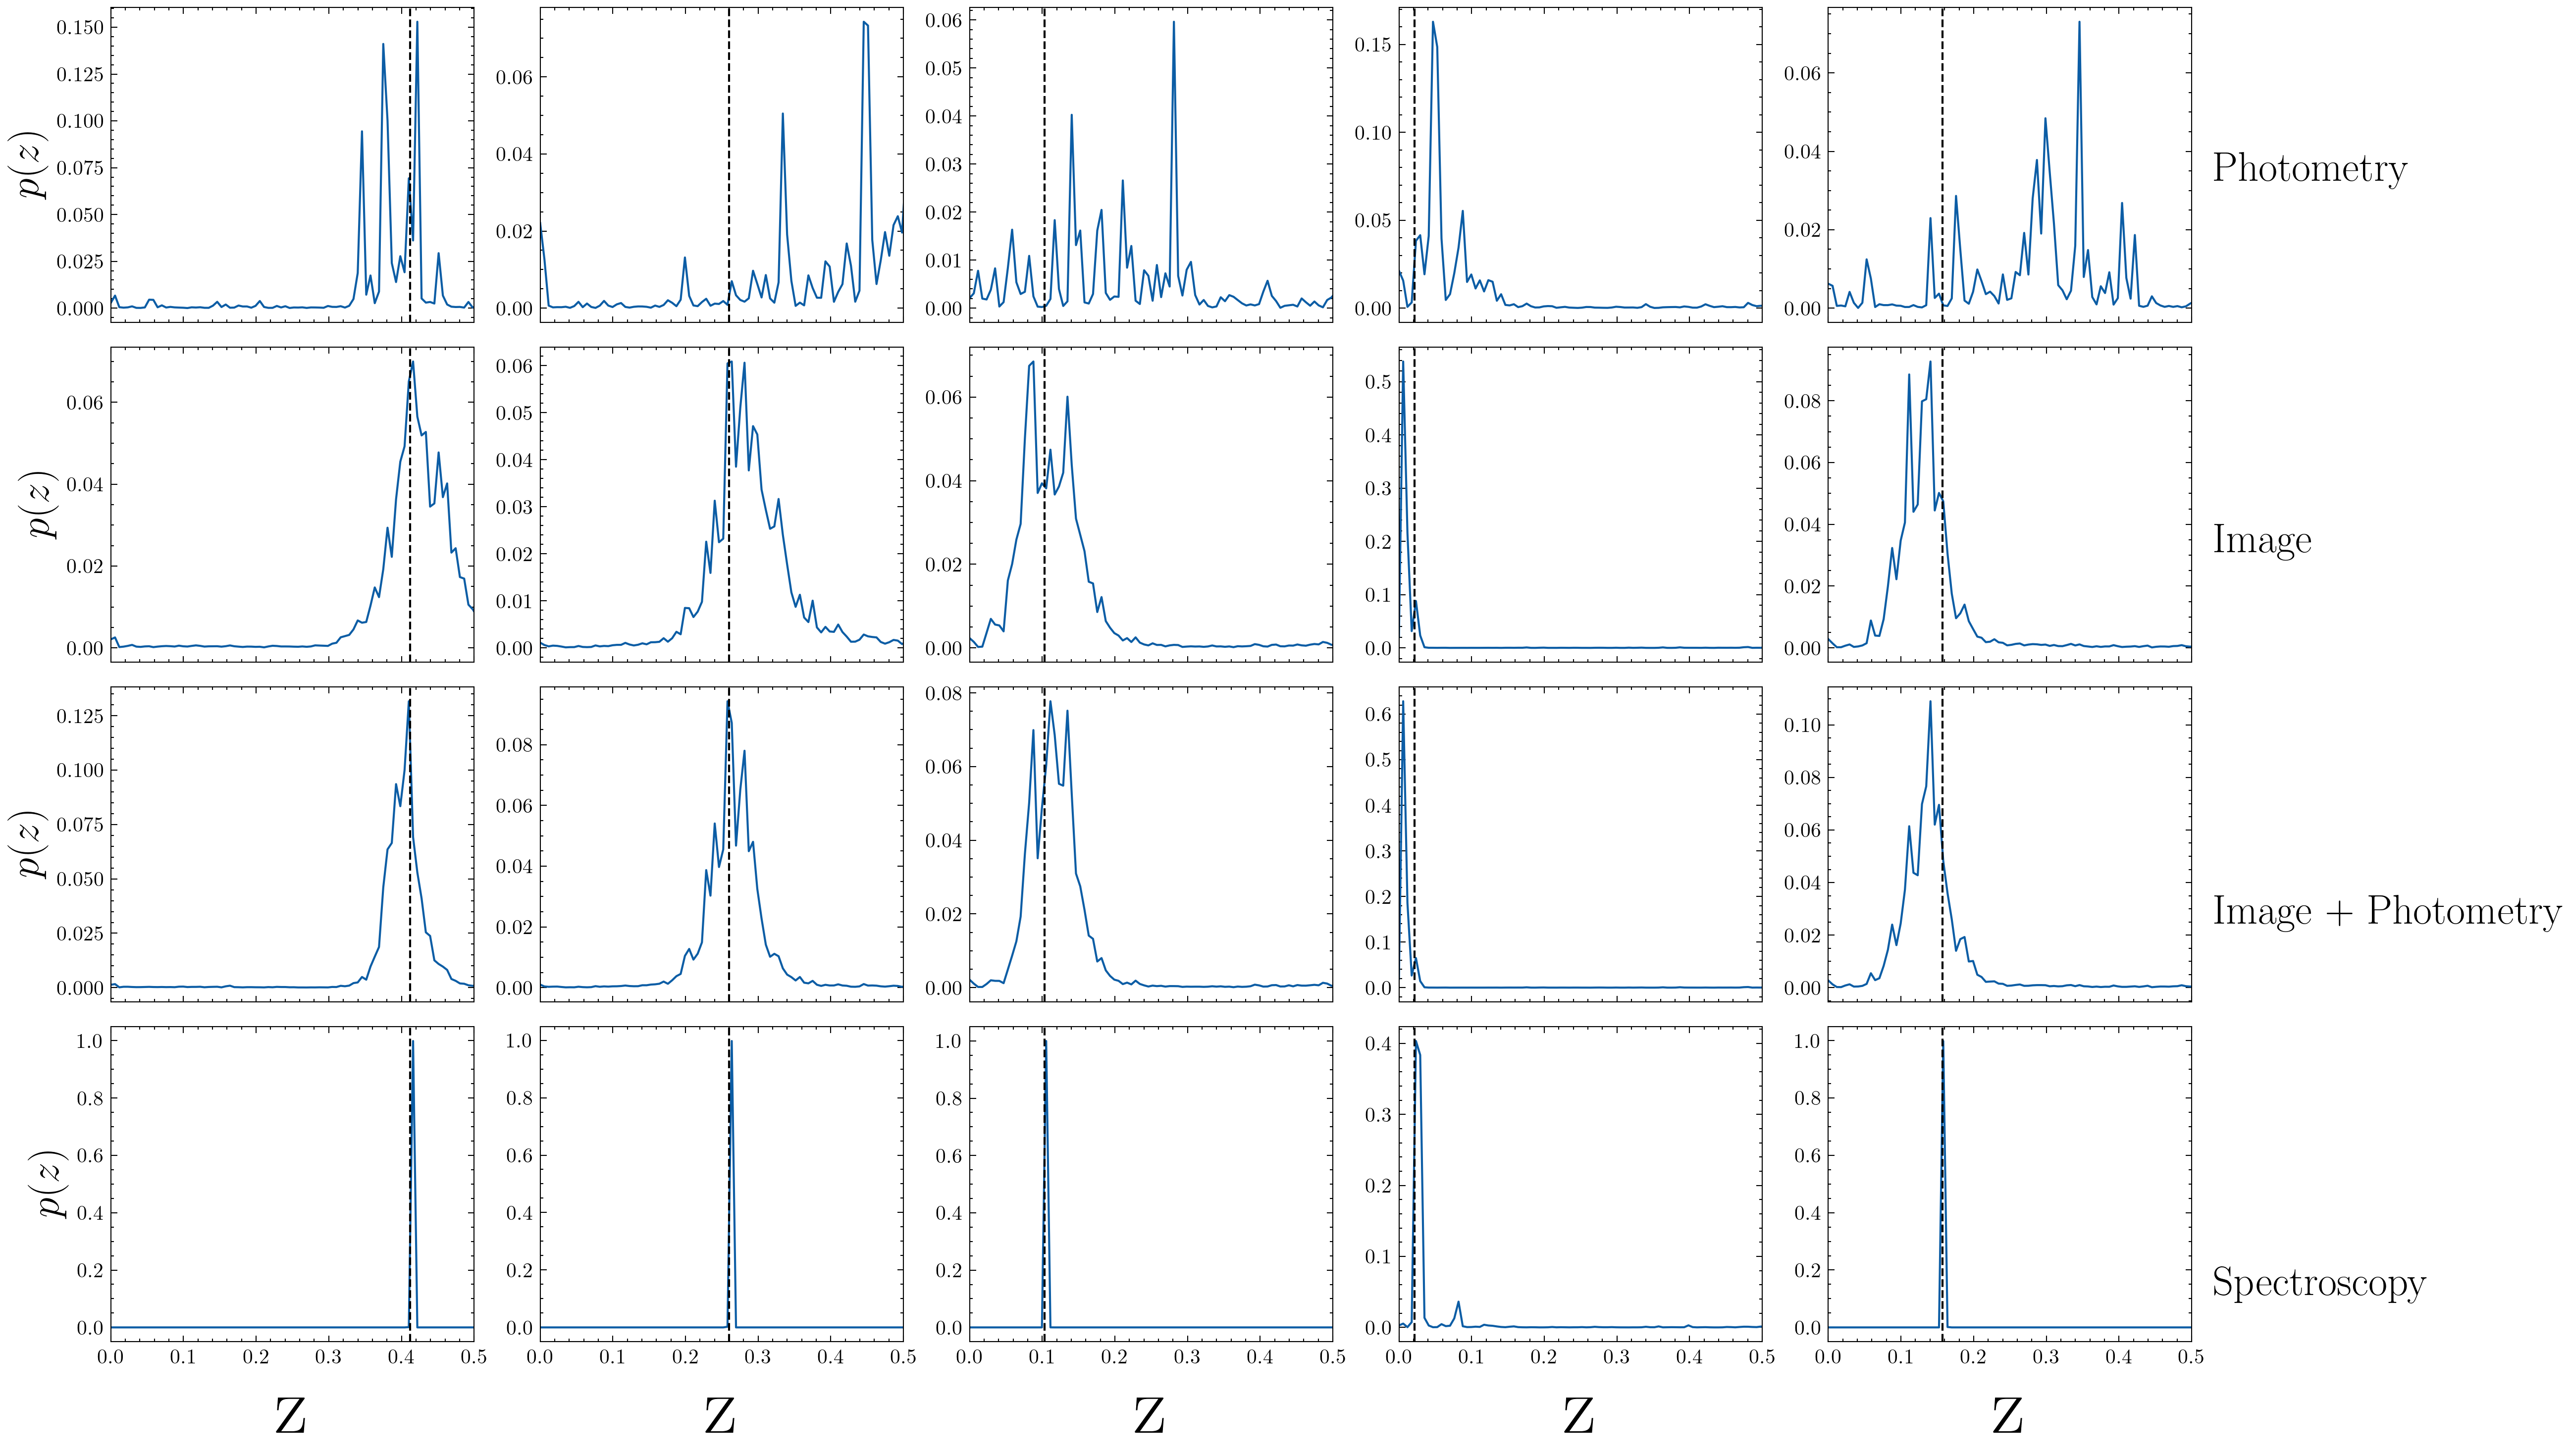

In [5]:
names = ["photometry", "imaging", "image_photometry", "spectroscopy"]
n_rows = len(names)
n_cols = 5  # number of different idx you want

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(3 * n_cols, 2.5 * n_rows),
    sharex=True,
    dpi=300
)

for col in range(n_cols):
    # pick a different idx for each column
    idx = int(torch.randint(low=0, high=len(tok_z_p["photometry"]), size=(1,)).item())

    for row, name in enumerate(names):
        ax = axes[row, col]

        # use idx (the chosen object), not col
        z = tok_z_p[name][idx, :].detach().cpu().numpy()

        ax.plot(np.linspace(0, 6, len(z)), z)

        # again, use idx here
        ax.axvline(table_sorted[idx]["Z_HP"], ls="--", c="black")

        ax.set_xlim(0, 0.5)

        if col == 0:
            ax.set_ylabel(r"$p(z)$", fontsize=20)

        if row == n_rows - 1:
            ax.set_xlabel("z", fontsize=40)

# --- Add simple text labels at the end (right side of figure) ---
# Make some room on the right for text
plt.subplots_adjust(right=0.88)

labels = ["Photometry", "Image", "Image + Photometry", "Spectroscopy"]
for row, name in enumerate(labels):
    # y-position for the center of this row in figure coordinates
    y = (n_rows - row - 0.5) / n_rows
    fig.text(
        1., y, name,
        va="center", ha="left", fontsize=20
    )

plt.tight_layout()
plt.show()

## Wasserstein Metric


Compute the Wasserstein-1 distance between modalities and the `true'-redshift distribution

In [6]:
# Function
def w1_distance_batched(u, v):
    '''
    Assume u, v are the softmax distributions of the logit outputs.
    '''
    u_cdf = torch.cumsum(u, dim=-1)
    v_cdf = torch.cumsum(v, dim=-1)

    return torch.sum(
        torch.abs(u_cdf-v_cdf), dim=-1
    )

In [7]:
# Compute
w1s = {}

for idx, name in enumerate(list(tok_z_p.keys())):
    u = torch.zeros_like(tok_z_p[name].detach().cpu())
    
    if idx == 0:
        B = u.size(0)
        batch_idx = torch.arange(B)
        quant_z = torch.round((torch.tensor(table["Z_HP"].tolist())/ 6.0)*1025.).to(torch.long) # 1024 or 1025?
    
    u[batch_idx, quant_z] = torch.tensor(1.0)

    w1s[name] = w1_distance_batched(
        u=u, v=tok_z_p[name]
    )
labels = ['Z', 'Photometry', 'Imaging', 'Spectroscopy', 'Image + Photometry', 'Image + Spectrum', 'Image + Spectrum + Photometry', 'Image + Spectrum + Photometry + Z']
df = pd.DataFrame(
    data=w1s,
)
df.columns = labels
df.to_csv("./wasserstein_metrics.csv")

Let's define a ratio $R$ such that 

\begin{equation}
R = \frac{W_1}{W_2}
\end{equation}

where $W_1$ and $W_2$ are the Wasserstein distances between distributions. 

In our case, the Wasserstein distance will measure the distance between a predicted redshift distribution against the true (quantised) redshift distribution. The predicted distribution can use various inputs including: photometry, imaging and spectra. 

Below, let's plot the distribution of R for the cases: 

- The ratio of the Wasserstein distance imaging prediction of $z$ to truth compared to photometry and imaging to truth.
- The ratio of the Wasserstein distance photometry prediction of $z$ to truth compared to Wasserstein distance photometry and imaging prediction of $z$ to truth.

This produces three potential outcomes for each object:
 
- For $R \approx 0$, the Wasserstein distances are approximately equal and so adding the additional modality does not change the Wasserstein distance to redshift. 

- For $R > 1$, then the additional modality used helps to reduce the Wasserstein distance to the true distribution and so provides a better contraint on redshift. This means that the input is informative of the underlying redshift. 

- For $R < 1$, then the additional modality increases the Wasserstein distance to the true distribution and so worsens the prediction of redshift in comparison to the baseline prediction using a single modality.

In [8]:
eps = 1e-6
labels = ['Photometry', 'Imaging']
cols = labels
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for col, color in zip(cols, colors):
    
    # 2D histogram of original vs shifted
    fig, ax = plt.subplots(figsize=(5, 4), dpi=300)

    plt.hist(
        df[col]/df["Image + Photometry"], 
        bins=100
    )
    plt.xlabel(r"$R$")
    plt.ylabel("Count")
    plt.axvline(1.0, ls="--", c="red", label="")
    plt.title(f"{col} vs. Image + Photometry")

What we see above is that in Figure 1 almost always inclusion of imaging helps to improve reshift prediction over just the photometry. However, there are a small number of cases where this is not true and so the image does not help improve constraints on $z$ over a photometry only estimate.

In Figure 2, the story is more complex. Most predictions of redshift are improved by the inclusion of photometry in the estimate of redshift but a significant proportion of objects lie leftwards indicating photometry actually worsens the prediction of redshift over an image only baseline estimate.

In [9]:
df["ratio_p_ip"] =  (df["Photometry"])/(df["Image + Photometry"])

Let's examine the least improvements in redshift constraints by adding an image to the photometry prediction

In [43]:
threshold = 1.2 # threshold at -10

#print(df.loc[(df["ratio_p_ip"] < threshold) == True])

# 2) Filter rows
mask = df["ratio_p_ip"] <= threshold
check_df = df.loc[mask].copy()

# 3a) Option A: add a rank column (1 = highest diff)
check_df["ratio_p_ip_rank"] = check_df["ratio_p_ip"].rank(ascending=True, method="dense")

# 3b) Option B: sort by the difference
check_df = check_df.sort_values("ratio_p_ip", ascending=True)

<Table length=1>
     TARGETID        sSFR       LOG_MSTAR      legacysurvey_EBV   desi_Z  
      int64        float32       float64           float32       float32  
----------------- --------- ------------------ ---------------- ----------
39627799861925436 -17.27768 10.168319702148438      0.026928108 0.18480754

Z                                    69.812683
Photometry                           49.230953
Imaging                              53.609688
Spectroscopy                         47.734028
Image + Photometry                   53.420055
Image + Spectrum                     47.256462
Image + Spectrum + Photometry        47.284607
Image + Spectrum + Photometry + Z    47.047874
ratio_p_ip                            0.921582
ratio_p_ip_rank                       1.000000
Name: 1383, dtype: float64

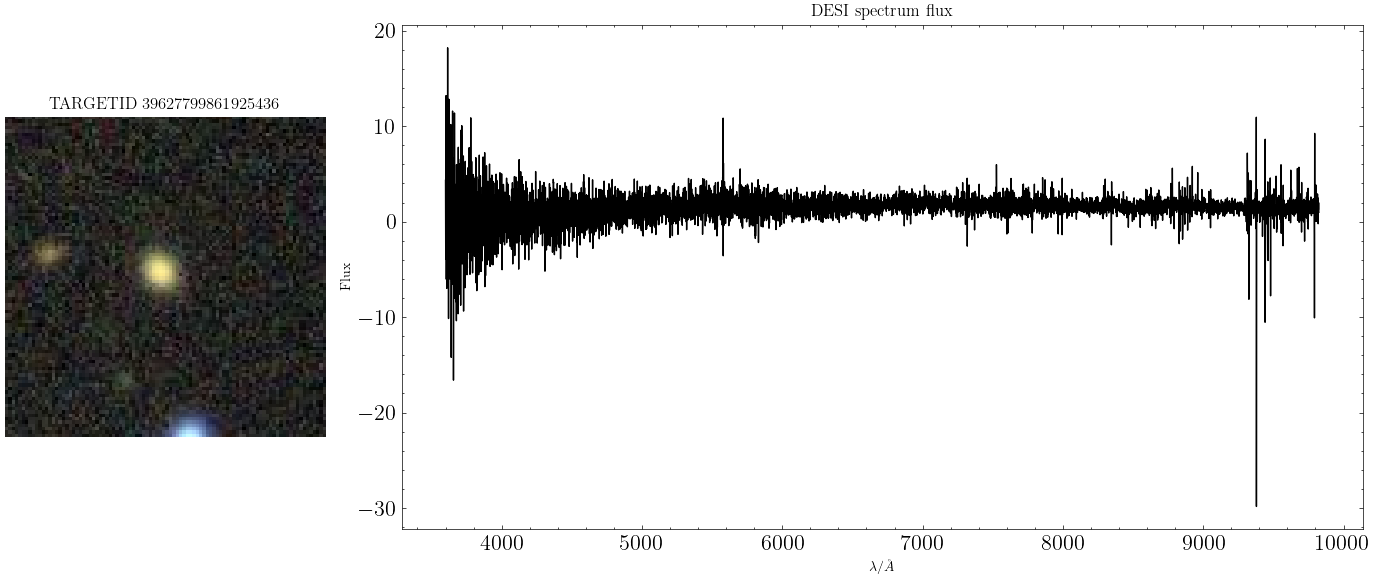

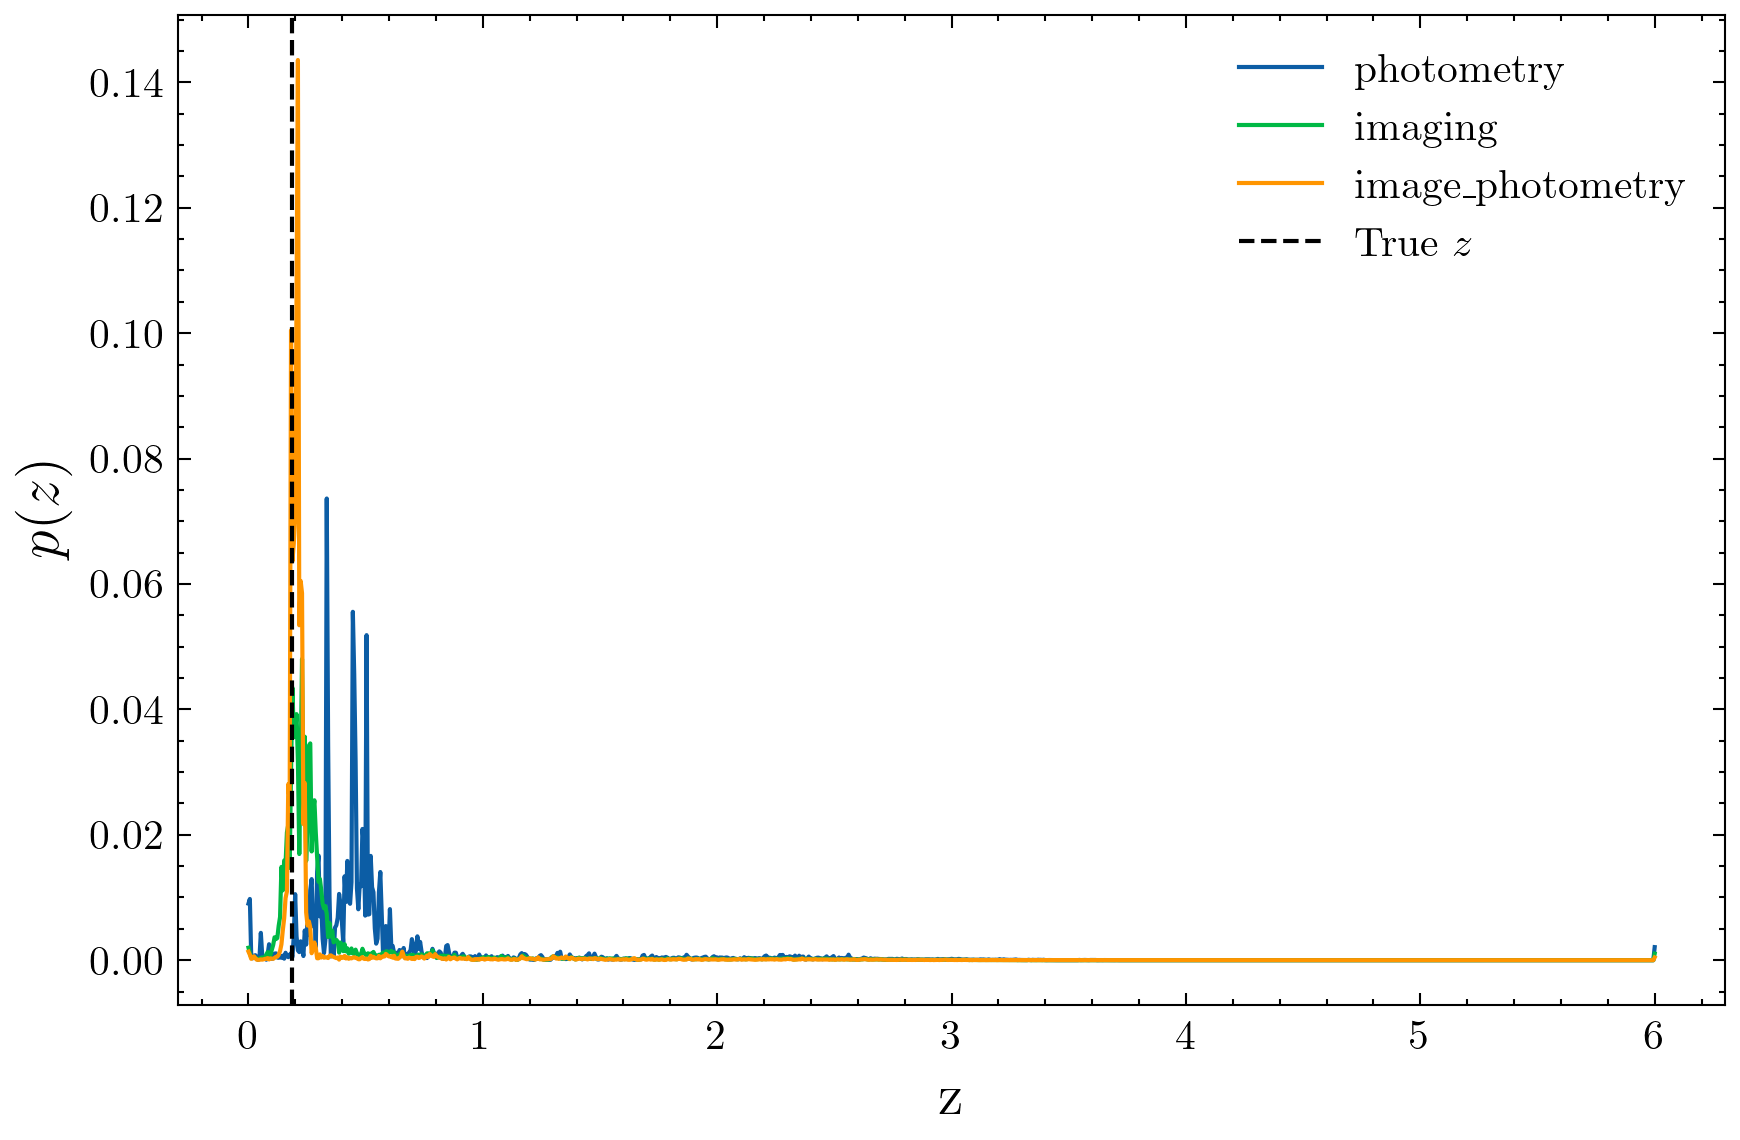

------------------------------------------------


<Table length=1>
     TARGETID        sSFR        LOG_MSTAR     legacysurvey_EBV   desi_Z  
      int64        float32        float64          float32       float32  
----------------- ---------- ----------------- ---------------- ----------
39627818002287849 -20.206602 12.02027702331543      0.033067755 0.48387292

Z                                    22.019682
Photometry                           59.330410
Imaging                              66.451065
Spectroscopy                         18.012392
Image + Photometry                   61.267120
Image + Spectrum                     18.020092
Image + Spectrum + Photometry        18.012348
Image + Spectrum + Photometry + Z    18.028507
ratio_p_ip                            0.968389
ratio_p_ip_rank                       2.000000
Name: 2558, dtype: float64

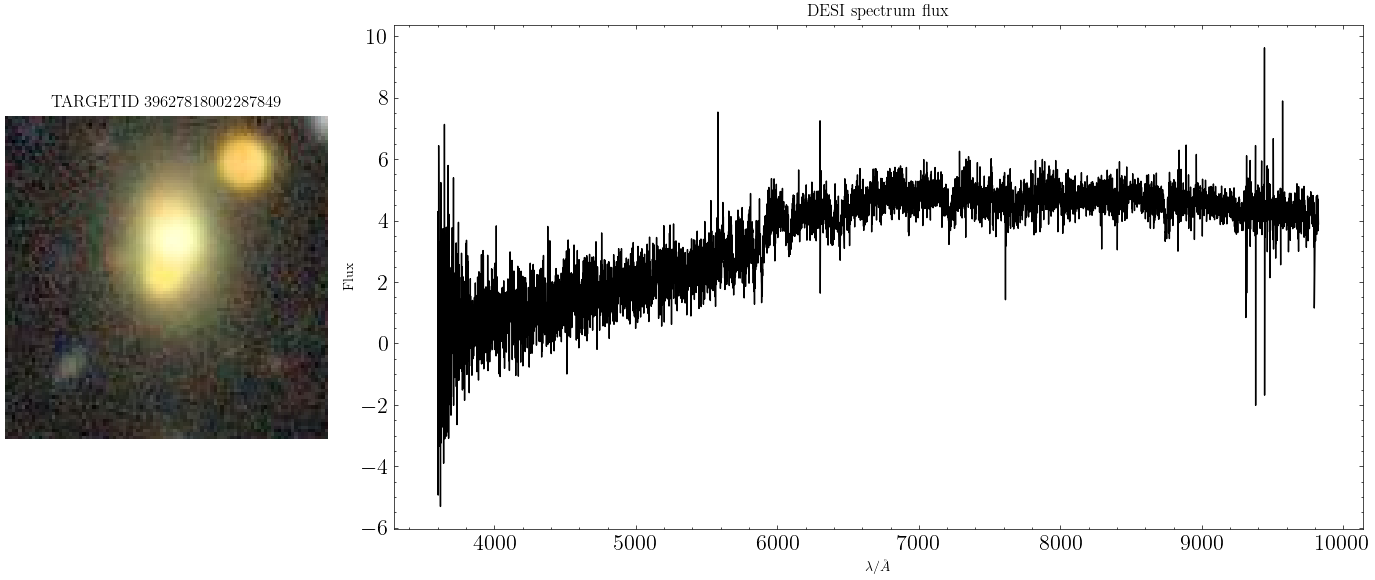

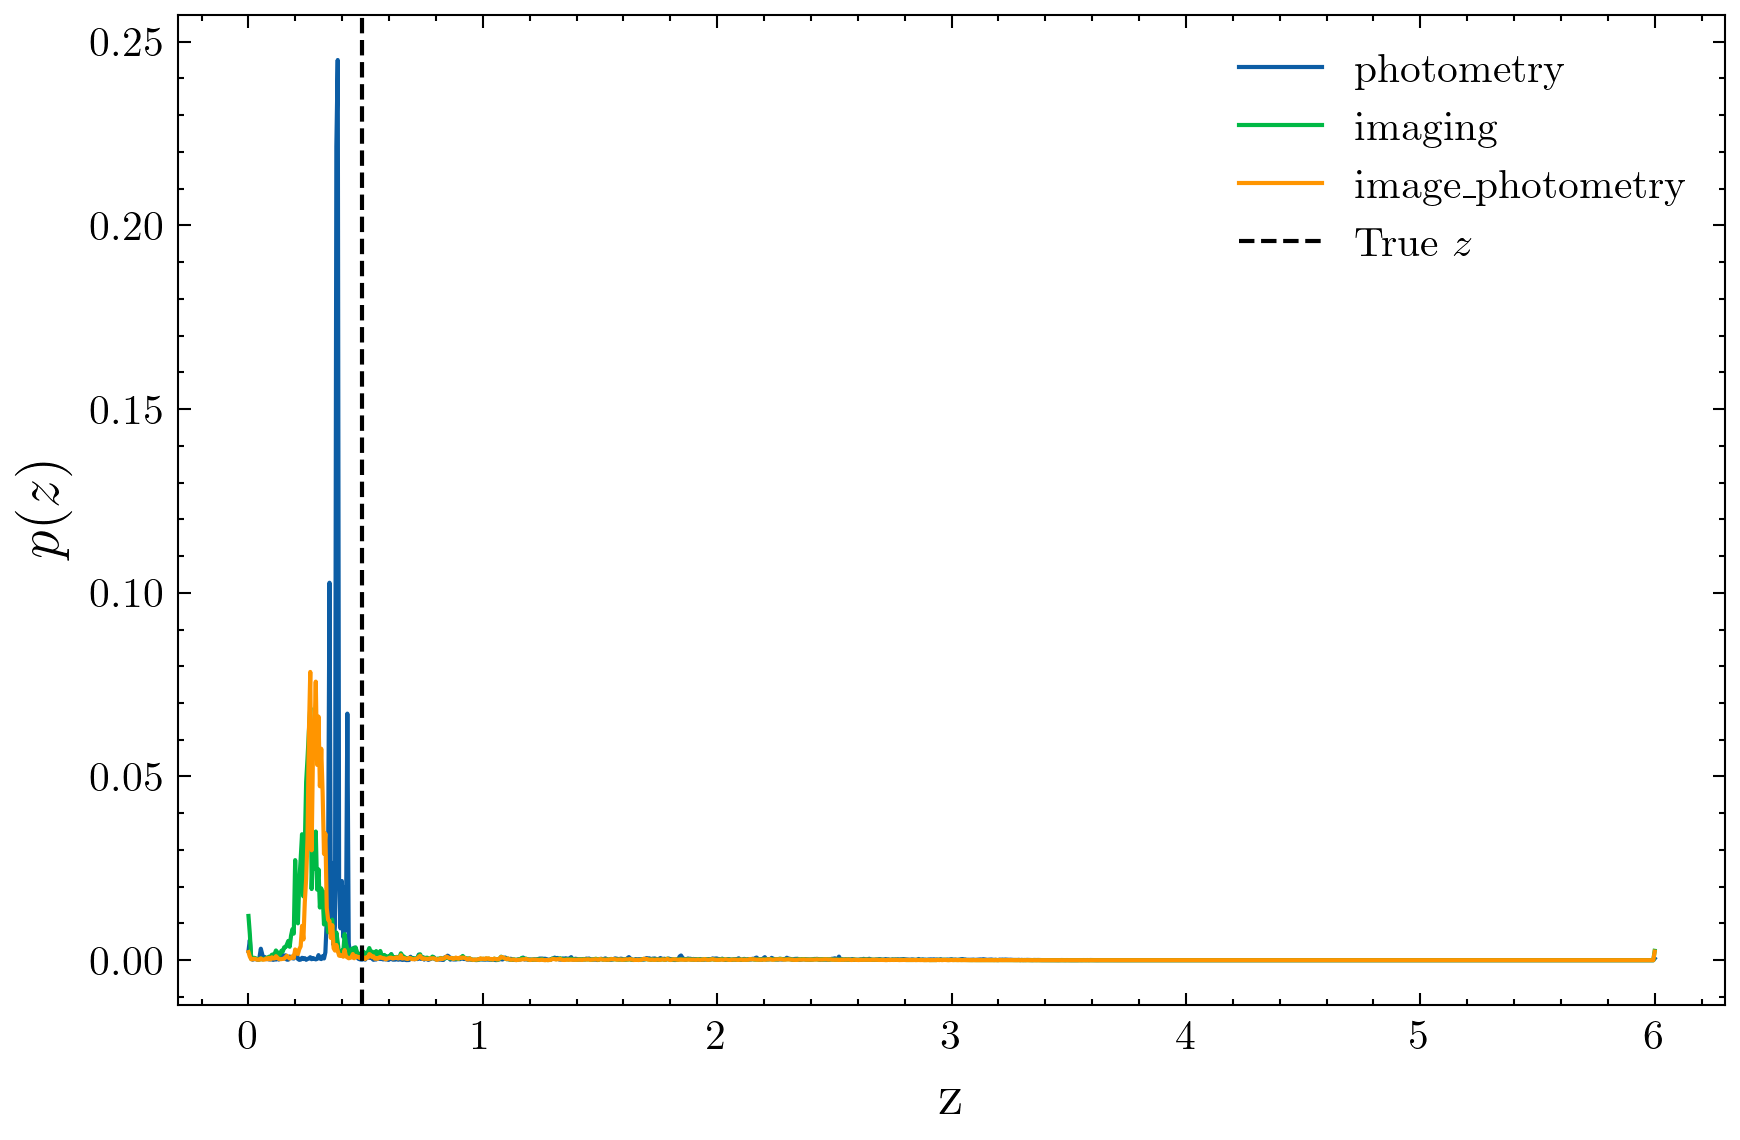

------------------------------------------------


<Table length=1>
     TARGETID        sSFR        LOG_MSTAR      legacysurvey_EBV   desi_Z  
      int64        float32        float64           float32       float32  
----------------- ---------- ------------------ ---------------- ----------
39627805905916522 -10.302712 10.870001792907715      0.029550878 0.35287133

Z                                    29.545900
Photometry                           51.296371
Imaging                              38.782532
Spectroscopy                         23.083525
Image + Photometry                   50.141621
Image + Spectrum                     23.061844
Image + Spectrum + Photometry        23.061367
Image + Spectrum + Photometry + Z    23.089649
ratio_p_ip                            1.023030
ratio_p_ip_rank                       3.000000
Name: 1840, dtype: float64

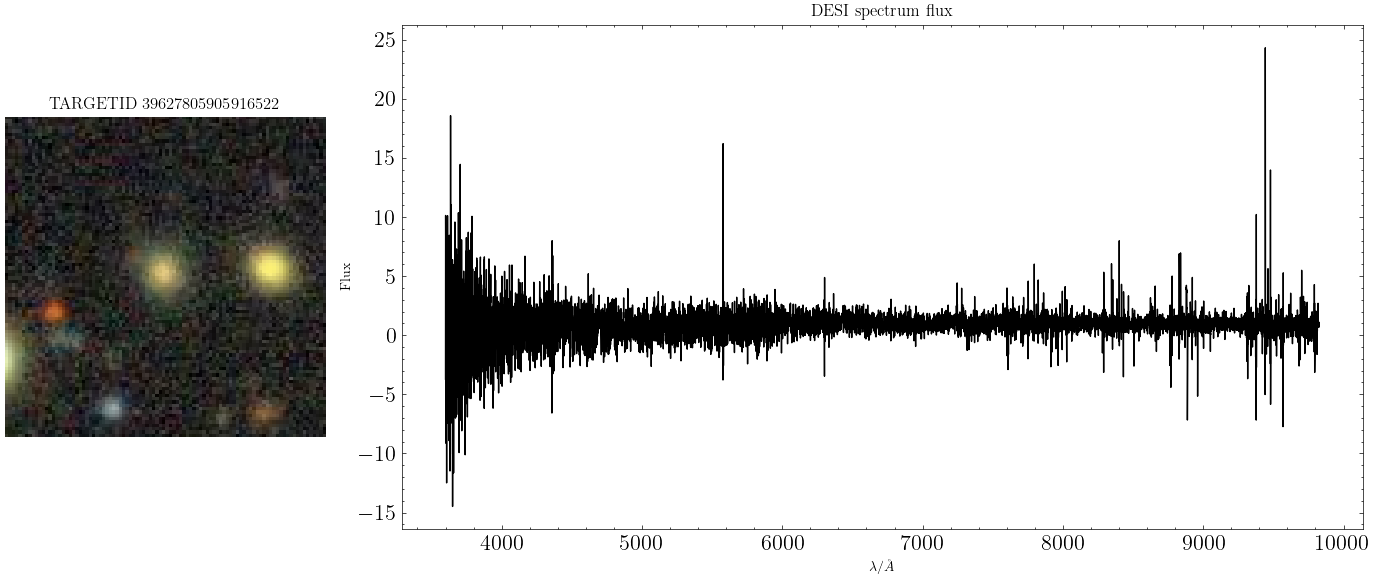

------------------------------------------------


<Table length=1>
     TARGETID        sSFR        LOG_MSTAR      legacysurvey_EBV   desi_Z  
      int64        float32        float64           float32       float32  
----------------- ---------- ------------------ ---------------- ----------
39627811954099323 -15.526229 10.536354064941406      0.028974293 0.30312386

Z                                    39.317993
Photometry                           46.863190
Imaging                              46.608627
Spectroscopy                         30.998268
Image + Photometry                   45.765343
Image + Spectrum                     30.706272
Image + Spectrum + Photometry        31.017723
Image + Spectrum + Photometry + Z    30.222702
ratio_p_ip                            1.023989
ratio_p_ip_rank                       4.000000
Name: 2209, dtype: float64

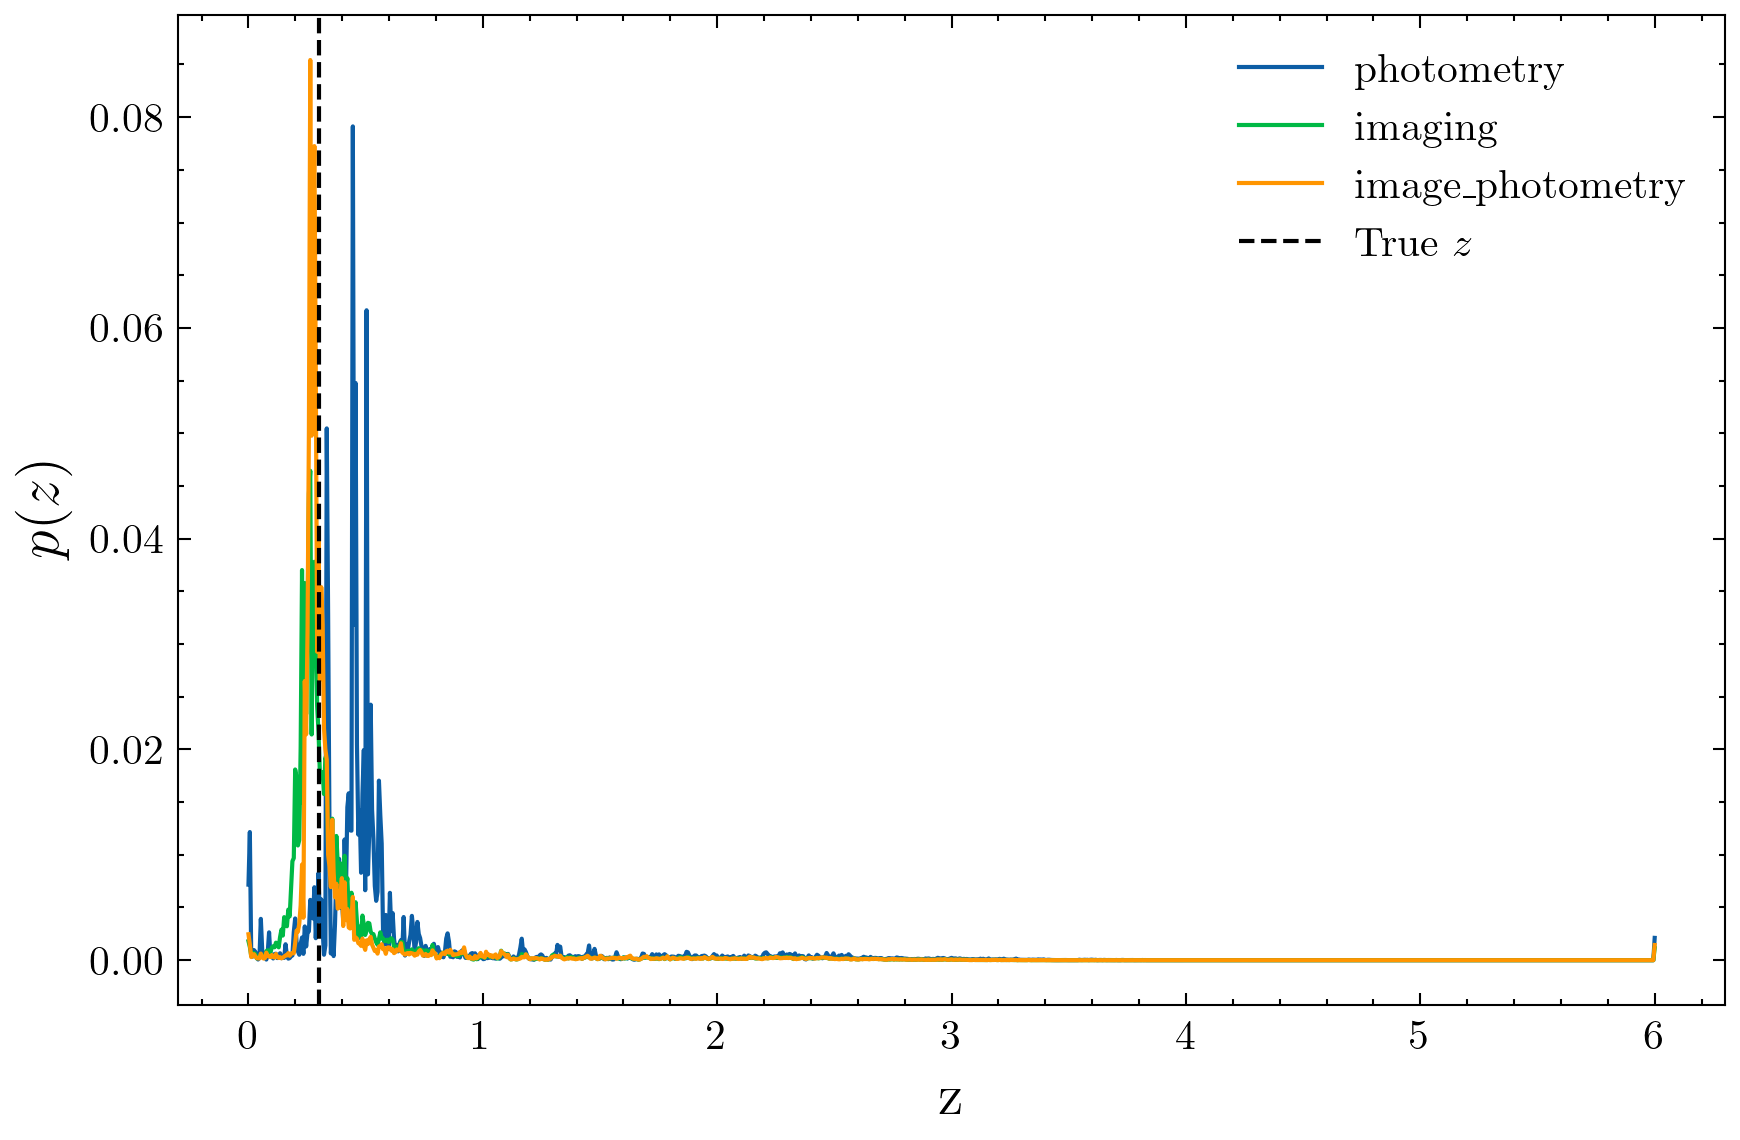

------------------------------------------------


<Table length=1>
     TARGETID        sSFR        LOG_MSTAR      legacysurvey_EBV   desi_Z 
      int64        float32        float64           float32       float32 
----------------- ---------- ------------------ ---------------- ---------
39627818002289475 -7.9681096 11.245622634887695      0.031435087 0.5203181

Z                                    69.511490
Photometry                           76.835693
Imaging                              72.442207
Spectroscopy                         63.308231
Image + Photometry                   74.333969
Image + Spectrum                     63.821537
Image + Spectrum + Photometry        63.300793
Image + Spectrum + Photometry + Z    62.344292
ratio_p_ip                            1.033655
ratio_p_ip_rank                       5.000000
Name: 2583, dtype: float64

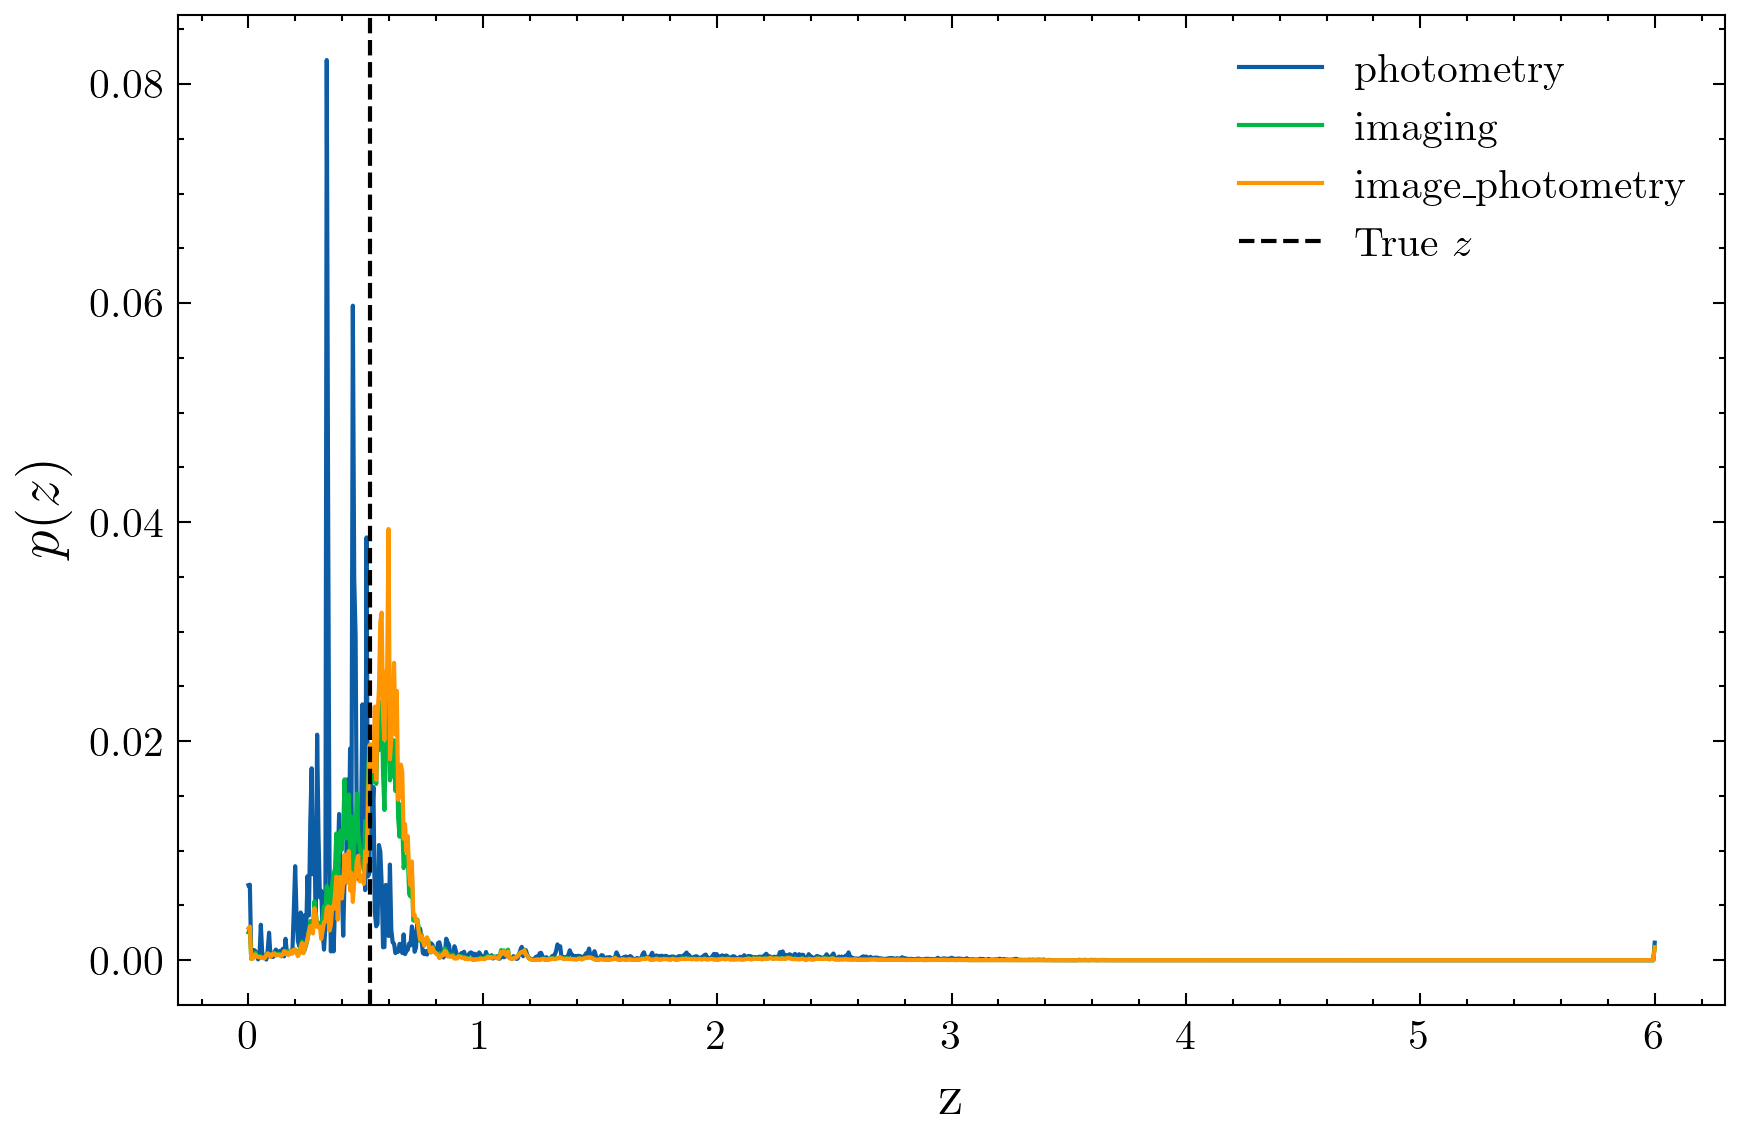

------------------------------------------------


<Table length=1>
     TARGETID        sSFR       LOG_MSTAR      legacysurvey_EBV   desi_Z  
      int64        float32       float64           float32       float32  
----------------- --------- ------------------ ---------------- ----------
39627781725751561 -9.913074 10.152250289916992       0.02567316 0.27686924

Z                                    67.097610
Photometry                           65.038994
Imaging                              59.948303
Spectroscopy                         50.034103
Image + Photometry                   62.472328
Image + Spectrum                     50.047863
Image + Spectrum + Photometry        50.052208
Image + Spectrum + Photometry + Z    50.034348
ratio_p_ip                            1.041085
ratio_p_ip_rank                       6.000000
Name: 3687, dtype: float64

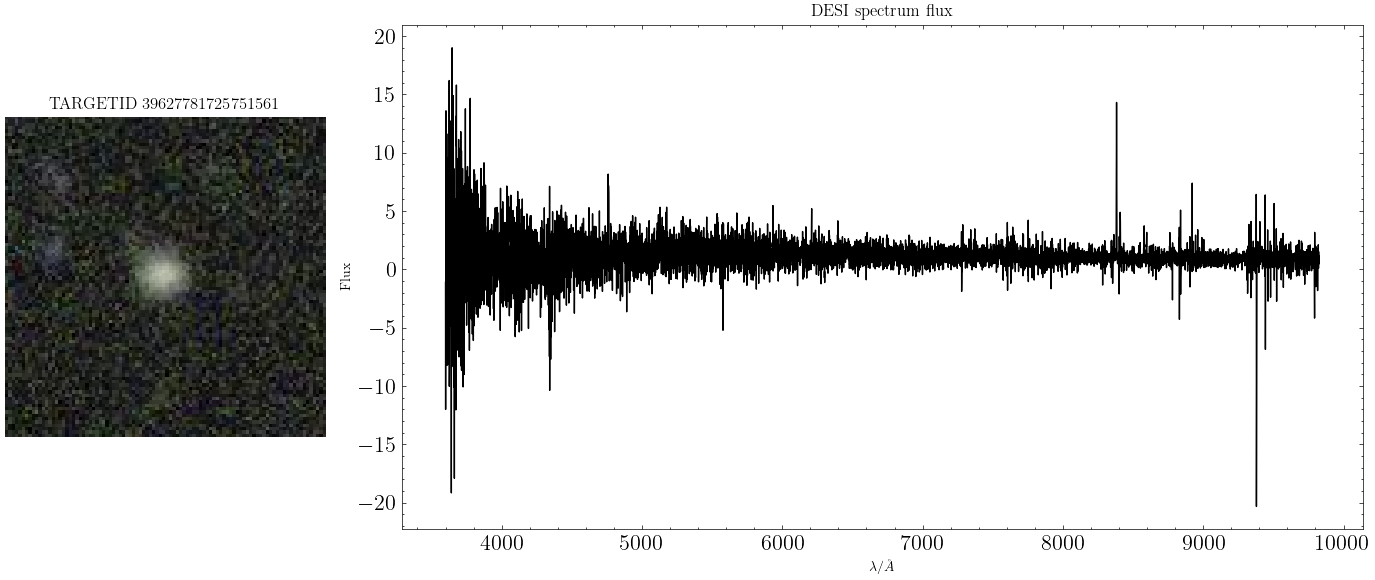

------------------------------------------------


<Table length=1>
     TARGETID        sSFR       LOG_MSTAR     legacysurvey_EBV   desi_Z 
      int64        float32       float64          float32       float32 
----------------- --------- ----------------- ---------------- ---------
39627799861925153 -8.664843 9.405210494995117       0.02496316 0.2058584

Z                                    45.880348
Photometry                           59.934719
Imaging                              60.969215
Spectroscopy                         32.072285
Image + Photometry                   56.417442
Image + Spectrum                     32.065998
Image + Spectrum + Photometry        32.051506
Image + Spectrum + Photometry + Z    32.064274
ratio_p_ip                            1.062344
ratio_p_ip_rank                       7.000000
Name: 1379, dtype: float64

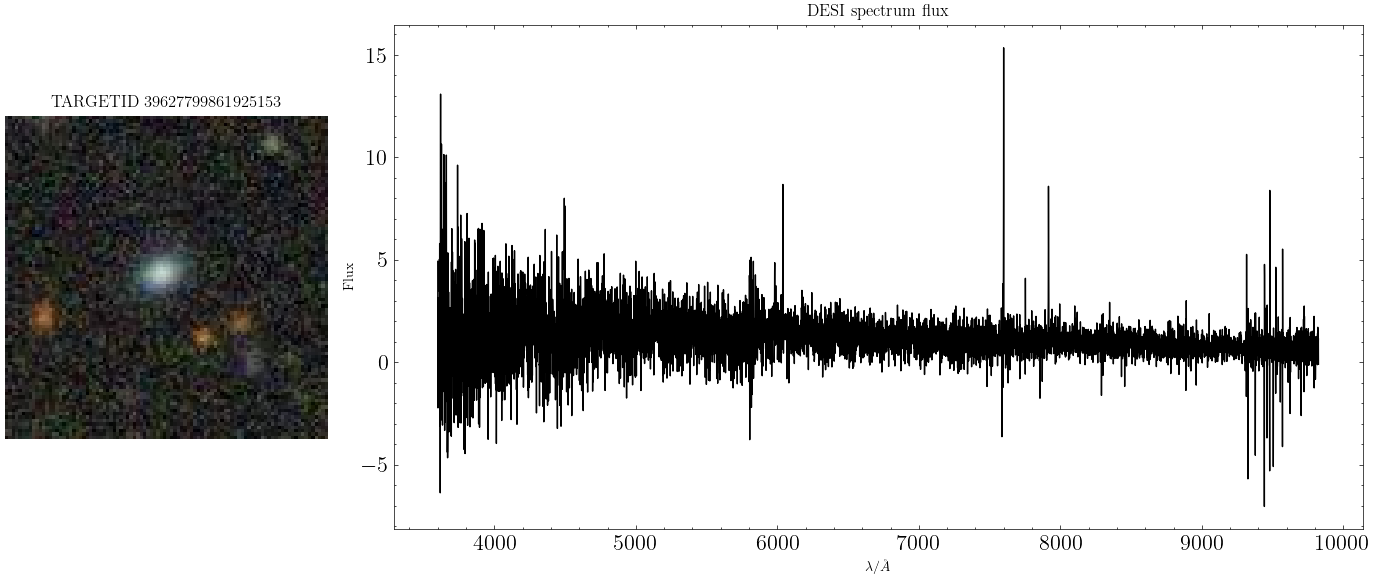

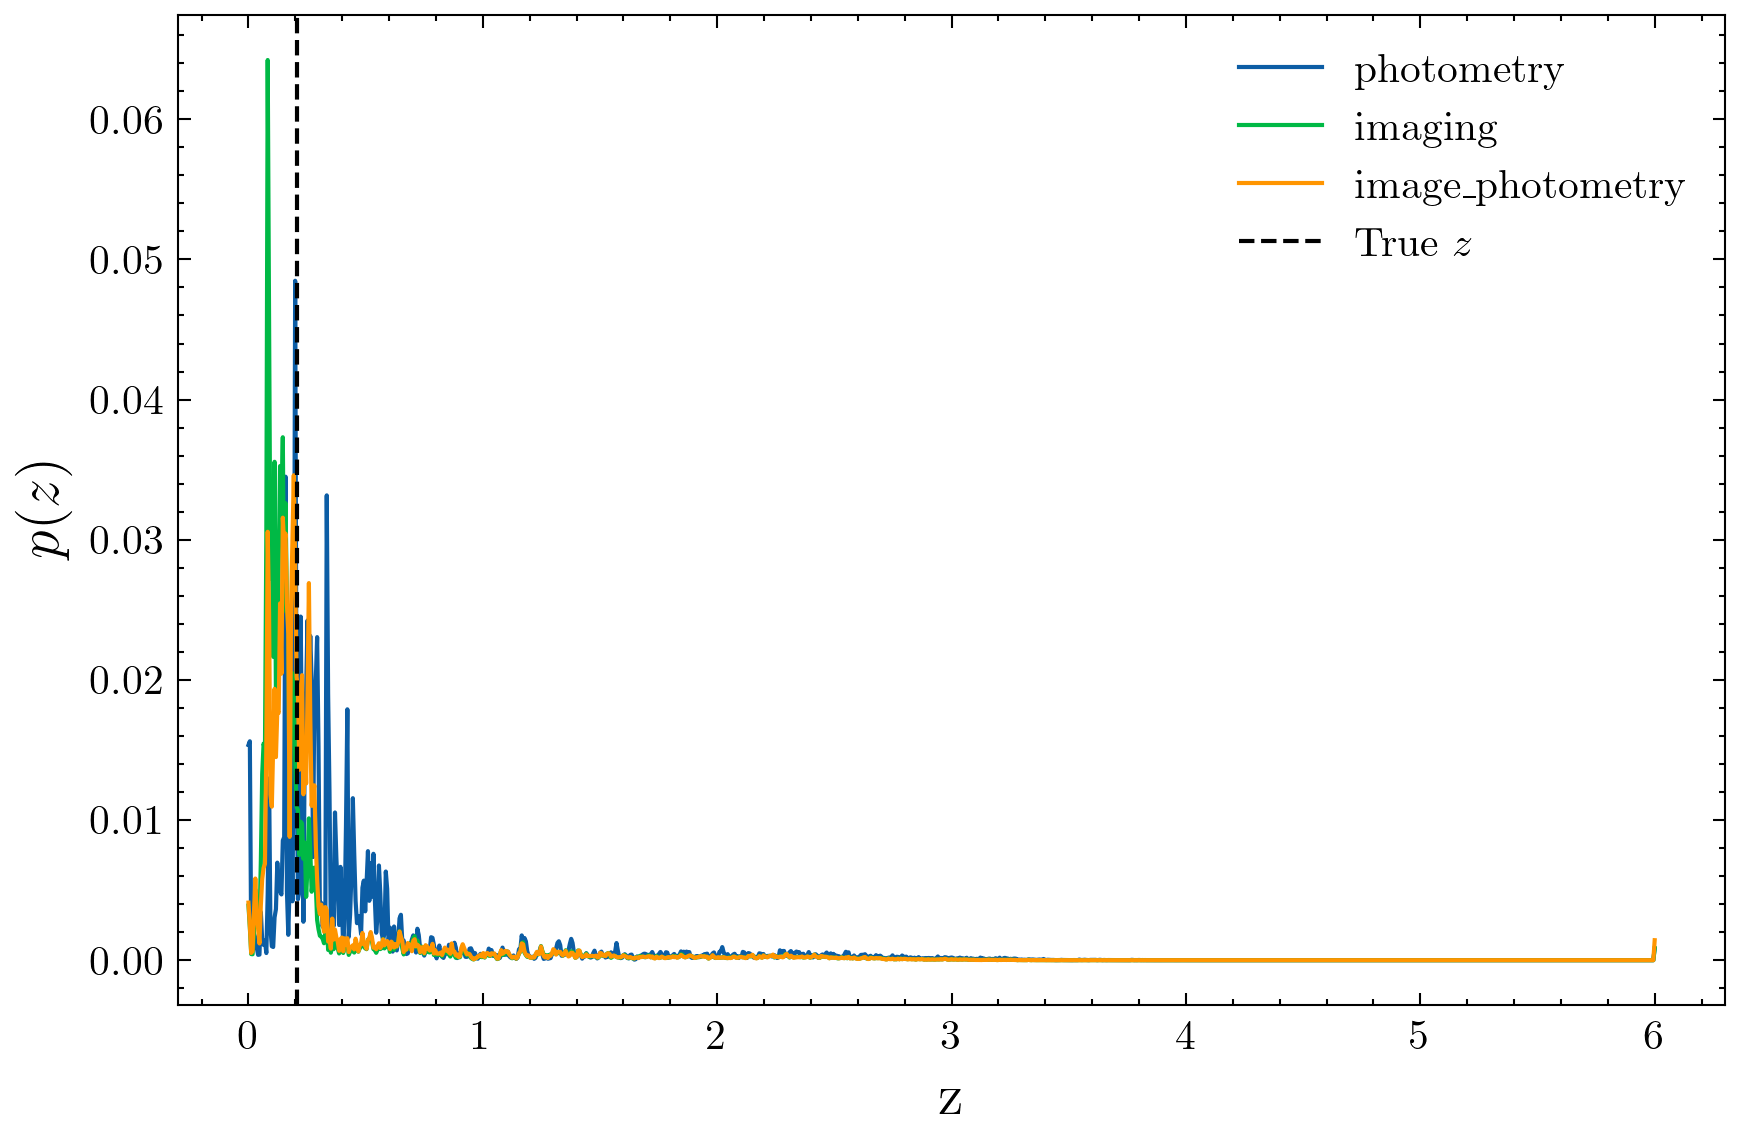

------------------------------------------------


<Table length=1>
     TARGETID        sSFR        LOG_MSTAR     legacysurvey_EBV   desi_Z  
      int64        float32        float64          float32       float32  
----------------- ---------- ----------------- ---------------- ----------
39627818010677601 -10.446698 10.18195915222168       0.02290314 0.24432579

Z                                    44.048630
Photometry                           51.045898
Imaging                              49.060760
Spectroscopy                         41.022724
Image + Photometry                   47.708958
Image + Spectrum                     41.004333
Image + Spectrum + Photometry        41.003181
Image + Spectrum + Photometry + Z    40.994858
ratio_p_ip                            1.069944
ratio_p_ip_rank                       8.000000
Name: 2748, dtype: float64

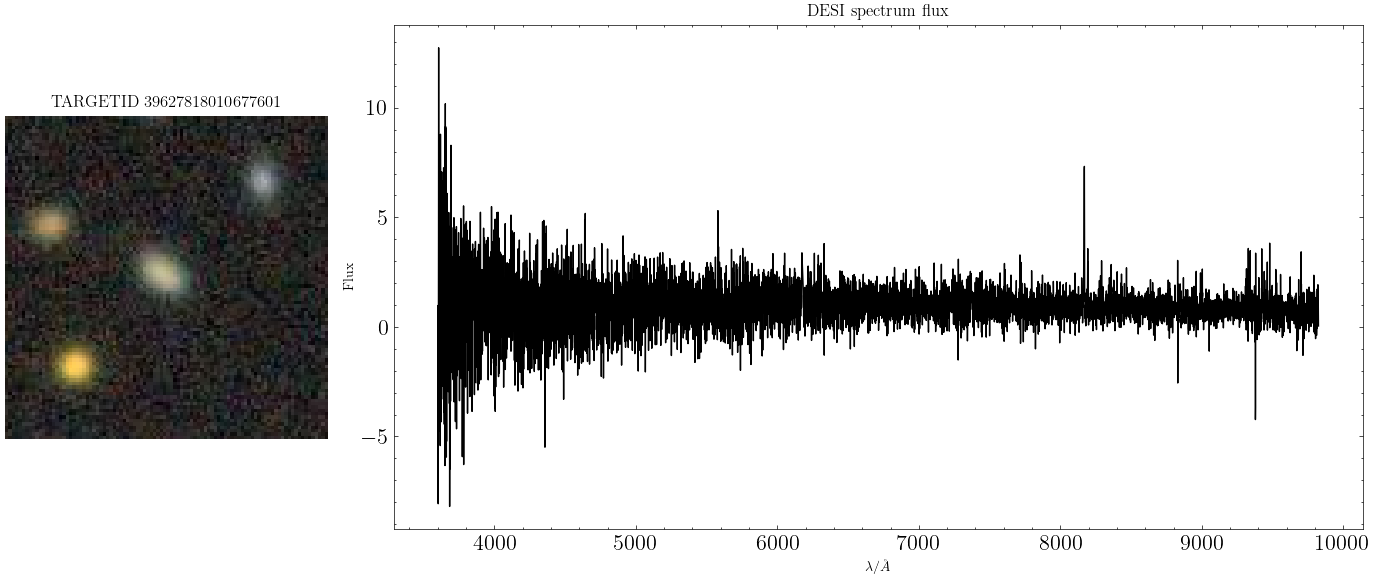

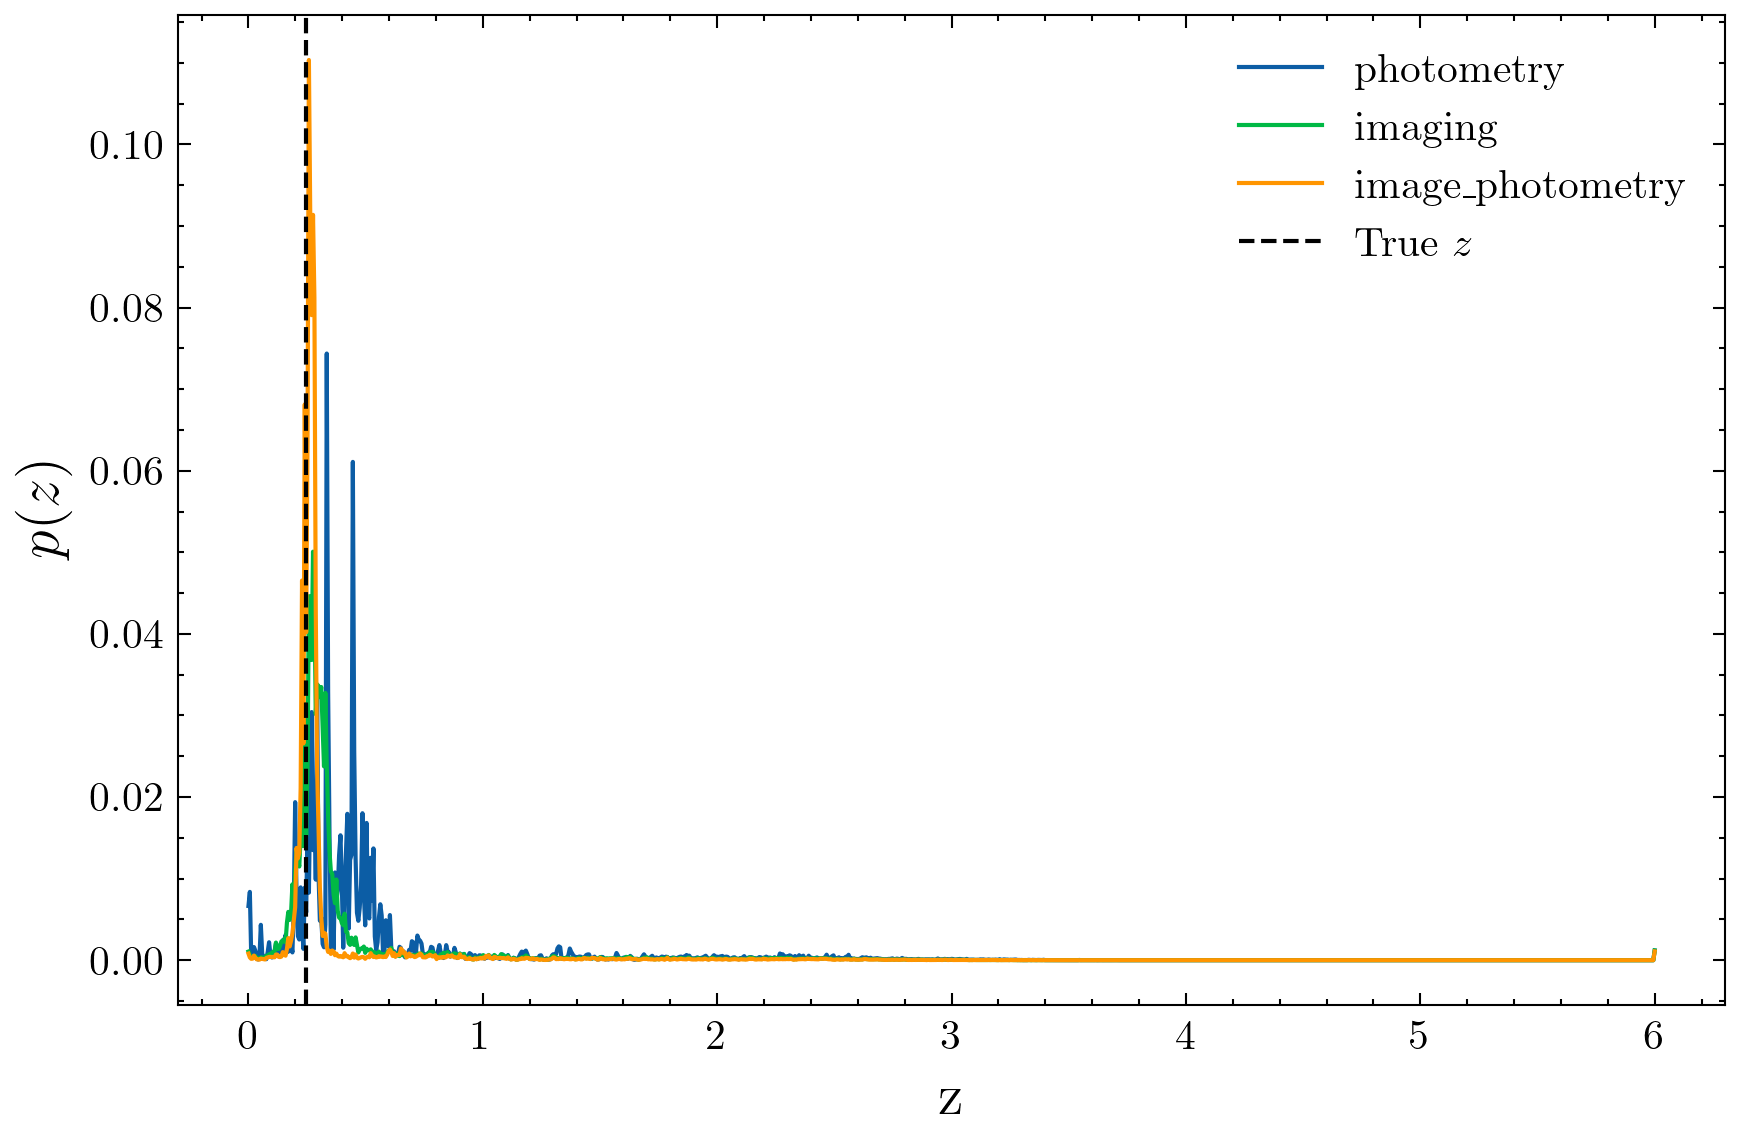

------------------------------------------------


<Table length=1>
     TARGETID        sSFR      LOG_MSTAR     legacysurvey_EBV   desi_Z  
      int64        float32      float64          float32       float32  
----------------- --------- ---------------- ---------------- ----------
39627799840952900 -9.180608 9.98682975769043      0.022774788 0.20729691

Z                                    55.133148
Photometry                           63.548557
Imaging                              61.471600
Spectroscopy                         43.044731
Image + Photometry                   59.098068
Image + Spectrum                     43.060123
Image + Spectrum + Photometry        43.042385
Image + Spectrum + Photometry + Z    43.098949
ratio_p_ip                            1.075307
ratio_p_ip_rank                       9.000000
Name: 1223, dtype: float64

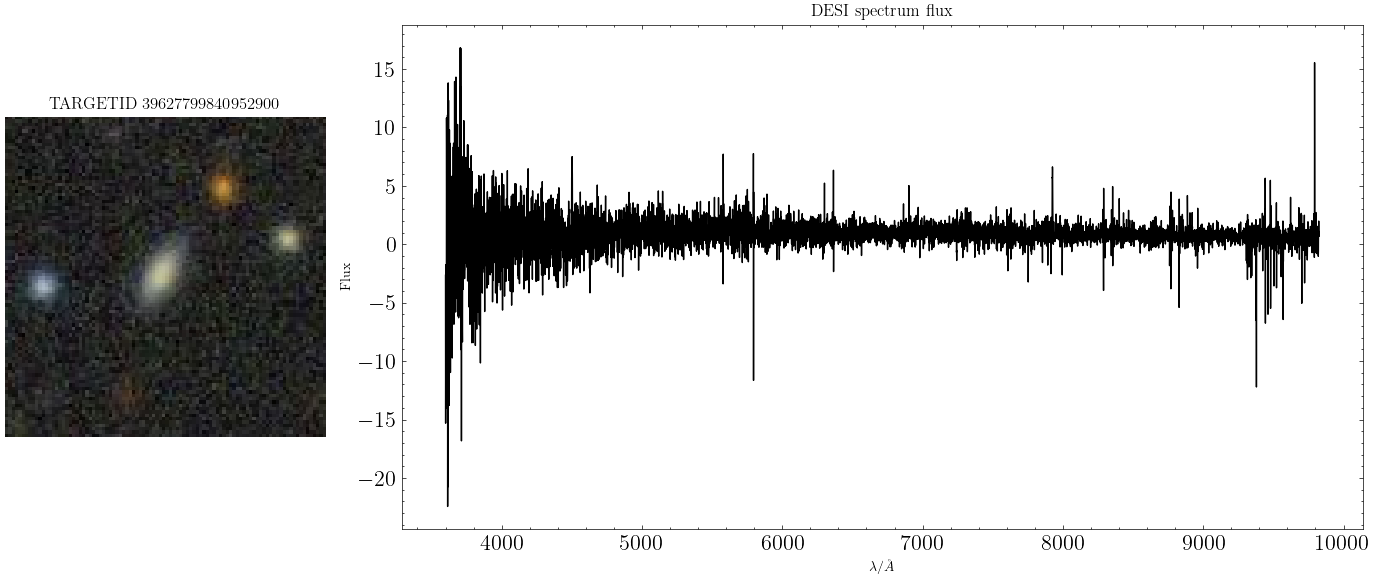

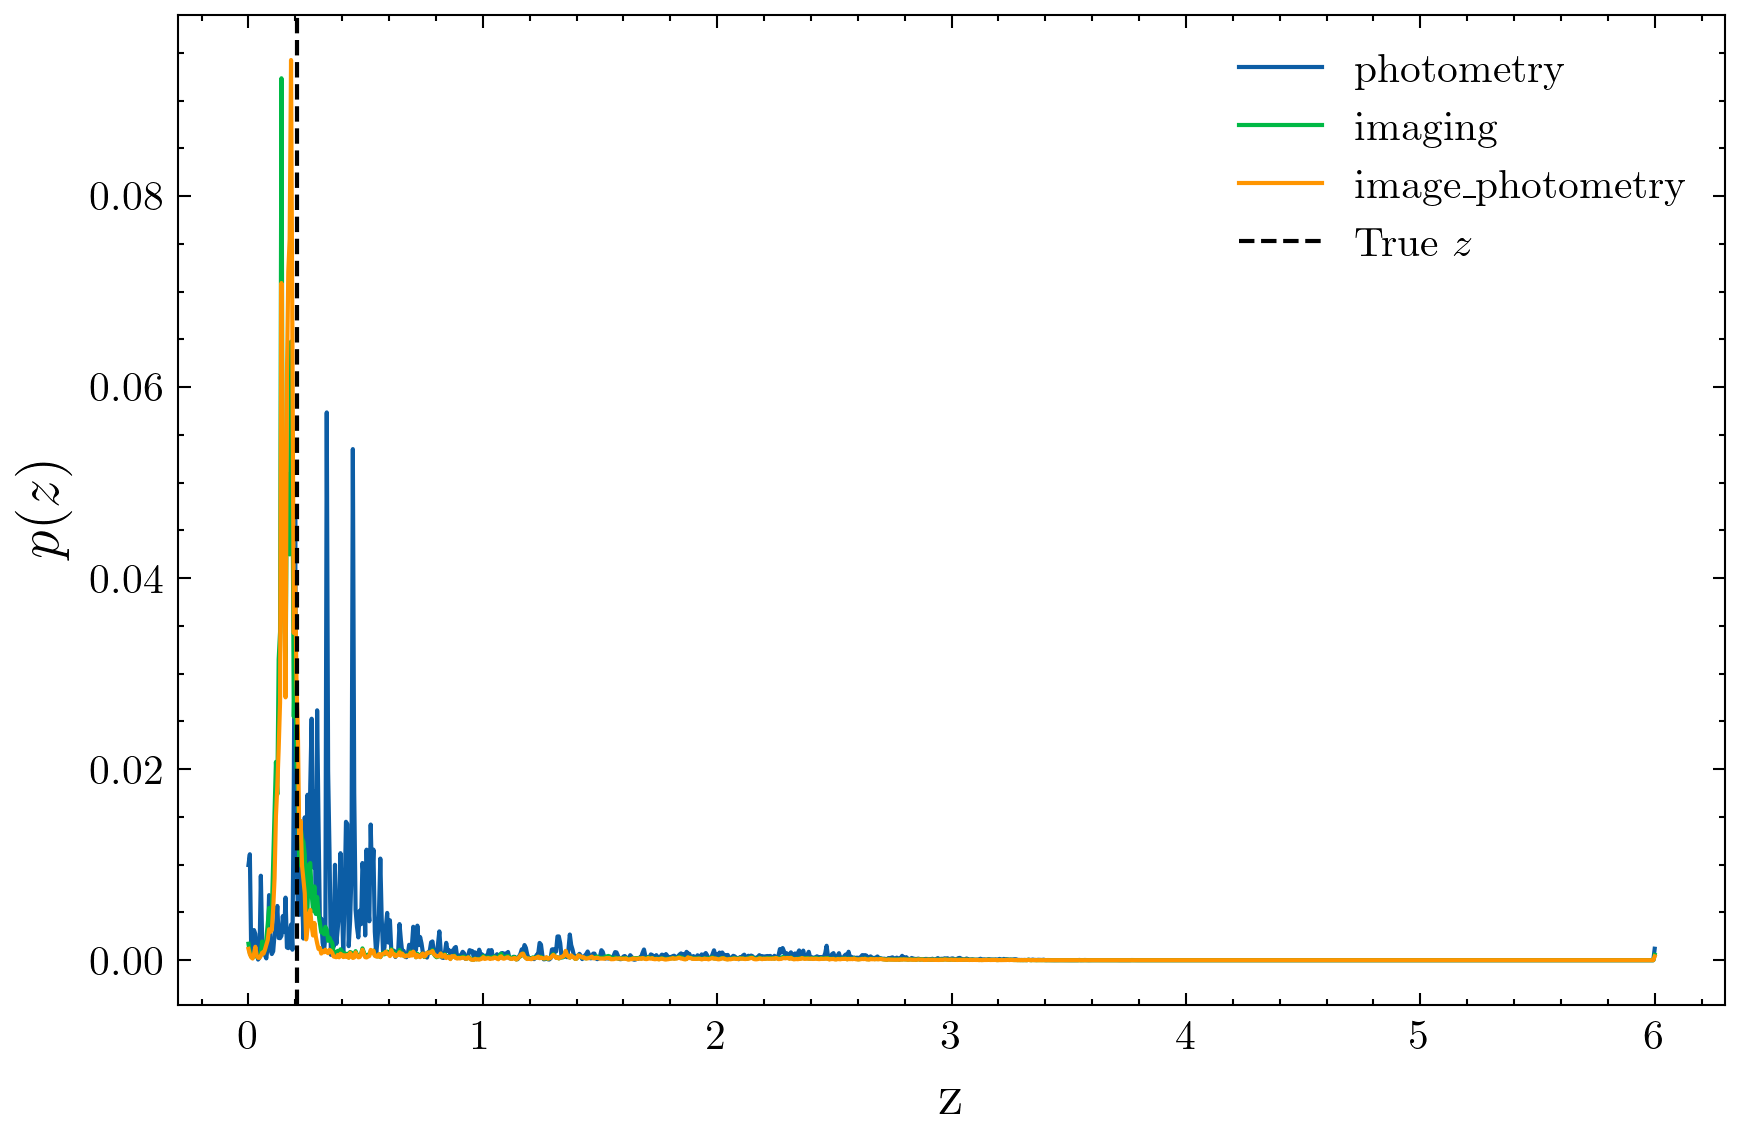

------------------------------------------------


<Table length=1>
     TARGETID         sSFR        LOG_MSTAR      legacysurvey_EBV    desi_Z  
      int64         float32        float64           float32        float32  
----------------- ----------- ------------------ ---------------- -----------
39627805910108079 -10.7913885 10.084169387817383       0.02973312 0.020665083

Z                                     99.608475
Photometry                           104.760757
Imaging                               95.713882
Spectroscopy                          92.014549
Image + Photometry                    95.483131
Image + Spectrum                      92.015182
Image + Spectrum + Photometry         92.014946
Image + Spectrum + Photometry + Z     92.012955
ratio_p_ip                             1.097165
ratio_p_ip_rank                       10.000000
Name: 1874, dtype: float64

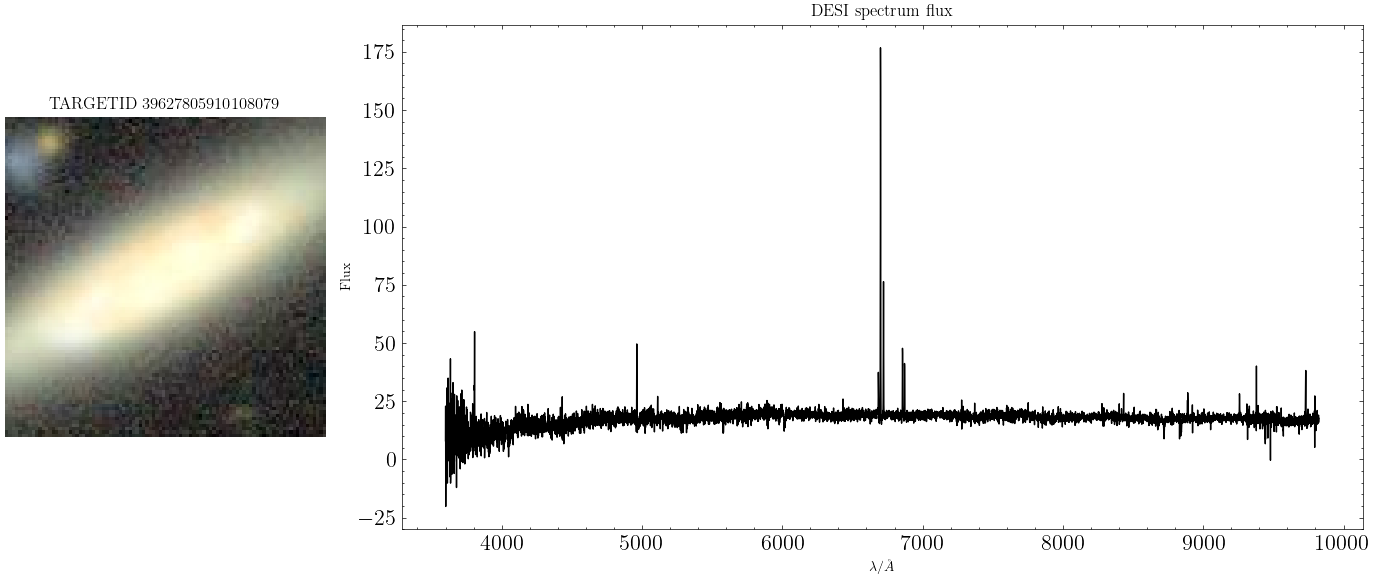

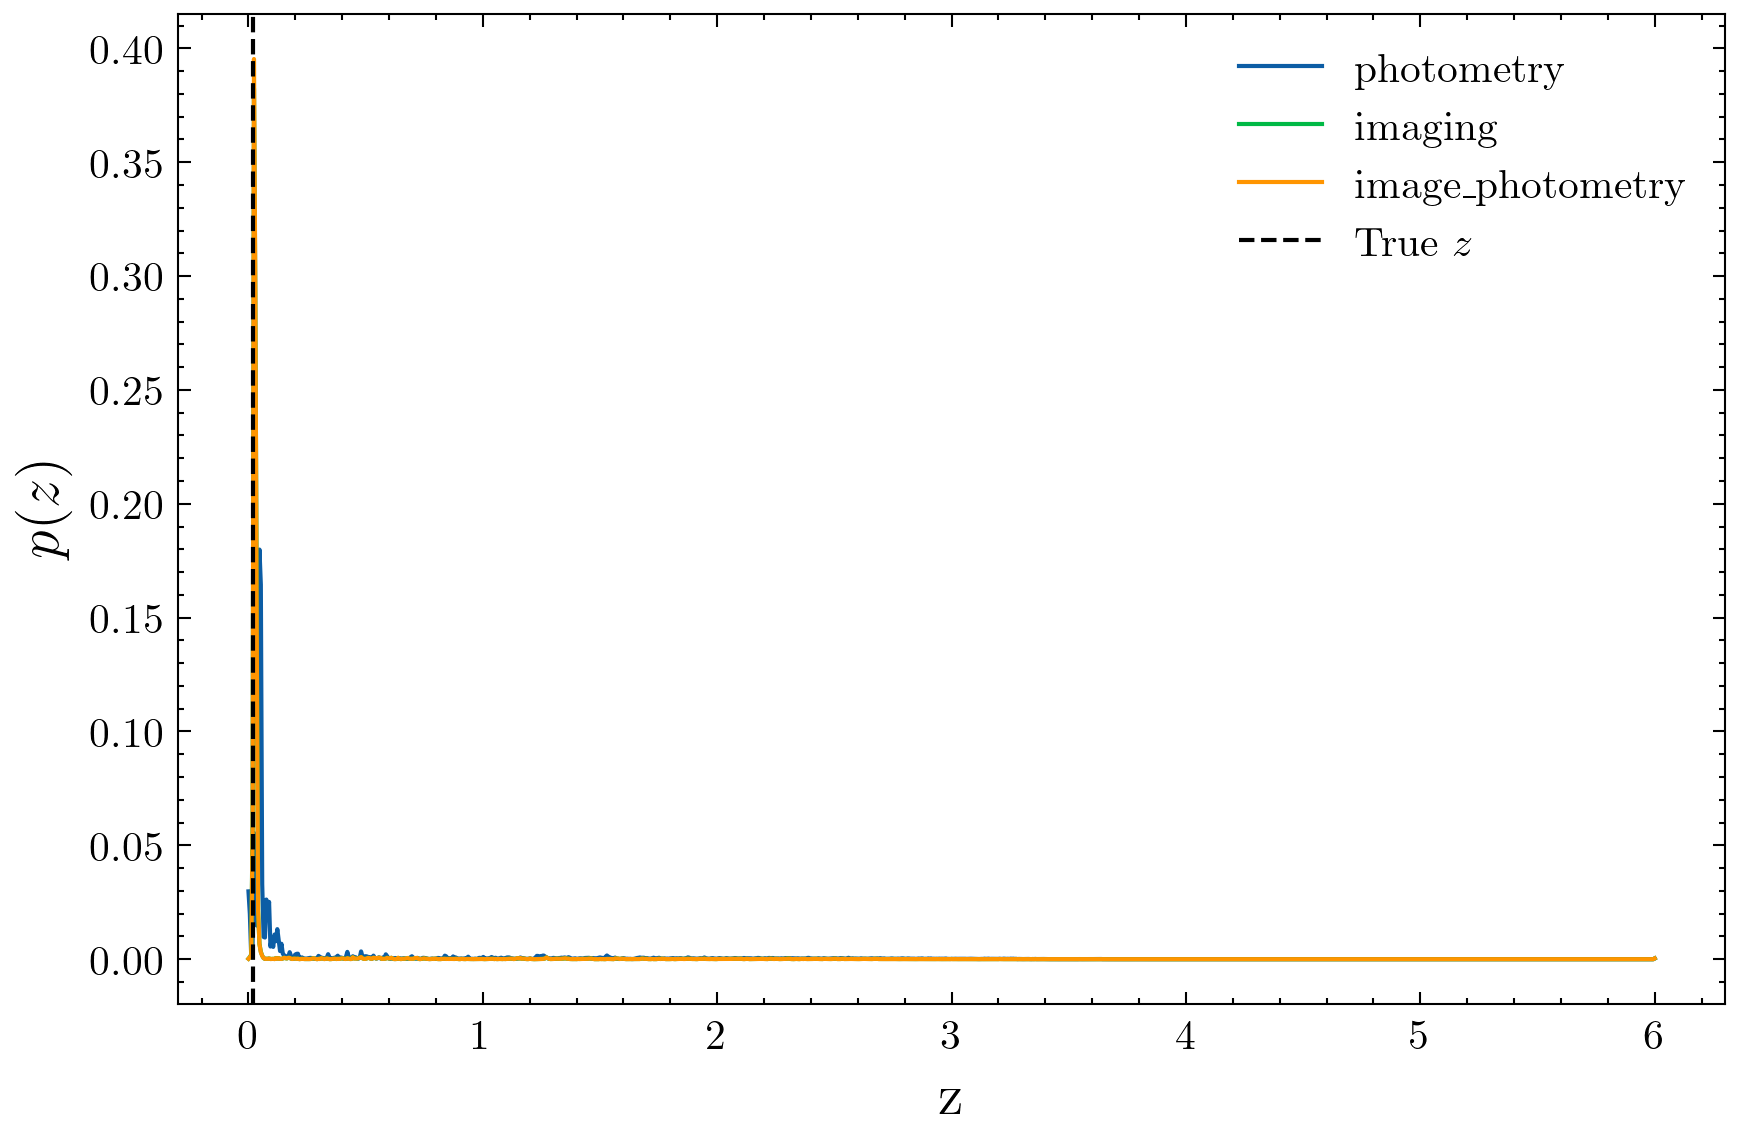

------------------------------------------------


<Table length=1>
     TARGETID        sSFR       LOG_MSTAR      legacysurvey_EBV   desi_Z 
      int64        float32       float64           float32       float32 
----------------- --------- ------------------ ---------------- ---------
39627799853533045 -8.895656 11.200061798095703      0.026204681 0.5414805

Z                                    72.213936
Photometry                           75.477043
Imaging                              54.200989
Spectroscopy                         65.436127
Image + Photometry                   68.338409
Image + Spectrum                     64.794342
Image + Spectrum + Photometry        65.602020
Image + Spectrum + Photometry + Z    64.502777
ratio_p_ip                            1.104460
ratio_p_ip_rank                      11.000000
Name: 1296, dtype: float64

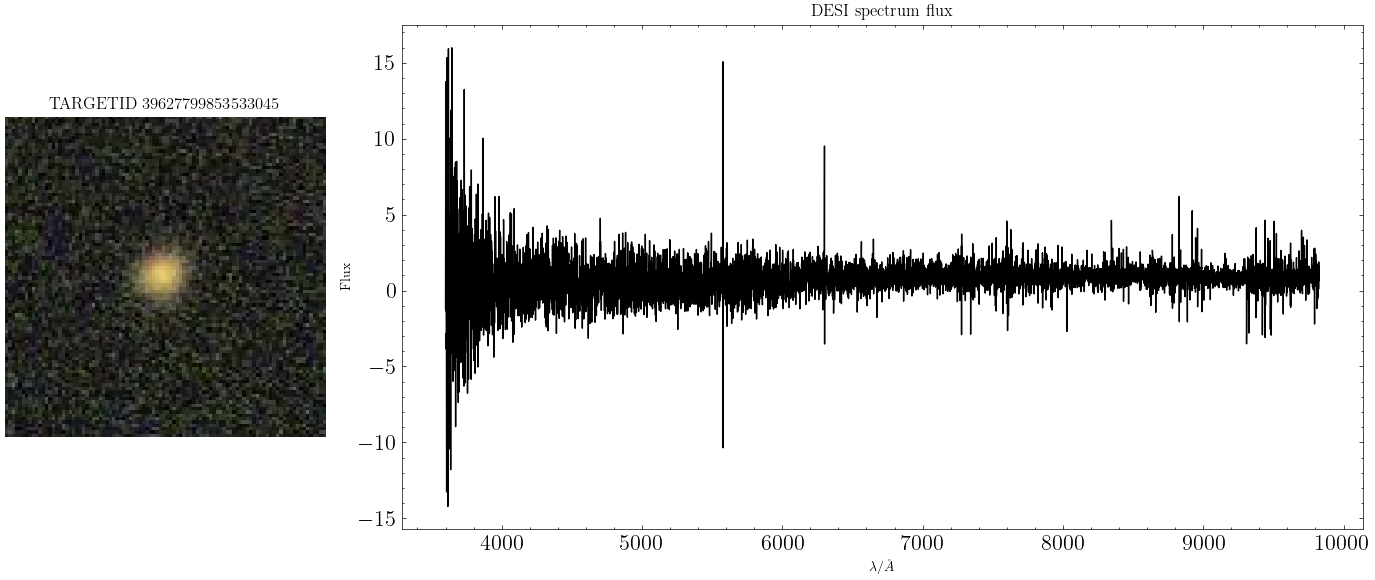

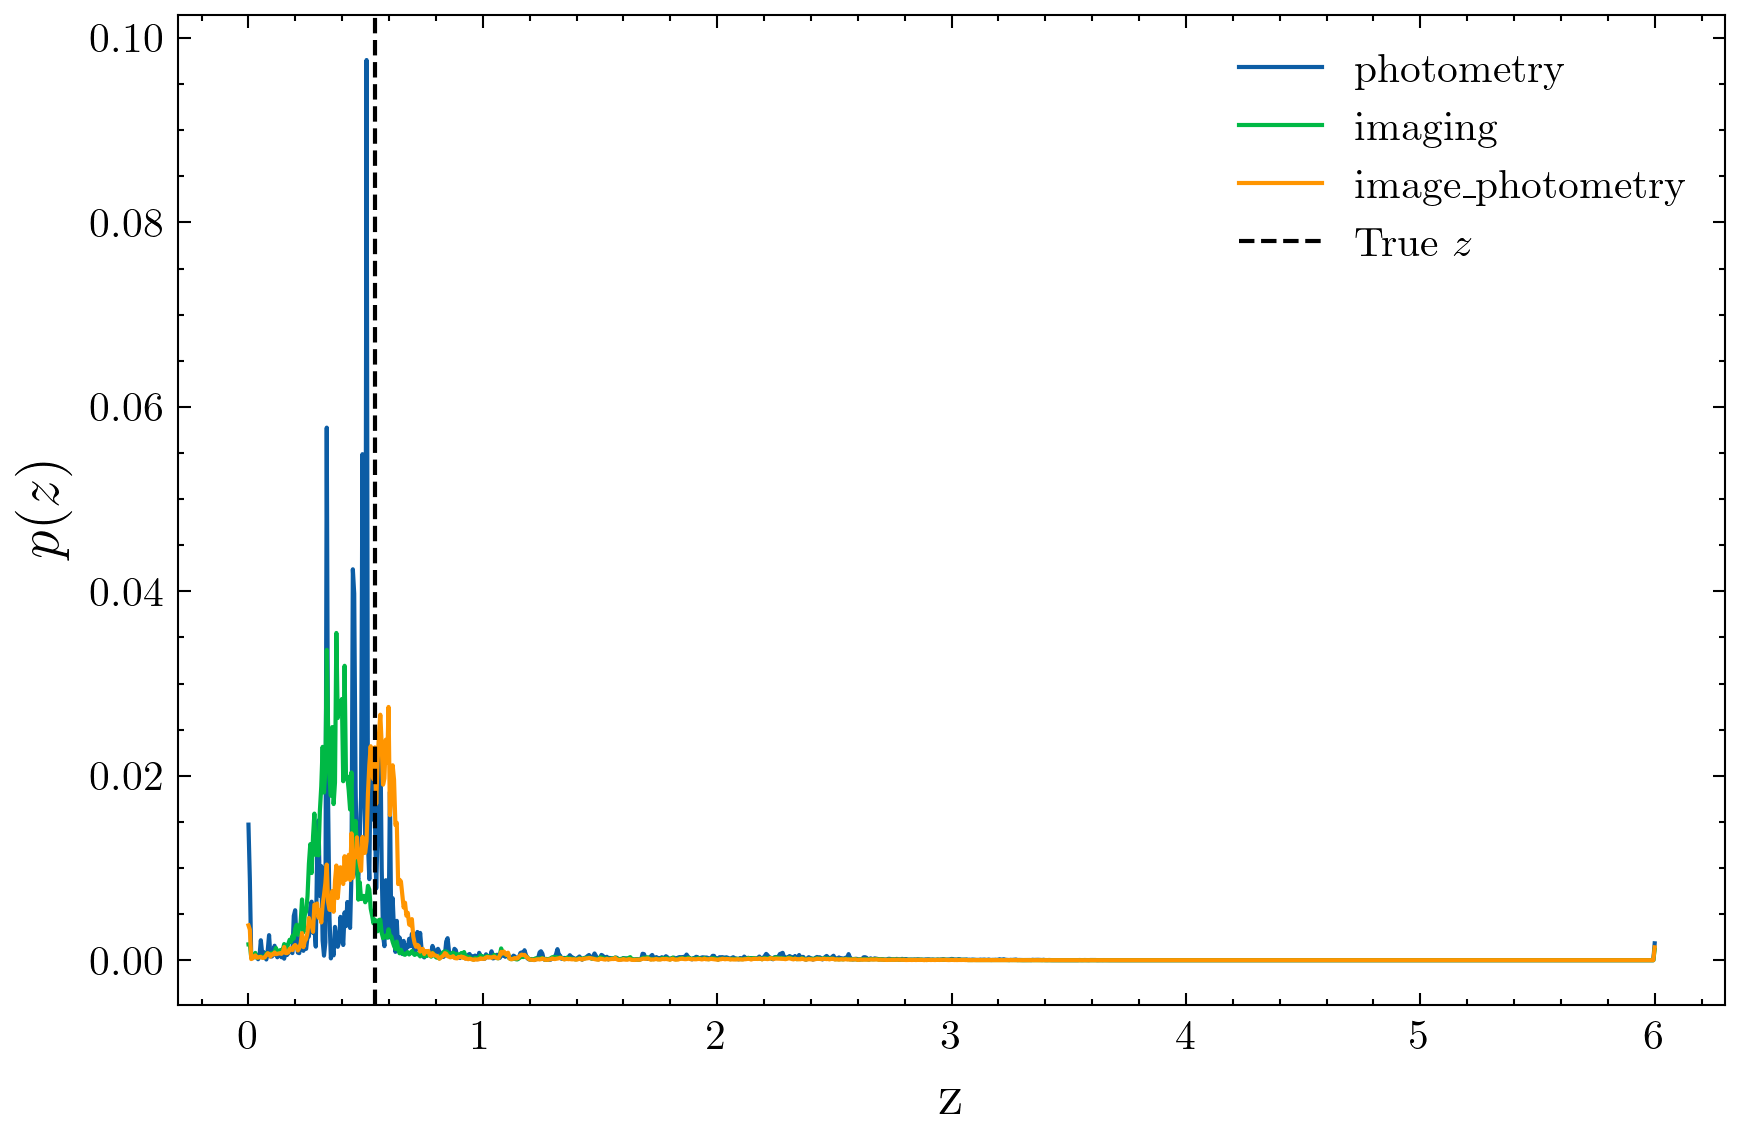

------------------------------------------------


<Table length=1>
     TARGETID        sSFR        LOG_MSTAR      legacysurvey_EBV   desi_Z 
      int64        float32        float64           float32       float32 
----------------- ---------- ------------------ ---------------- ---------
39627799861923648 -10.243376 10.785386085510254       0.02481197 0.2643941

Z                                    23.162350
Photometry                           80.901611
Imaging                              63.560654
Spectroscopy                         15.122217
Image + Photometry                   72.936775
Image + Spectrum                     15.258438
Image + Spectrum + Photometry        15.142086
Image + Spectrum + Photometry + Z    15.052828
ratio_p_ip                            1.109202
ratio_p_ip_rank                      12.000000
Name: 1360, dtype: float64

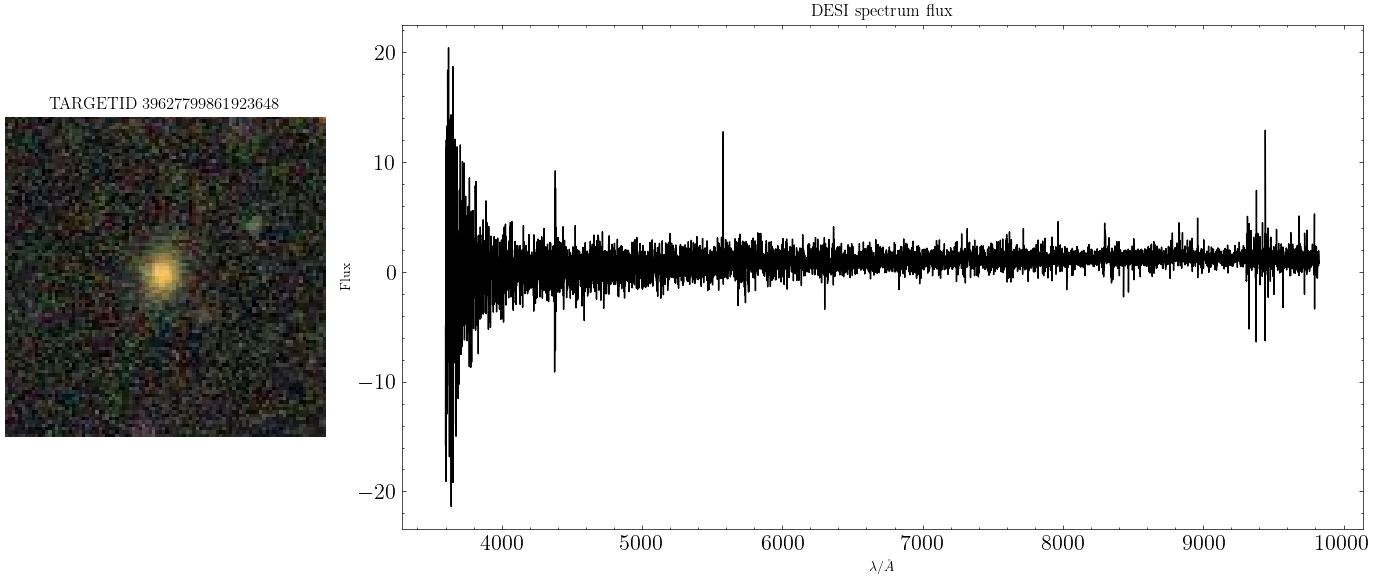

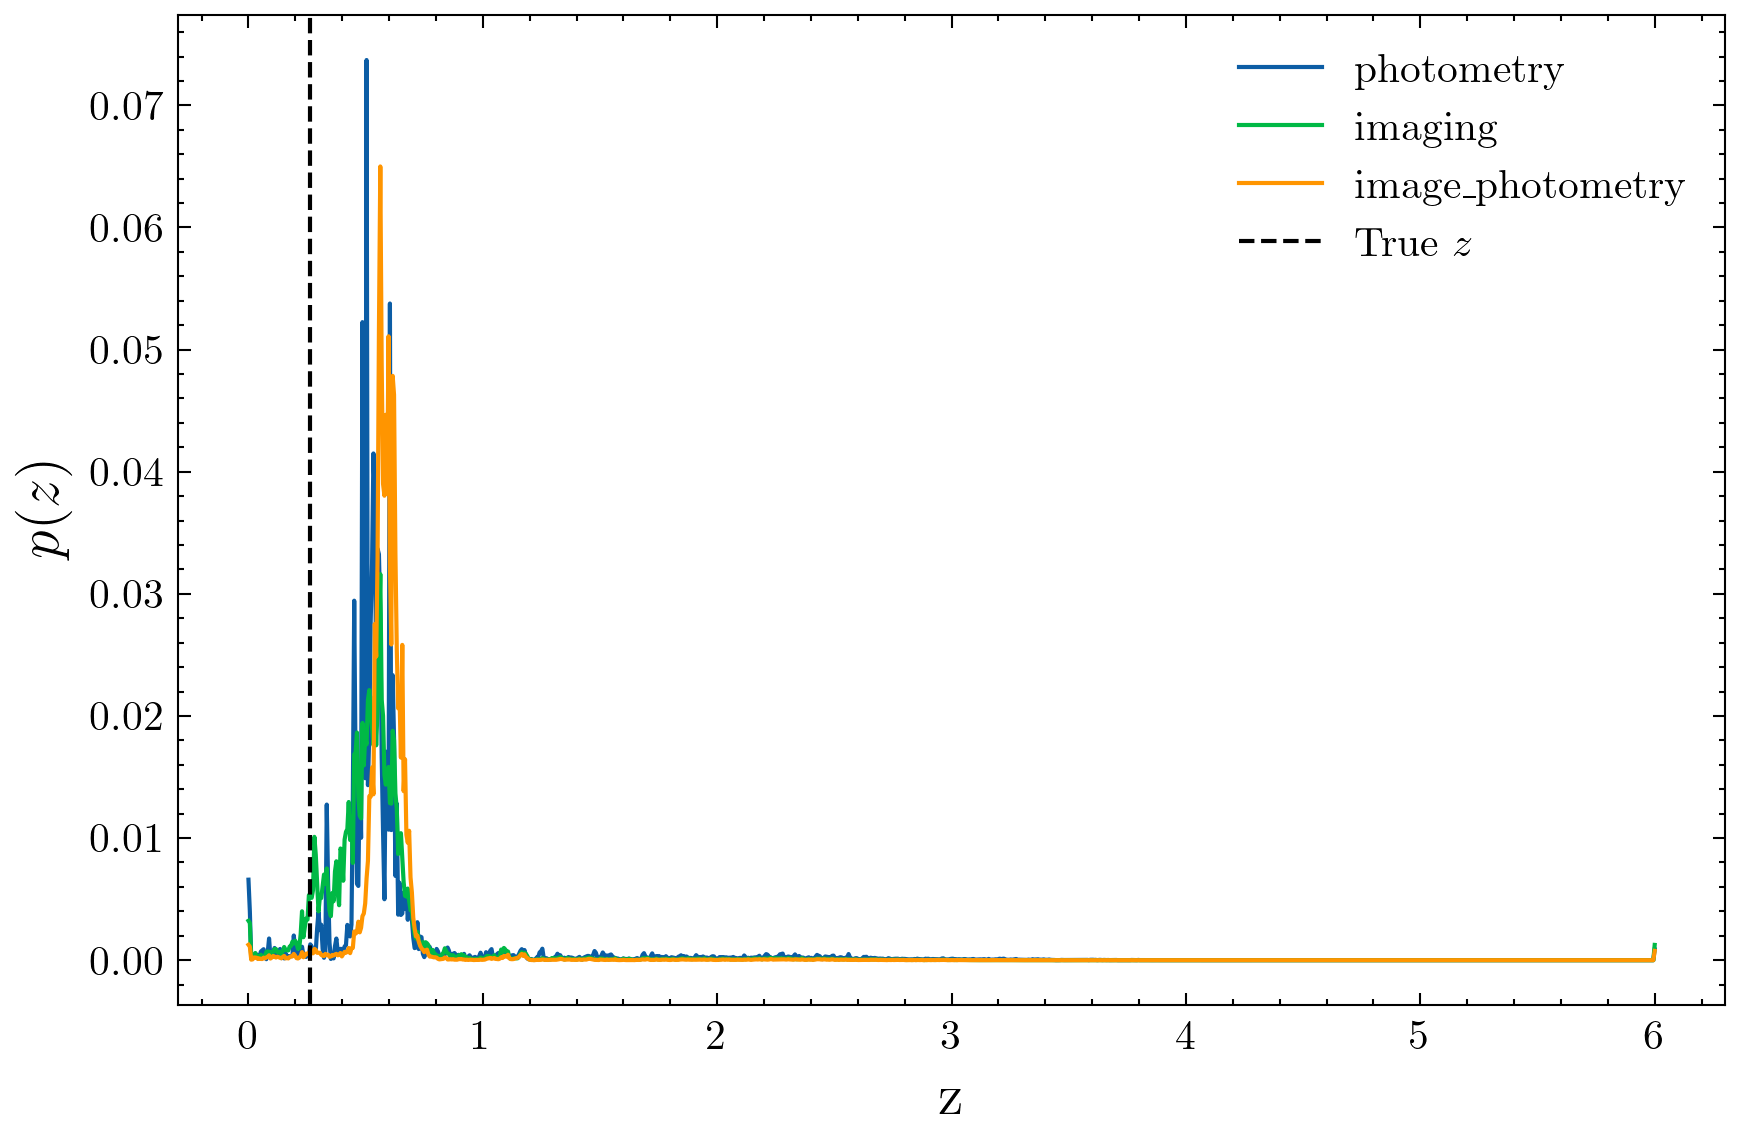

------------------------------------------------


<Table length=1>
     TARGETID        sSFR       LOG_MSTAR      legacysurvey_EBV   desi_Z  
      int64        float32       float64           float32       float32  
----------------- --------- ------------------ ---------------- ----------
39627811962490196 -10.68928 10.933209419250488      0.031905256 0.06443886

Z                                    79.490692
Photometry                           92.312134
Imaging                              81.460793
Spectroscopy                         69.217590
Image + Photometry                   81.062660
Image + Spectrum                     69.771278
Image + Spectrum + Photometry        69.846107
Image + Spectrum + Photometry + Z    69.614304
ratio_p_ip                            1.138775
ratio_p_ip_rank                      13.000000
Name: 2394, dtype: float64

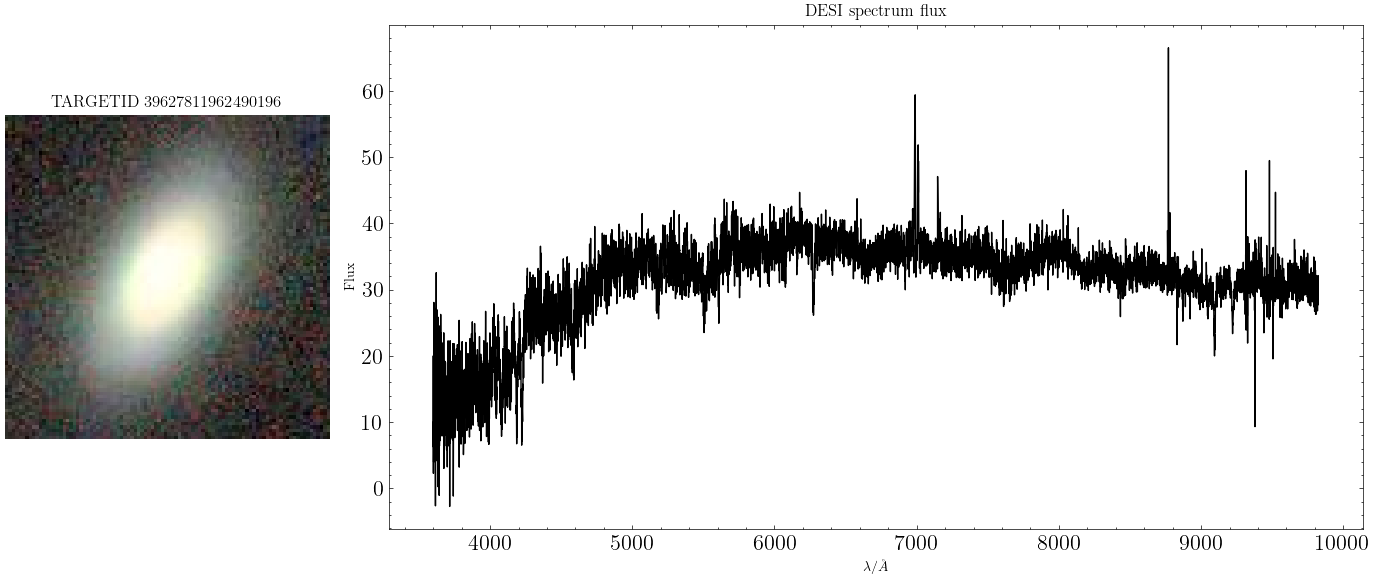

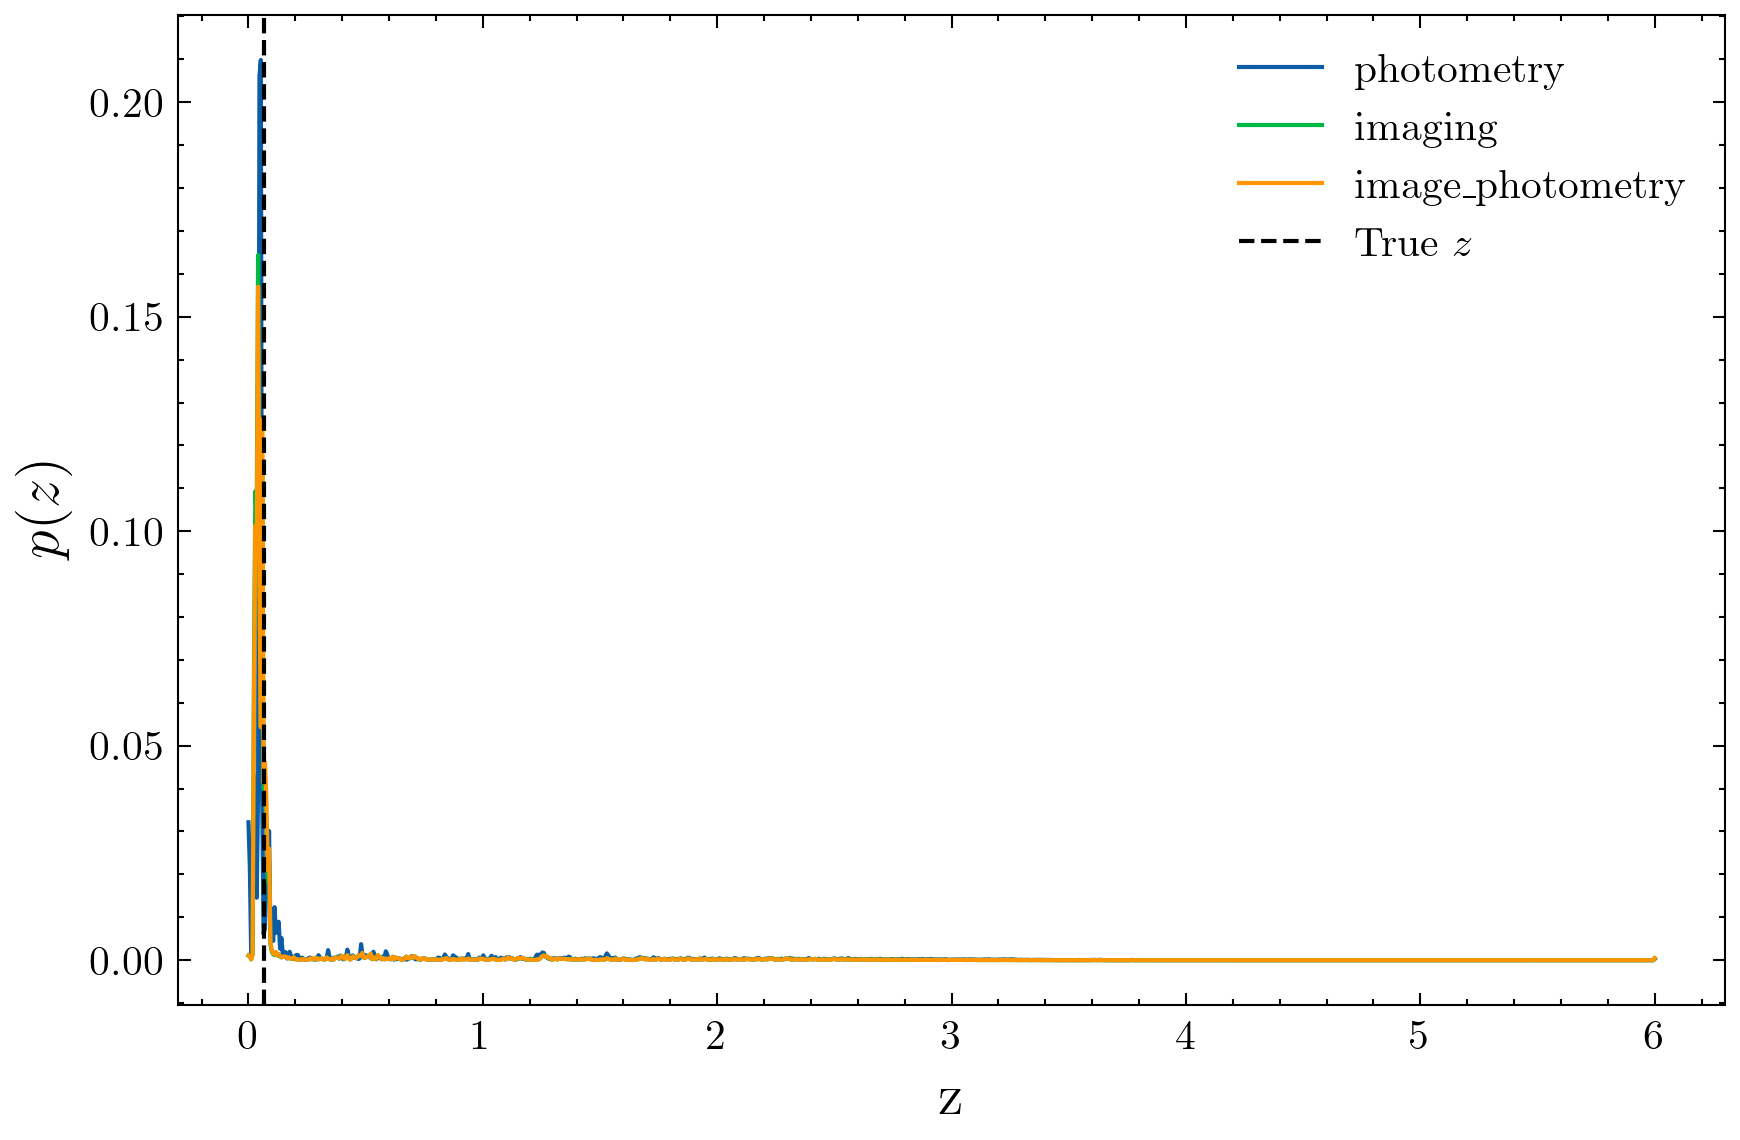

------------------------------------------------


<Table length=1>
     TARGETID        sSFR       LOG_MSTAR      legacysurvey_EBV   desi_Z 
      int64        float32       float64           float32       float32 
----------------- --------- ------------------ ---------------- ---------
39627799853535751 -8.254359 11.229397773742676      0.025684483 0.5357809

Z                                    79.774490
Photometry                           84.364220
Imaging                              74.212006
Spectroscopy                         73.224579
Image + Photometry                   73.515335
Image + Spectrum                     74.142761
Image + Spectrum + Photometry        74.447258
Image + Spectrum + Photometry + Z    74.172050
ratio_p_ip                            1.147573
ratio_p_ip_rank                      14.000000
Name: 1311, dtype: float64

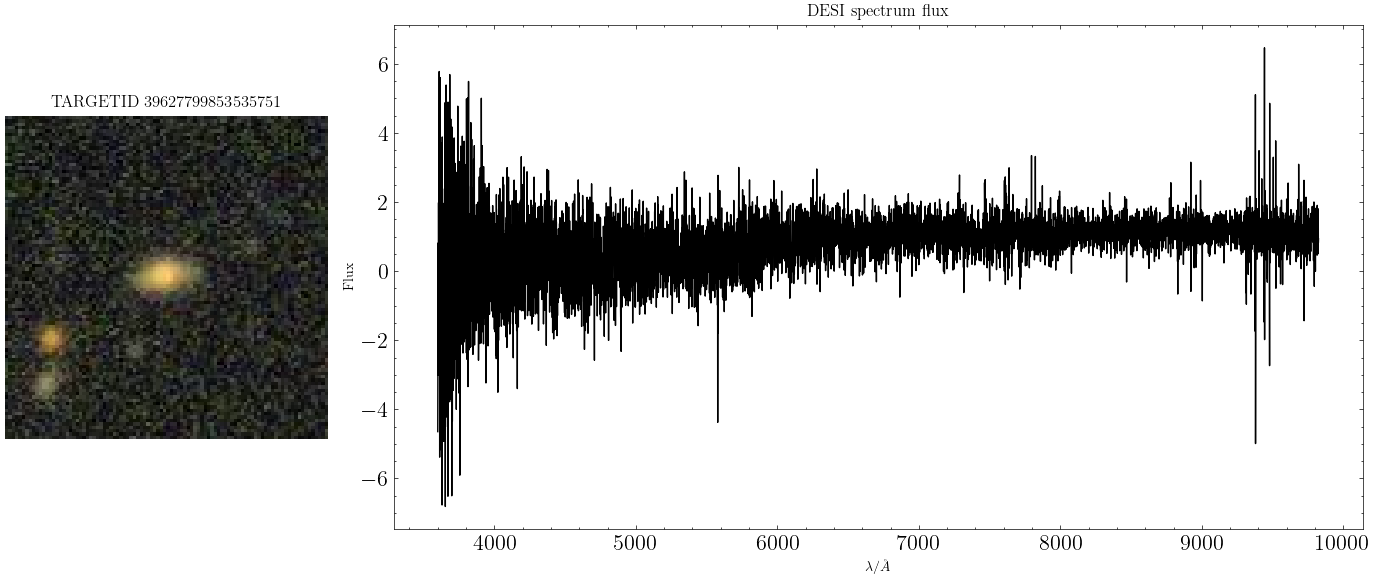

------------------------------------------------


<Table length=1>
     TARGETID        sSFR        LOG_MSTAR      legacysurvey_EBV   desi_Z  
      int64        float32        float64           float32       float32  
----------------- ---------- ------------------ ---------------- ----------
39627811949906867 -11.727986 11.273386001586914      0.027700365 0.37272906

Z                                    56.593796
Photometry                           79.594086
Imaging                              71.123146
Spectroscopy                         50.006687
Image + Photometry                   68.678230
Image + Spectrum                     50.009090
Image + Spectrum + Photometry        50.009735
Image + Spectrum + Photometry + Z    50.011414
ratio_p_ip                            1.158942
ratio_p_ip_rank                      15.000000
Name: 2173, dtype: float64

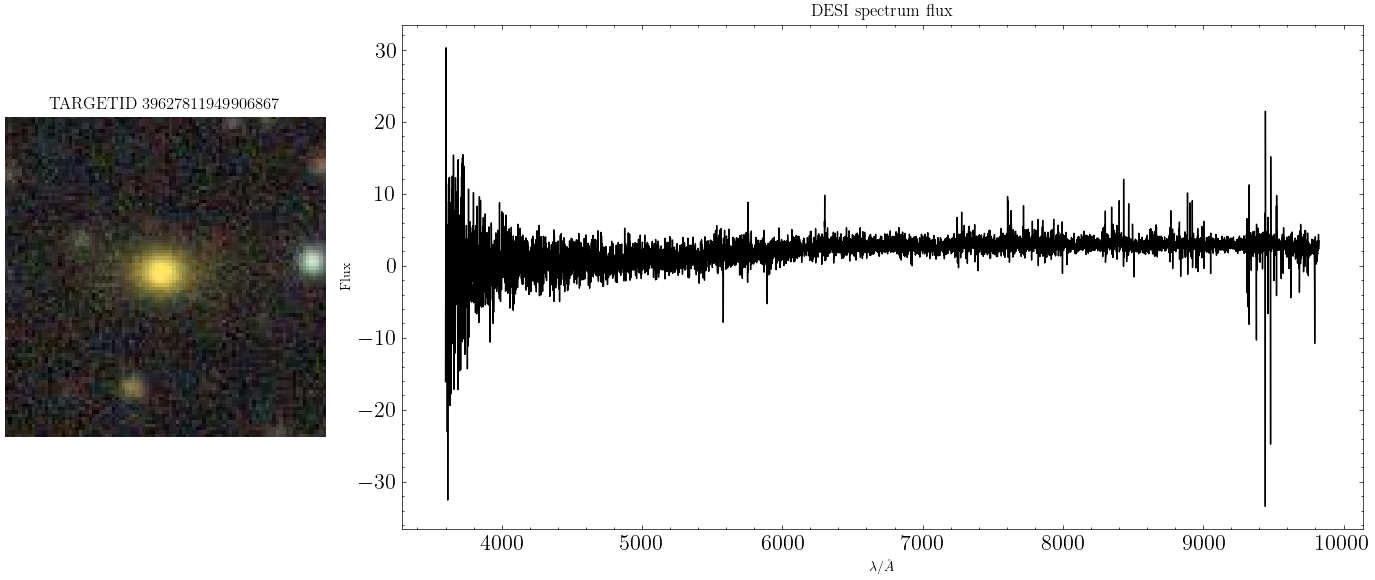

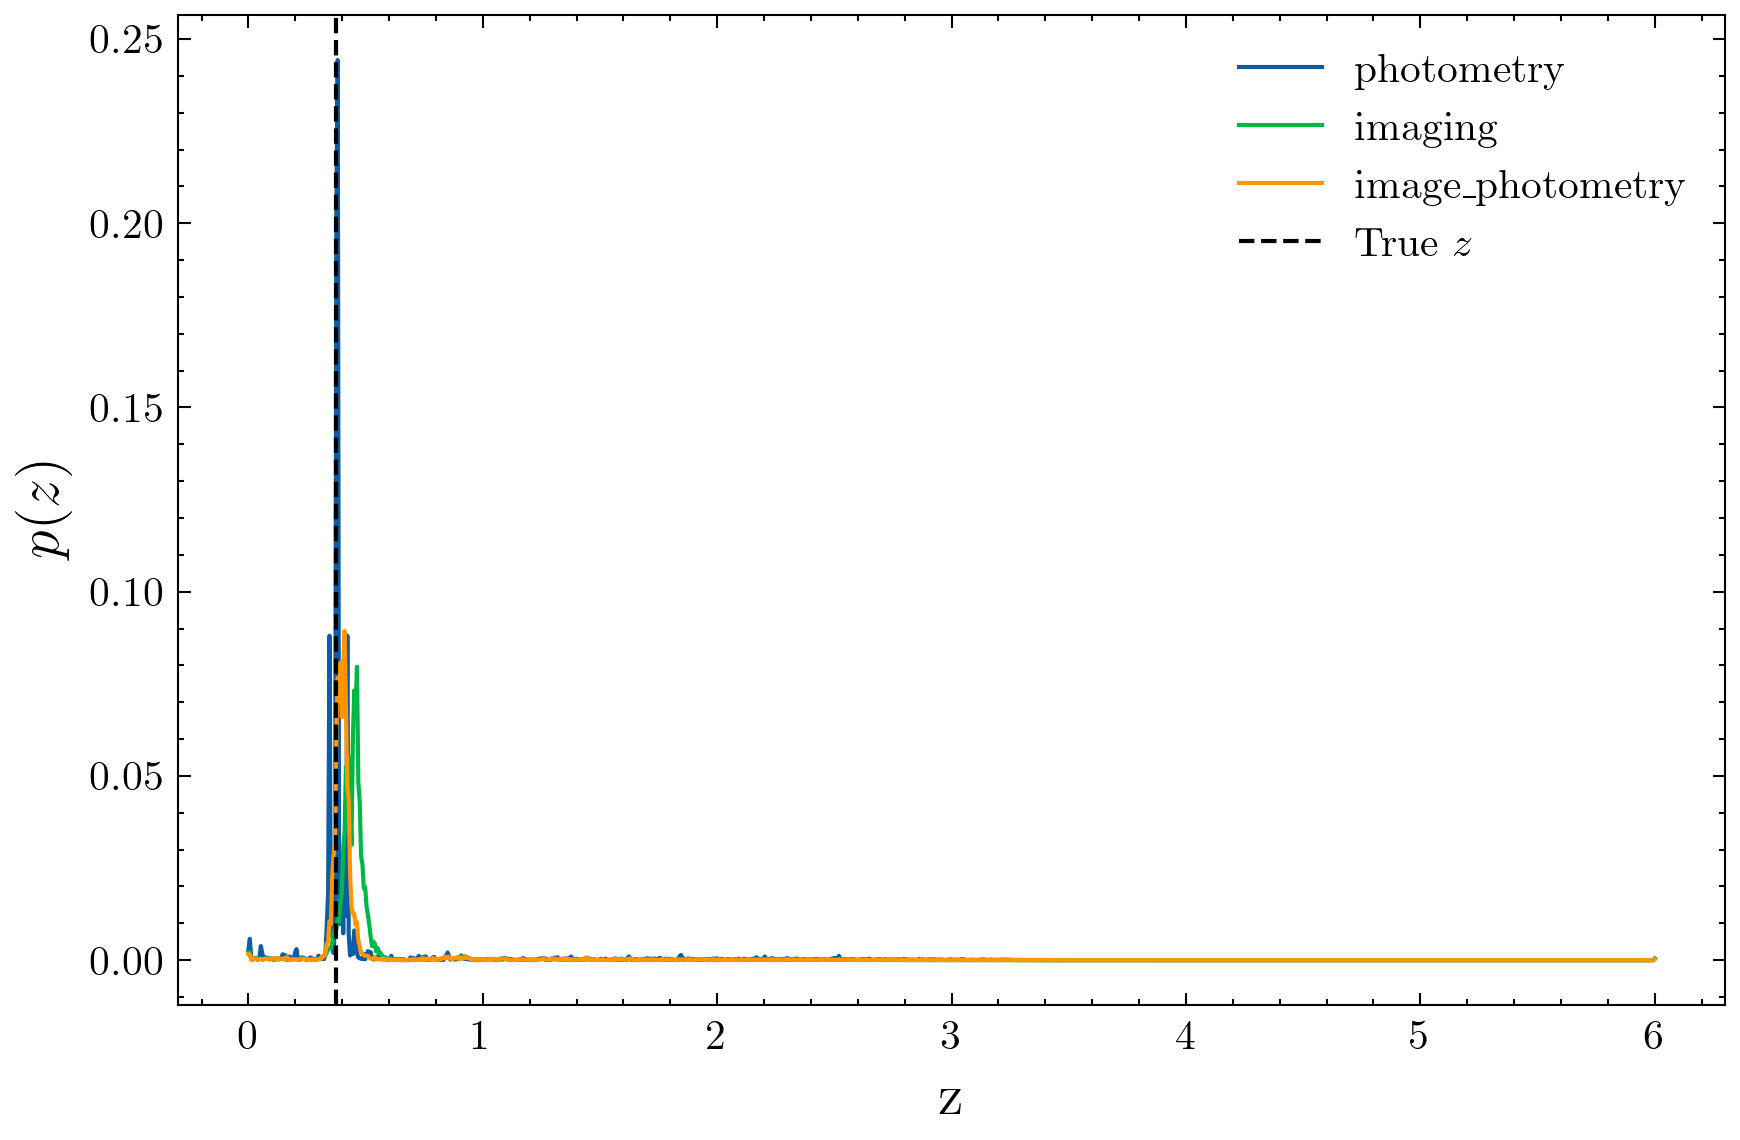

------------------------------------------------


<Table length=1>
     TARGETID        sSFR        LOG_MSTAR      legacysurvey_EBV   desi_Z 
      int64        float32        float64           float32       float32 
----------------- ---------- ------------------ ---------------- ---------
39627763627331546 -14.997541 11.255915641784668      0.020320658 0.5965228

Z                                    99.859833
Photometry                           92.180519
Imaging                              74.672554
Spectroscopy                         81.008530
Image + Photometry                   79.426819
Image + Spectrum                     81.009079
Image + Spectrum + Photometry        81.006729
Image + Spectrum + Photometry + Z    81.019066
ratio_p_ip                            1.160572
ratio_p_ip_rank                      16.000000
Name: 3072, dtype: float64

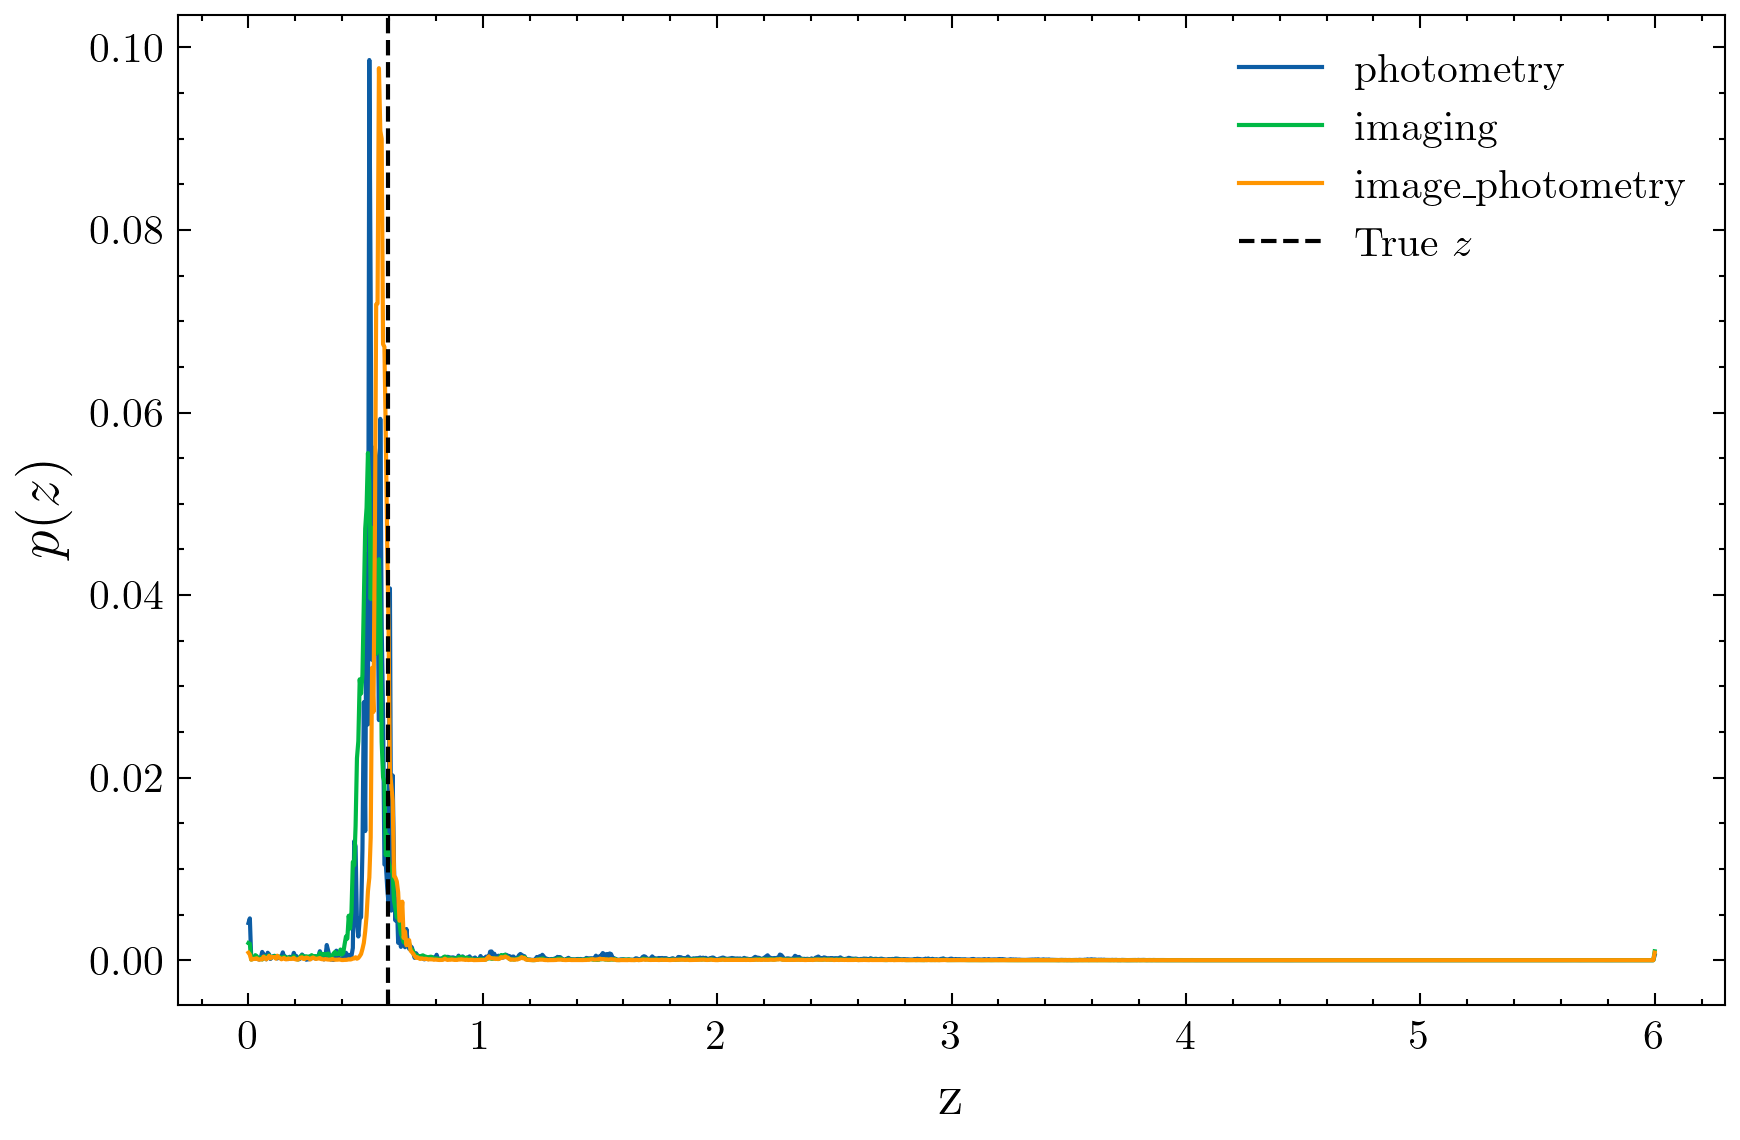

------------------------------------------------


<Table length=1>
     TARGETID        sSFR       LOG_MSTAR      legacysurvey_EBV   desi_Z 
      int64        float32       float64           float32       float32 
----------------- --------- ------------------ ---------------- ---------
39627787778134120 -8.796829 11.366617202758789      0.022601355 0.5163489

Z                                    61.644508
Photometry                           67.861374
Imaging                              67.857658
Spectroscopy                         54.832672
Image + Photometry                   58.444992
Image + Spectrum                     55.263512
Image + Spectrum + Photometry        55.528999
Image + Spectrum + Photometry + Z    54.048733
ratio_p_ip                            1.161115
ratio_p_ip_rank                      17.000000
Name: 384, dtype: float64

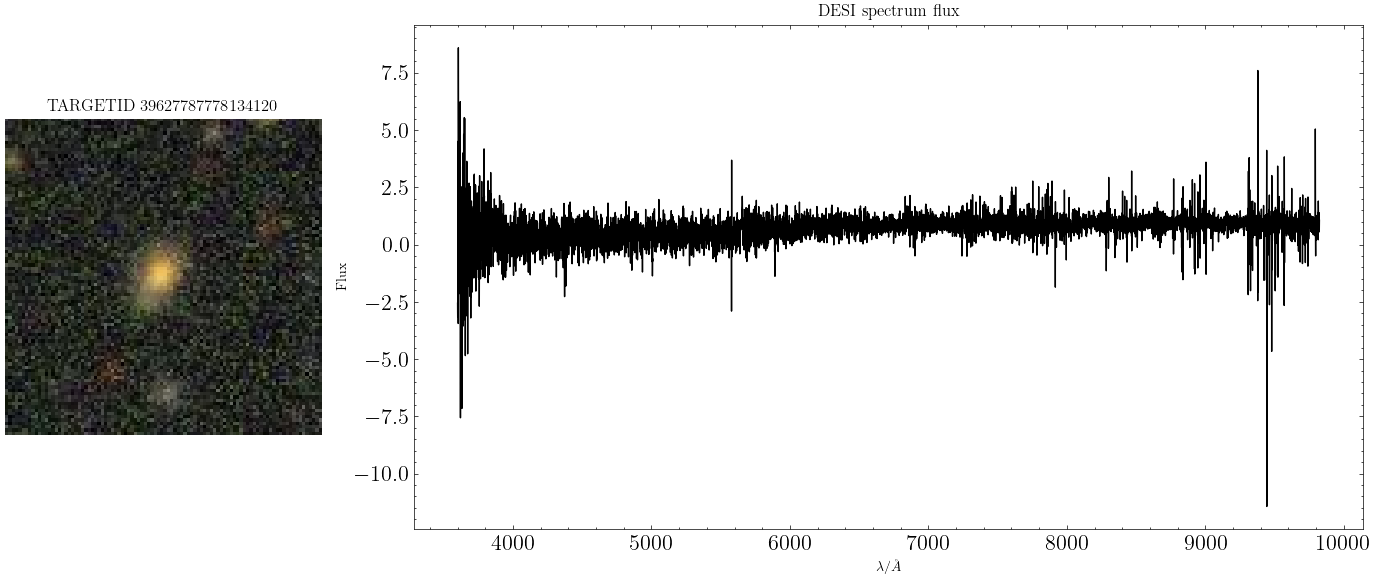

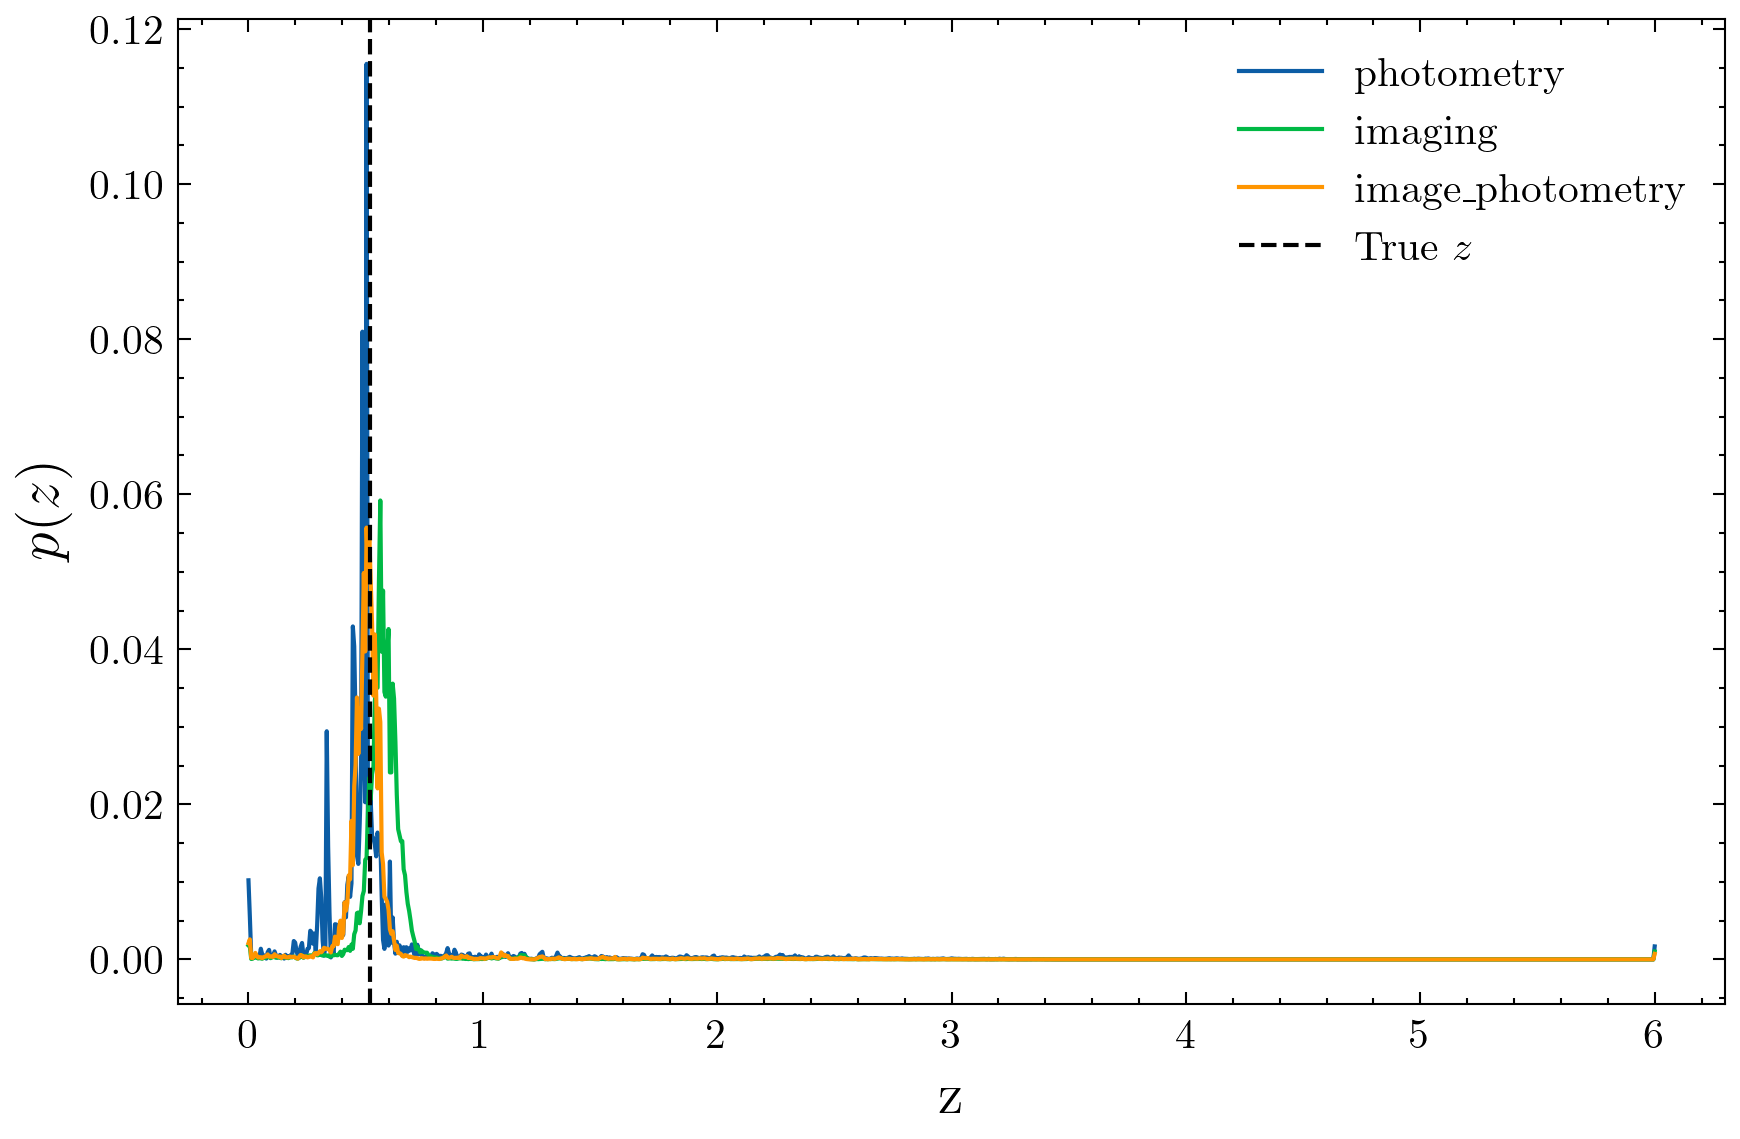

------------------------------------------------


<Table length=1>
     TARGETID       sSFR       LOG_MSTAR      legacysurvey_EBV  desi_Z 
      int64       float32       float64           float32      float32 
----------------- -------- ------------------ ---------------- --------
39627763635717045 -9.97773 11.387070655822754       0.02129699 0.517818

Z                                     83.342178
Photometry                           101.991287
Imaging                               75.108994
Spectroscopy                          76.019516
Image + Photometry                    86.431023
Image + Spectrum                      76.014771
Image + Spectrum + Photometry         76.018280
Image + Spectrum + Photometry + Z     76.027397
ratio_p_ip                             1.180031
ratio_p_ip_rank                       18.000000
Name: 3165, dtype: float64

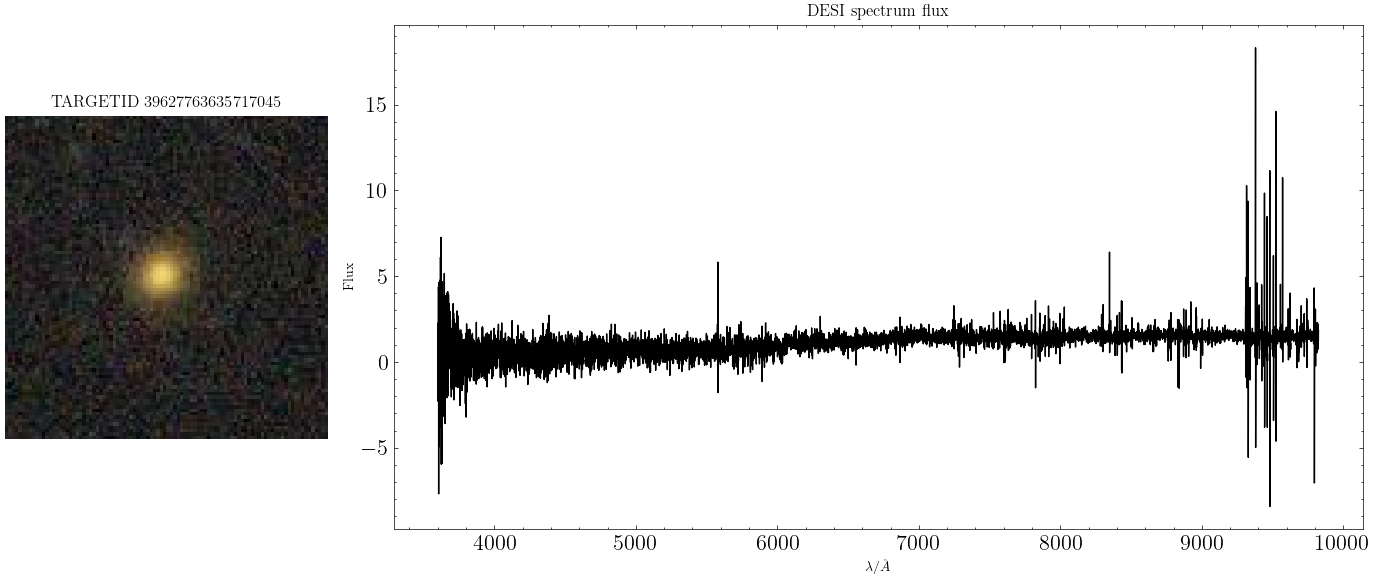

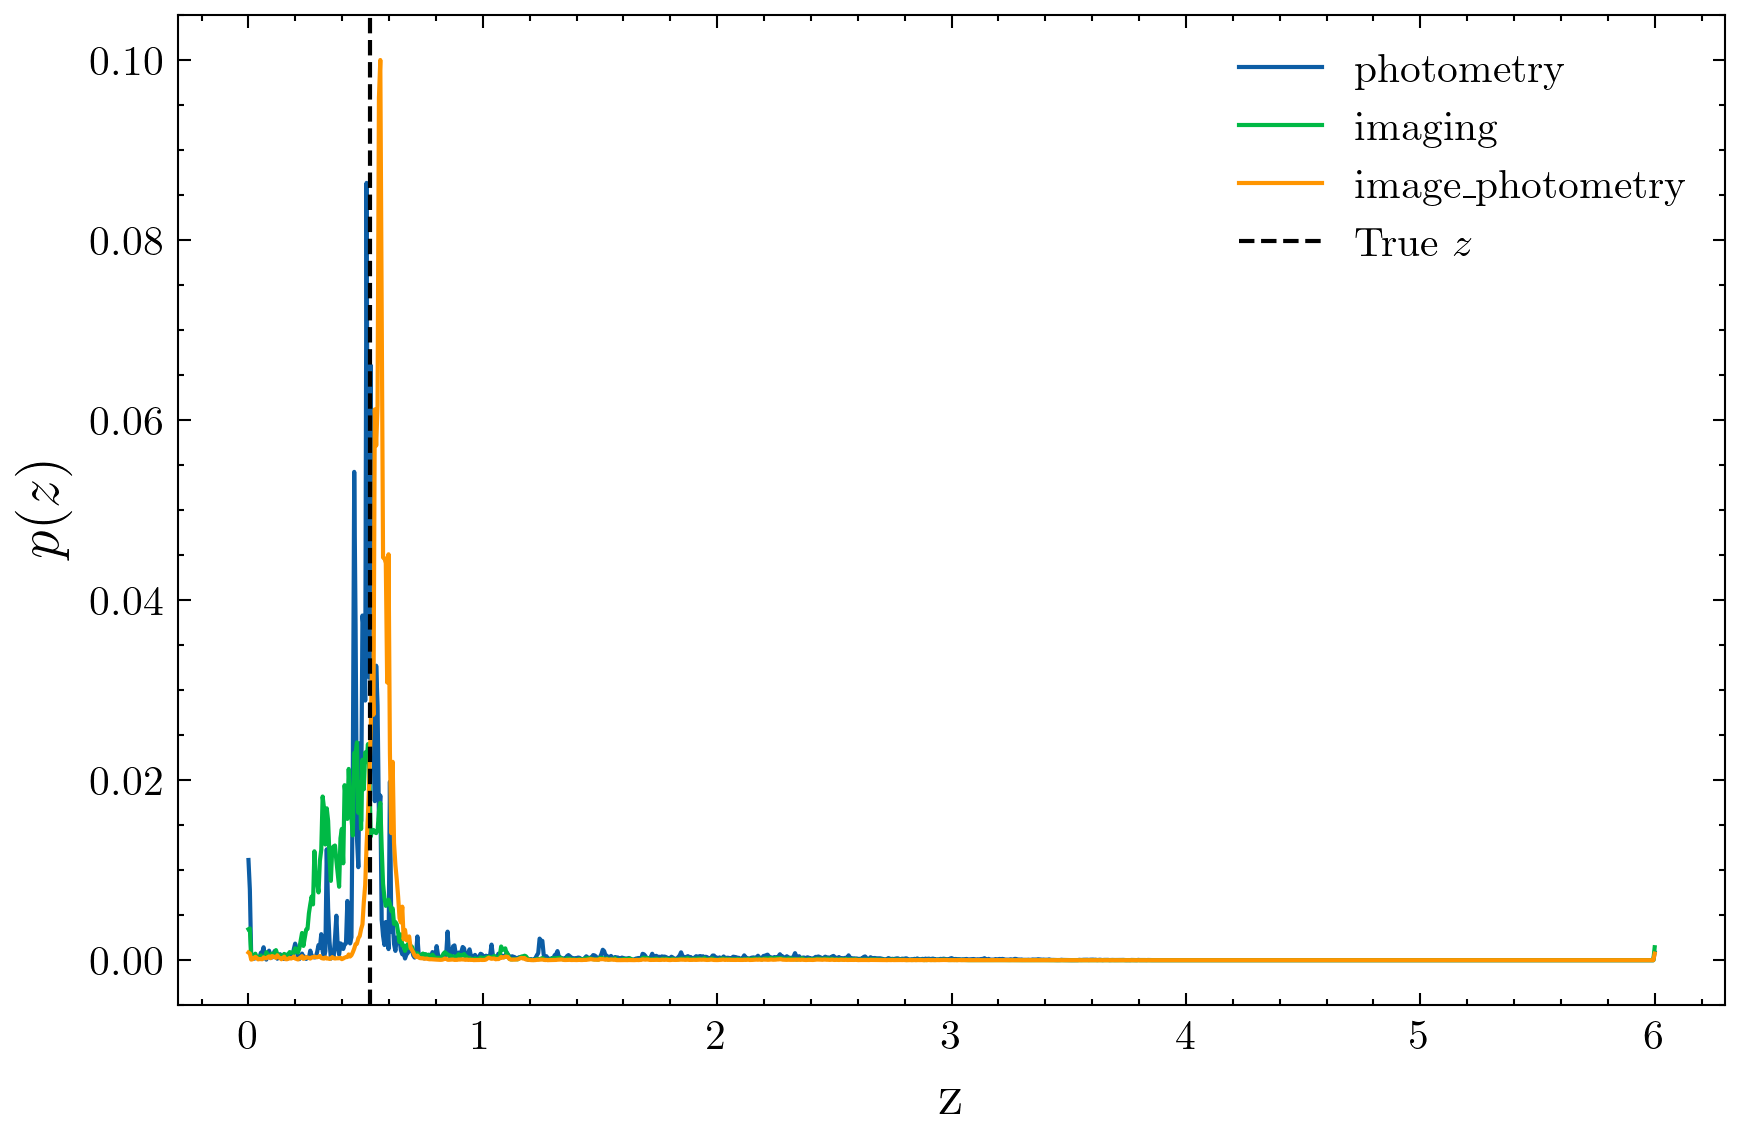

------------------------------------------------


<Table length=1>
     TARGETID        sSFR        LOG_MSTAR      legacysurvey_EBV   desi_Z 
      int64        float32        float64           float32       float32 
----------------- ---------- ------------------ ---------------- ---------
39627781725749750 -13.600062 11.435555458068848      0.026667433 0.4094183

Z                                    64.717880
Photometry                           82.284996
Imaging                              69.362801
Spectroscopy                         57.015709
Image + Photometry                   69.682083
Image + Spectrum                     57.012169
Image + Spectrum + Photometry        57.008564
Image + Spectrum + Photometry + Z    57.022346
ratio_p_ip                            1.180863
ratio_p_ip_rank                      19.000000
Name: 3663, dtype: float64

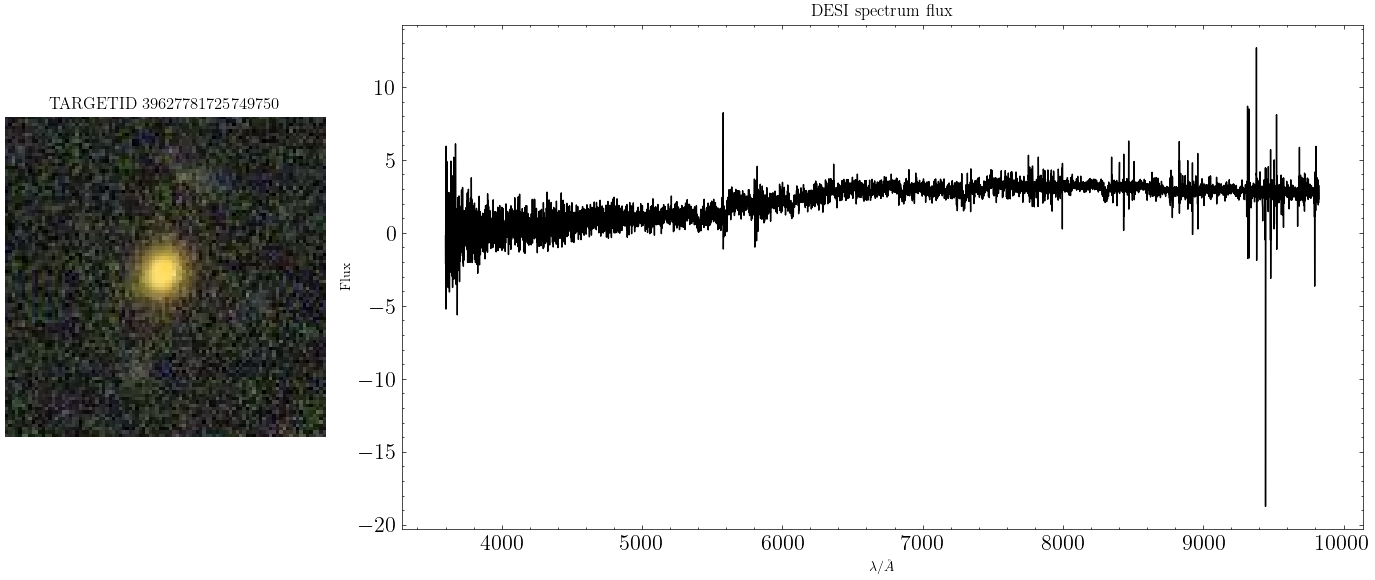

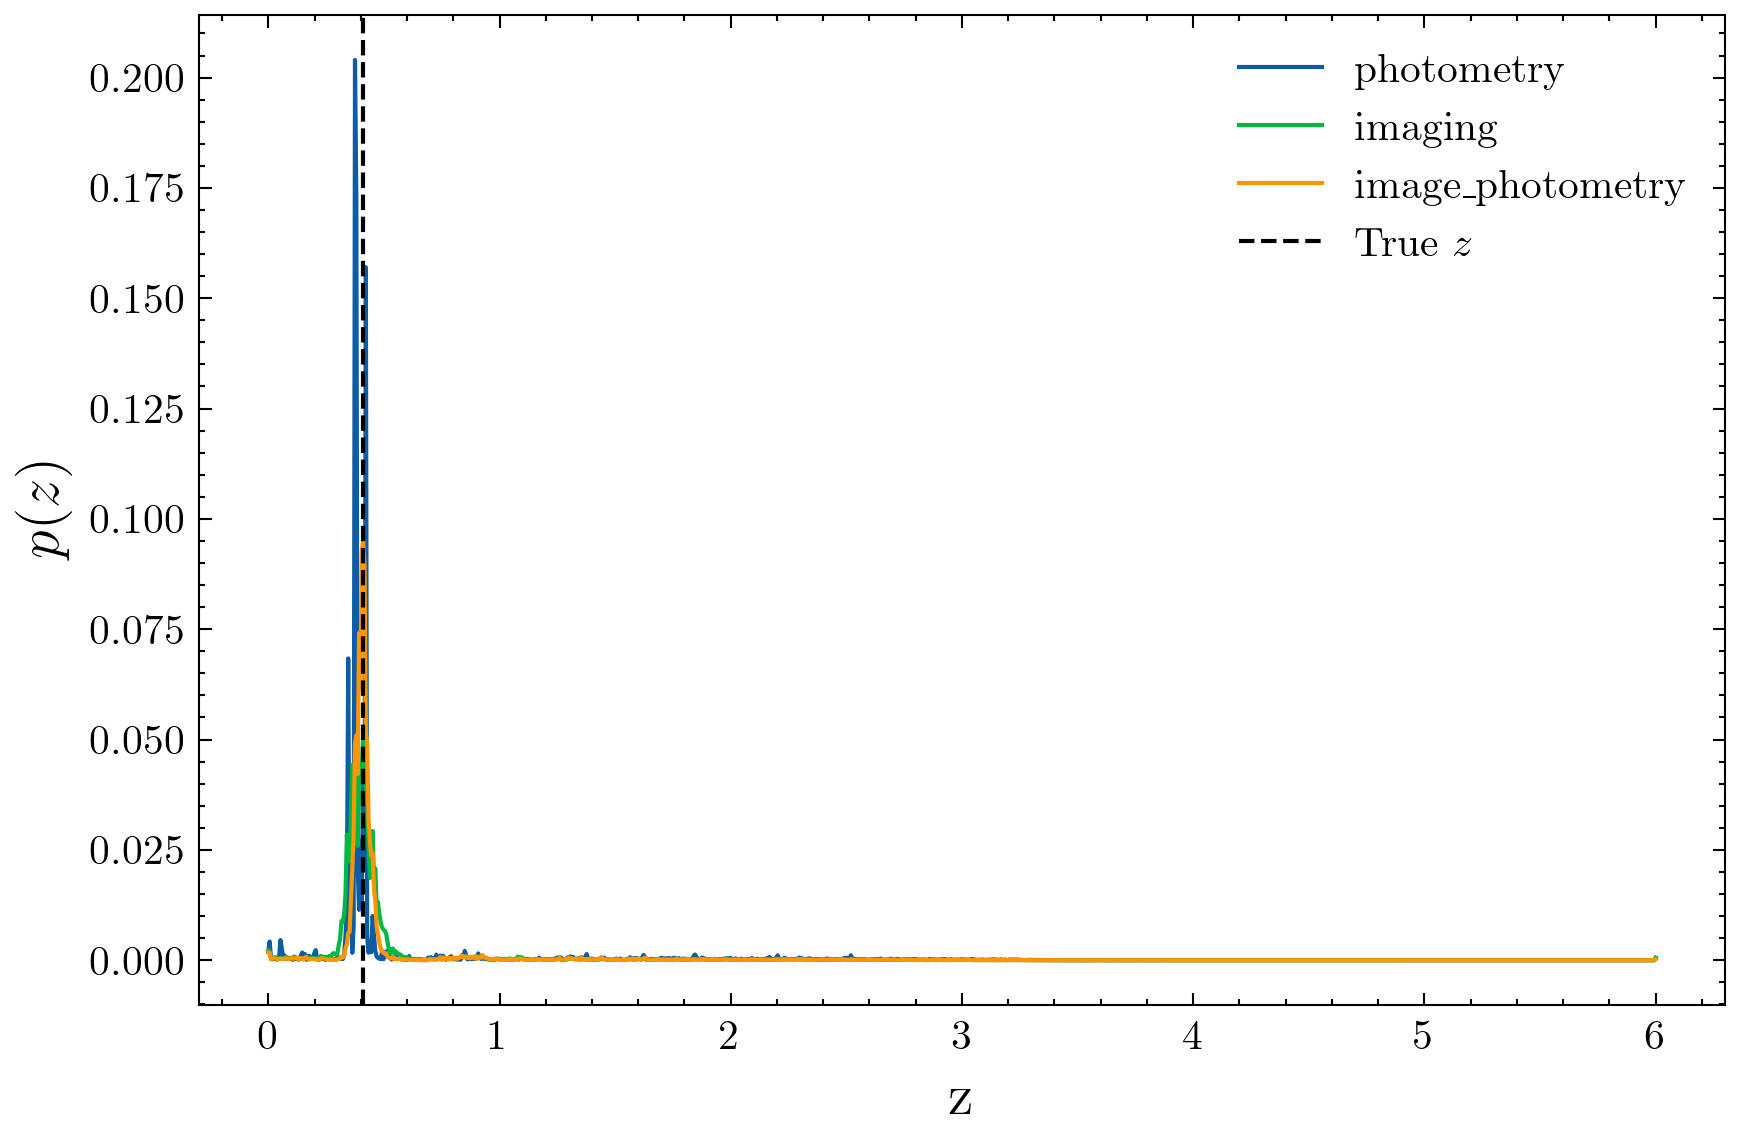

------------------------------------------------


<Table length=1>
     TARGETID        sSFR        LOG_MSTAR      legacysurvey_EBV   desi_Z 
      int64        float32        float64           float32       float32 
----------------- ---------- ------------------ ---------------- ---------
39627787773940940 -10.170531 11.618257522583008      0.019650107 0.4649779

Z                                    88.195953
Photometry                           87.783905
Imaging                              82.080948
Spectroscopy                         65.037964
Image + Photometry                   73.844948
Image + Spectrum                     65.058426
Image + Spectrum + Photometry        65.041130
Image + Spectrum + Photometry + Z    65.058022
ratio_p_ip                            1.188760
ratio_p_ip_rank                      20.000000
Name: 359, dtype: float64

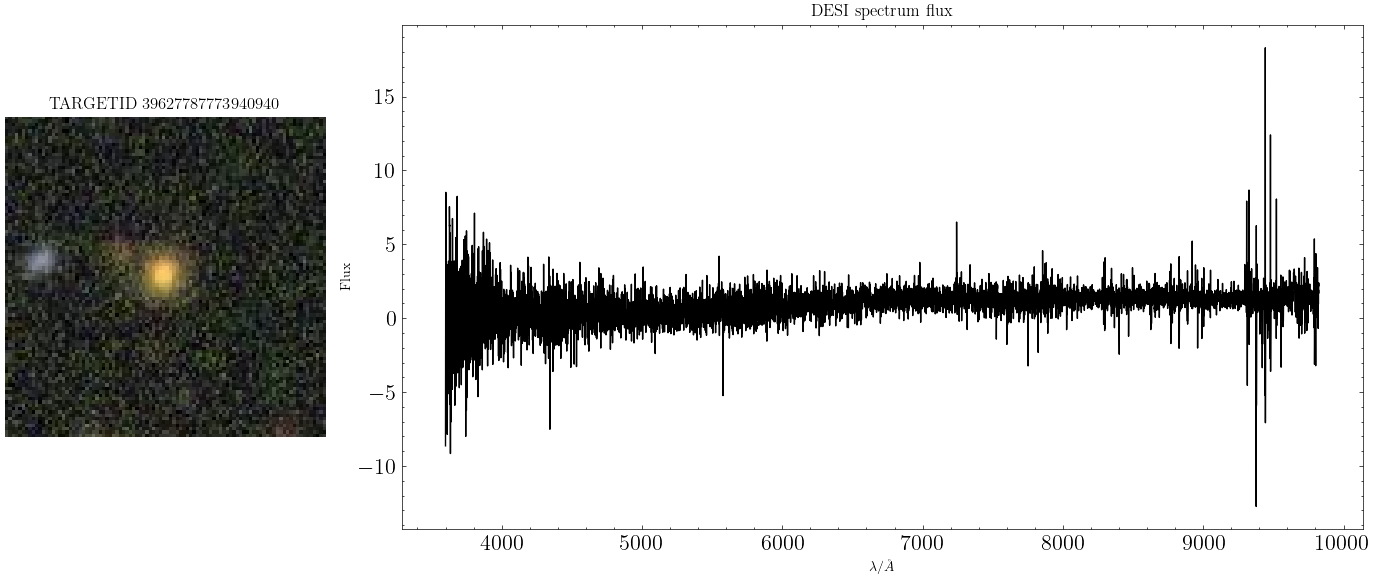

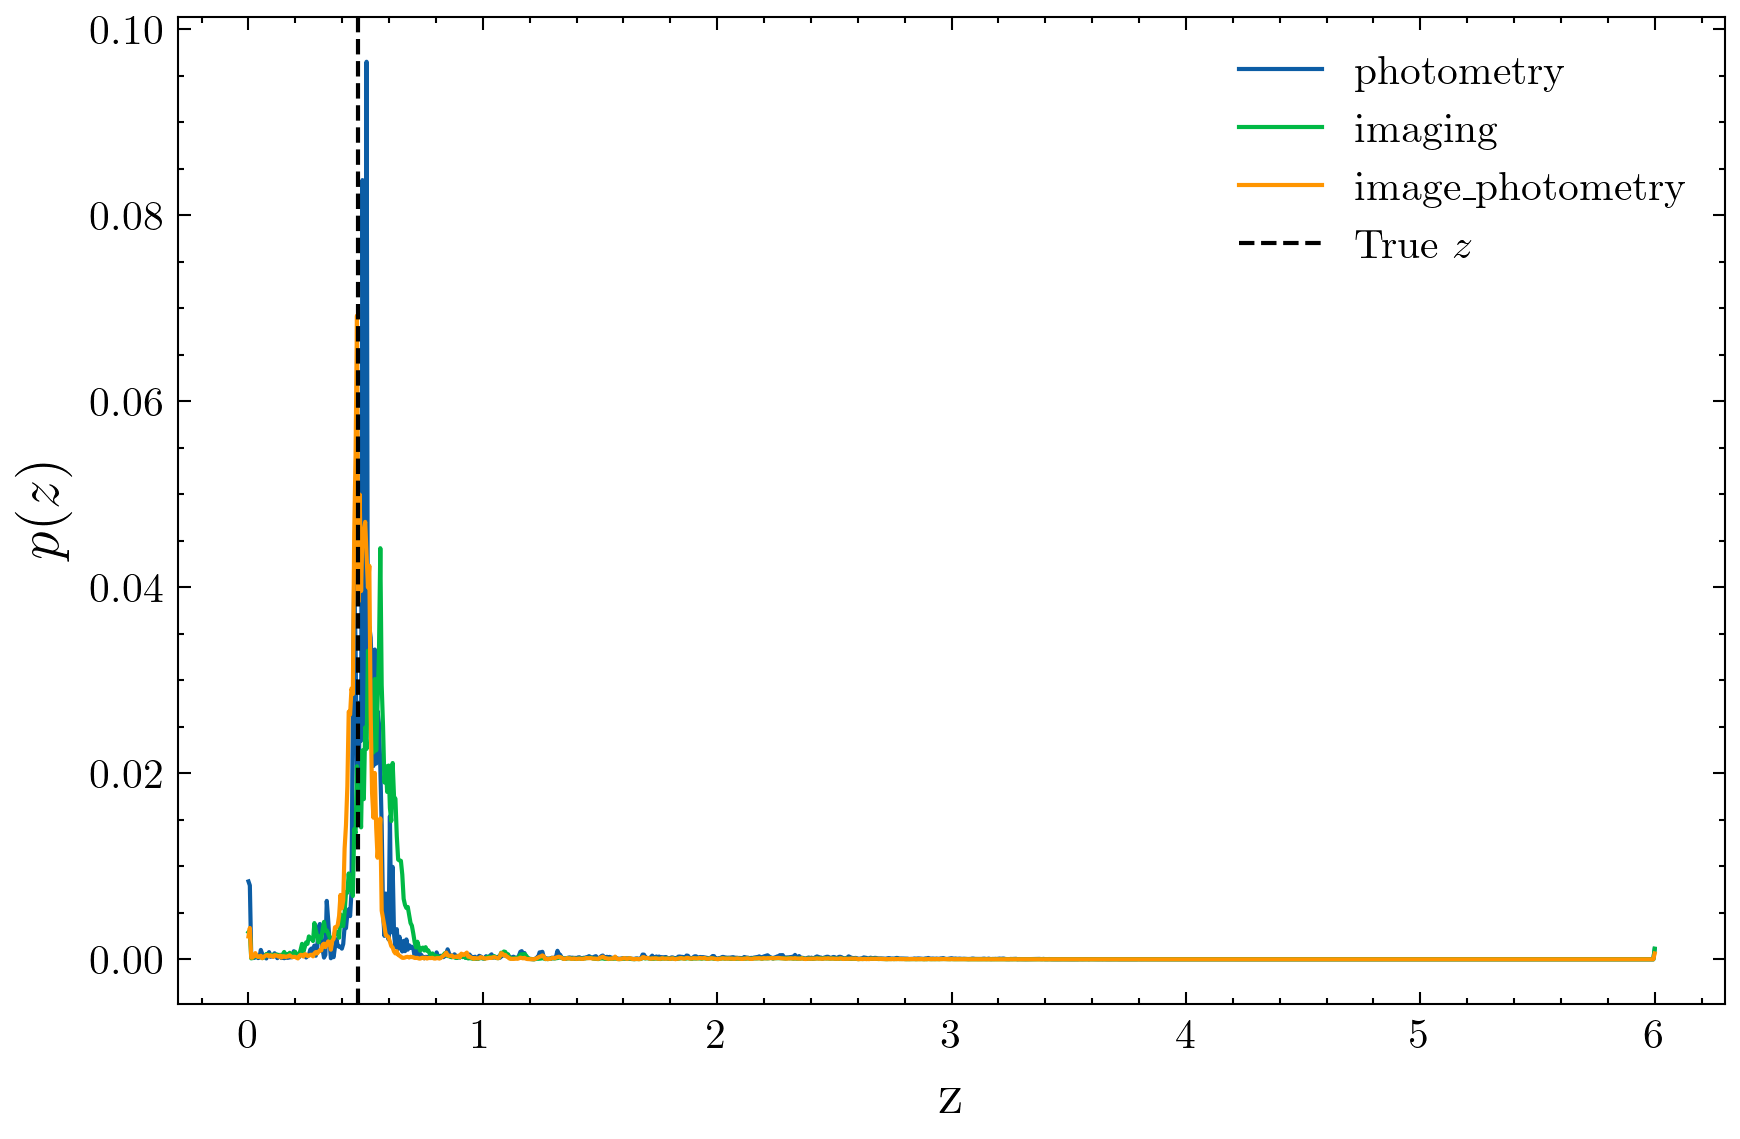

------------------------------------------------


<Table length=1>
     TARGETID        sSFR        LOG_MSTAR      legacysurvey_EBV   desi_Z  
      int64        float32        float64           float32       float32  
----------------- ---------- ------------------ ---------------- ----------
39627799866114450 -16.836353 10.771269798278809      0.027277071 0.33346546

Z                                    28.116989
Photometry                           48.616646
Imaging                              39.772003
Spectroscopy                         22.068687
Image + Photometry                   40.885540
Image + Spectrum                     22.087408
Image + Spectrum + Photometry        22.137030
Image + Spectrum + Photometry + Z    22.030872
ratio_p_ip                            1.189091
ratio_p_ip_rank                      21.000000
Name: 1395, dtype: float64

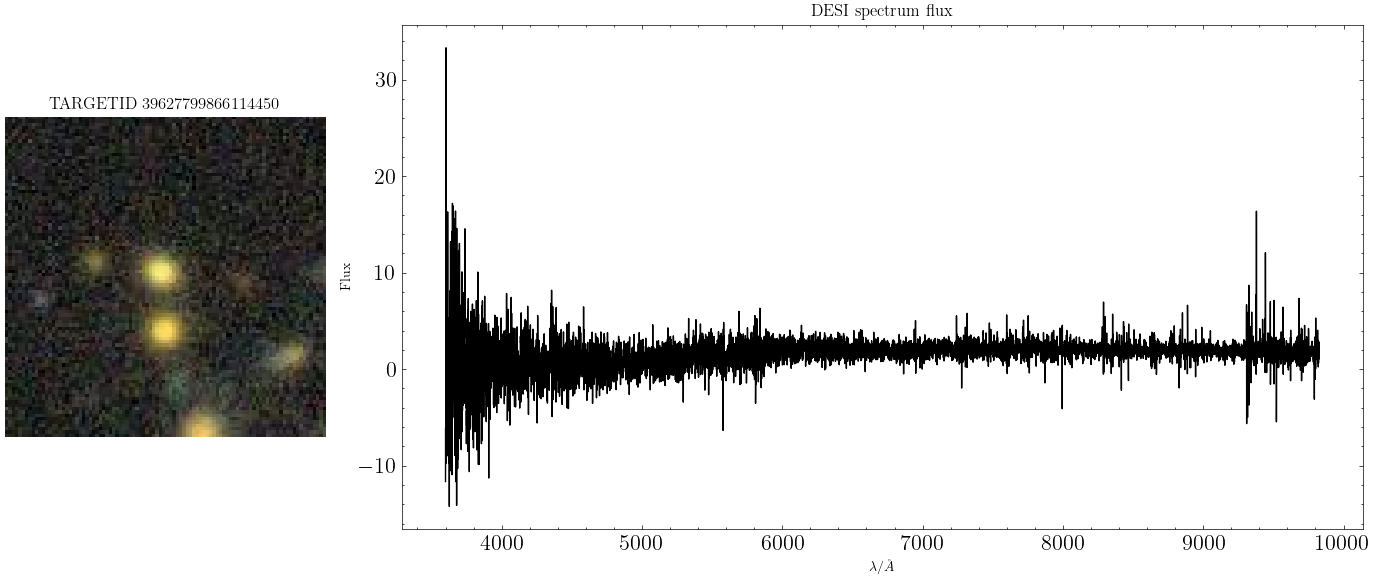

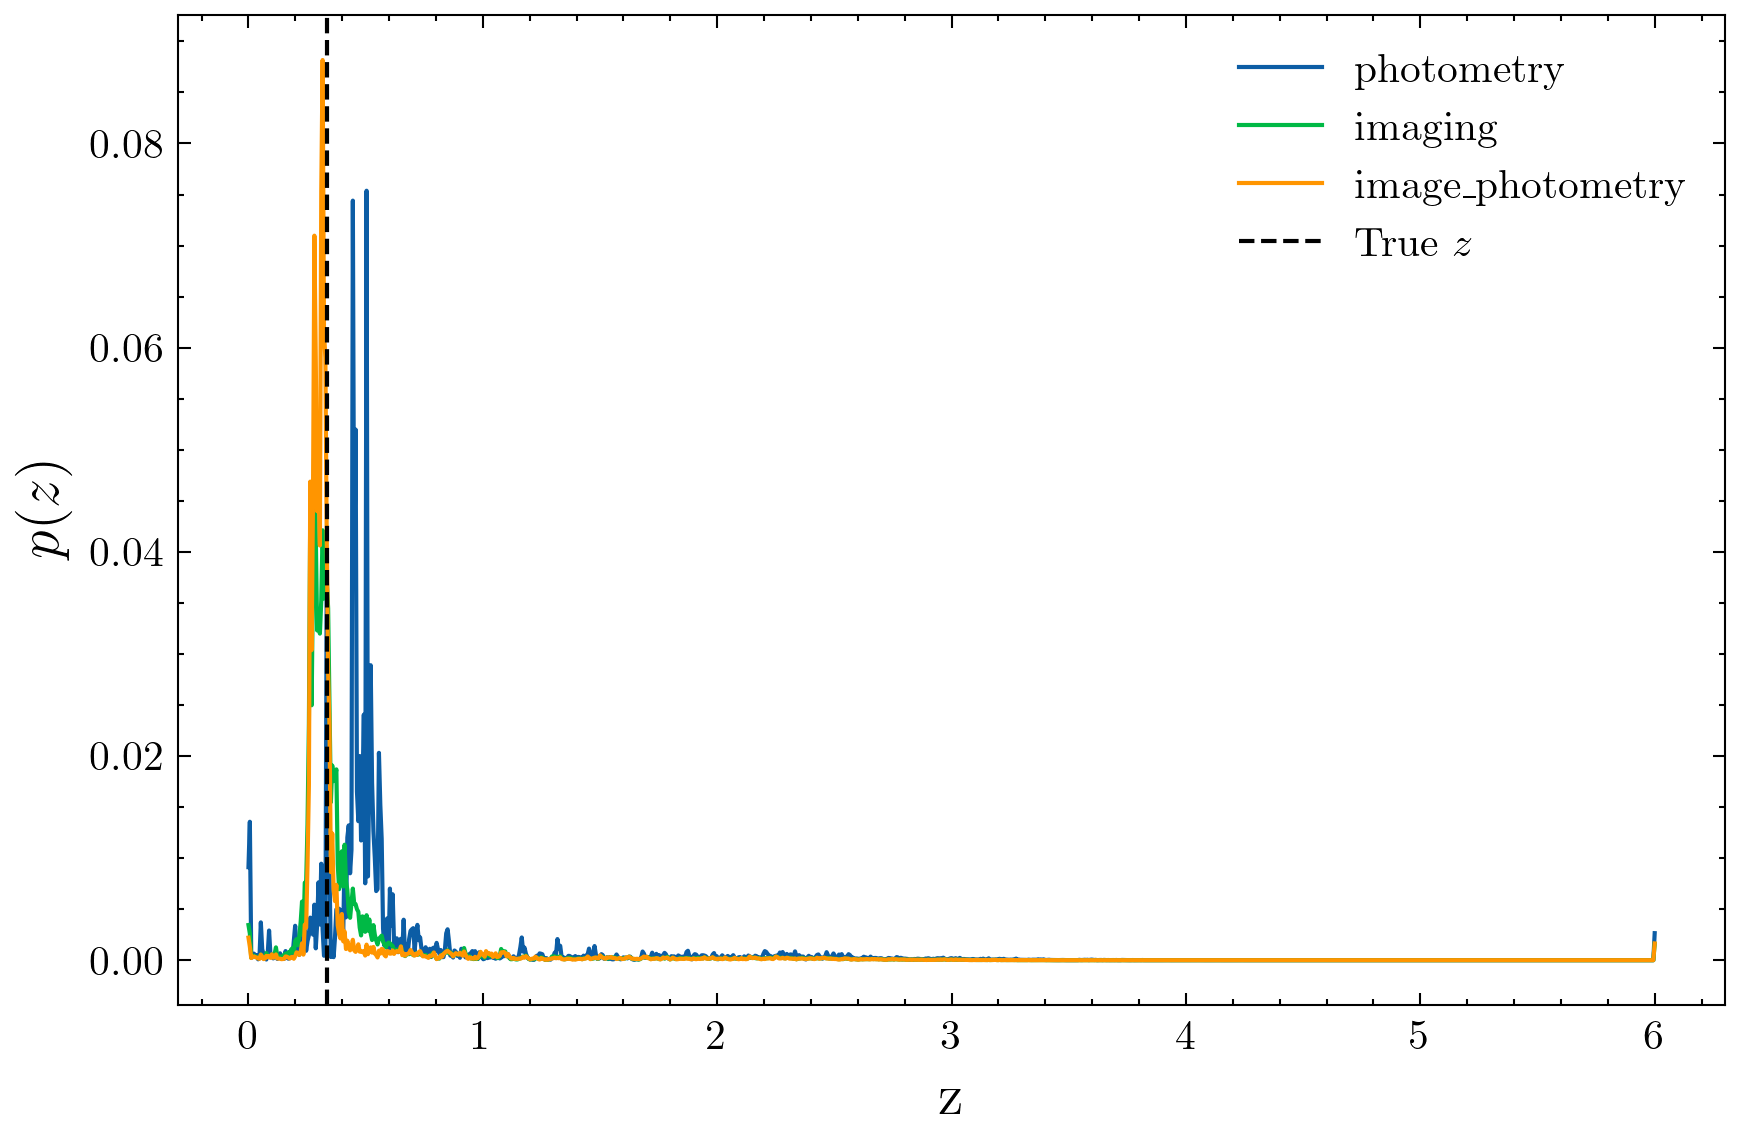

------------------------------------------------


<Table length=1>
     TARGETID        sSFR        LOG_MSTAR      legacysurvey_EBV   desi_Z 
      int64        float32        float64           float32       float32 
----------------- ---------- ------------------ ---------------- ---------
39627763618942113 -7.6524835 10.485709190368652      0.022015085 0.3787463

Z                                    36.680134
Photometry                           63.019402
Imaging                              63.138683
Spectroscopy                         35.011147
Image + Photometry                   52.796200
Image + Spectrum                     35.009647
Image + Spectrum + Photometry        35.009926
Image + Spectrum + Photometry + Z    35.009743
ratio_p_ip                            1.193635
ratio_p_ip_rank                      22.000000
Name: 2934, dtype: float64

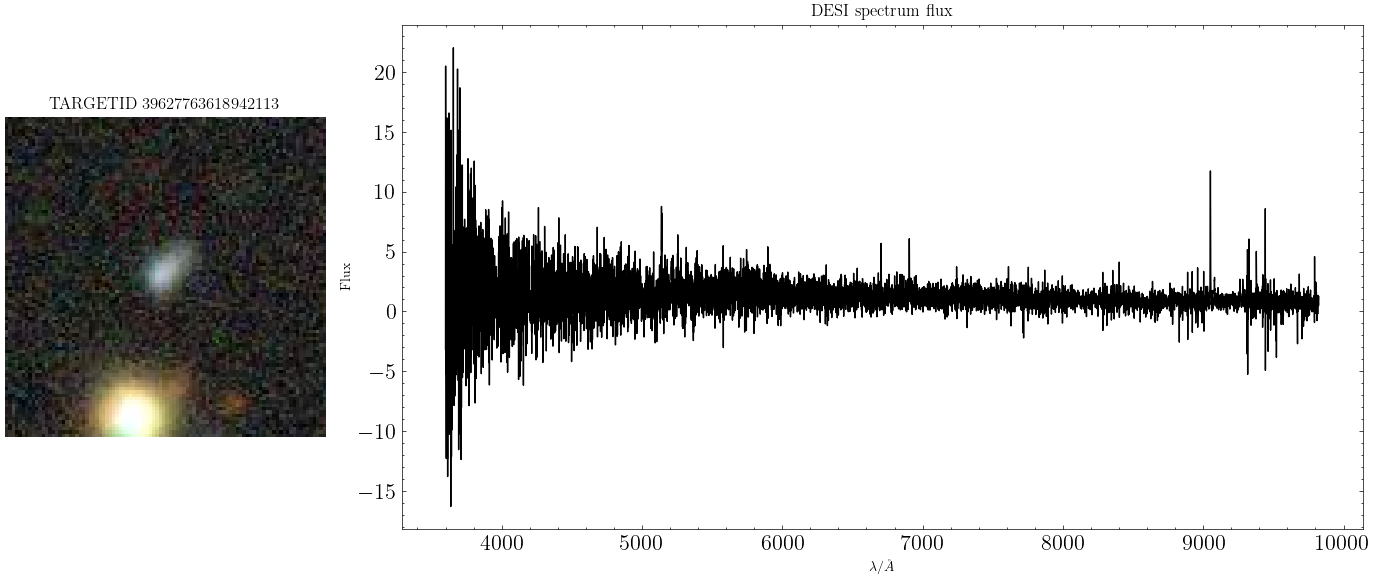

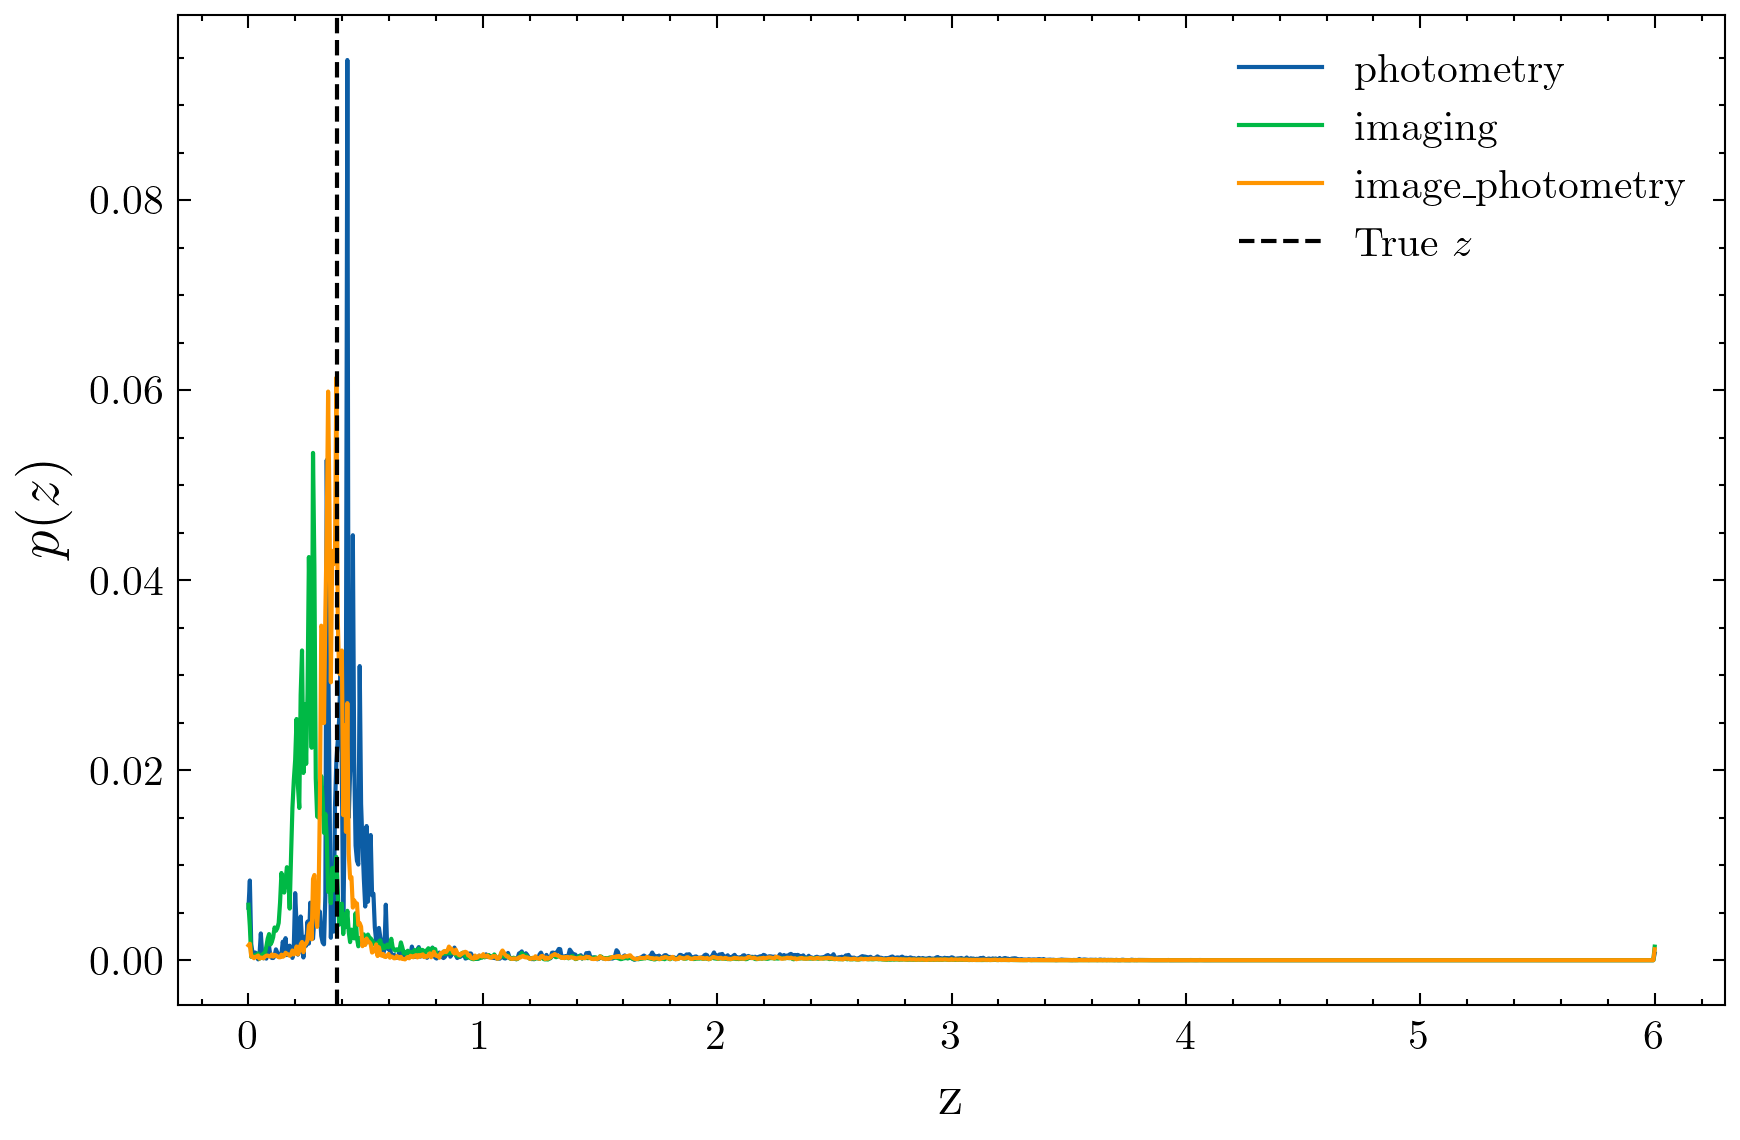

------------------------------------------------


<Table length=1>
     TARGETID        sSFR       LOG_MSTAR      legacysurvey_EBV   desi_Z  
      int64        float32       float64           float32       float32  
----------------- --------- ------------------ ---------------- ----------
39627793805348399 -8.133104 11.084630966186523      0.024457255 0.49217203

Z                                    75.398865
Photometry                           88.962784
Imaging                              72.922691
Spectroscopy                         70.192108
Image + Photometry                   74.487793
Image + Spectrum                     70.206009
Image + Spectrum + Photometry        70.259109
Image + Spectrum + Photometry + Z    70.165184
ratio_p_ip                            1.194327
ratio_p_ip_rank                      23.000000
Name: 816, dtype: float64

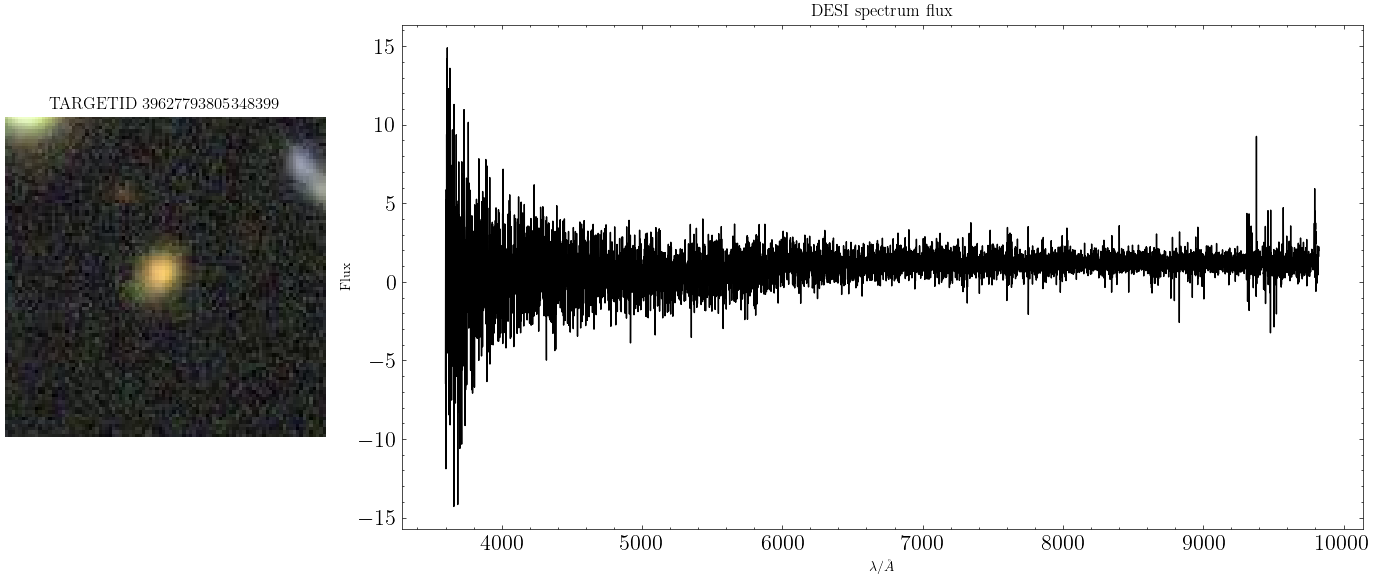

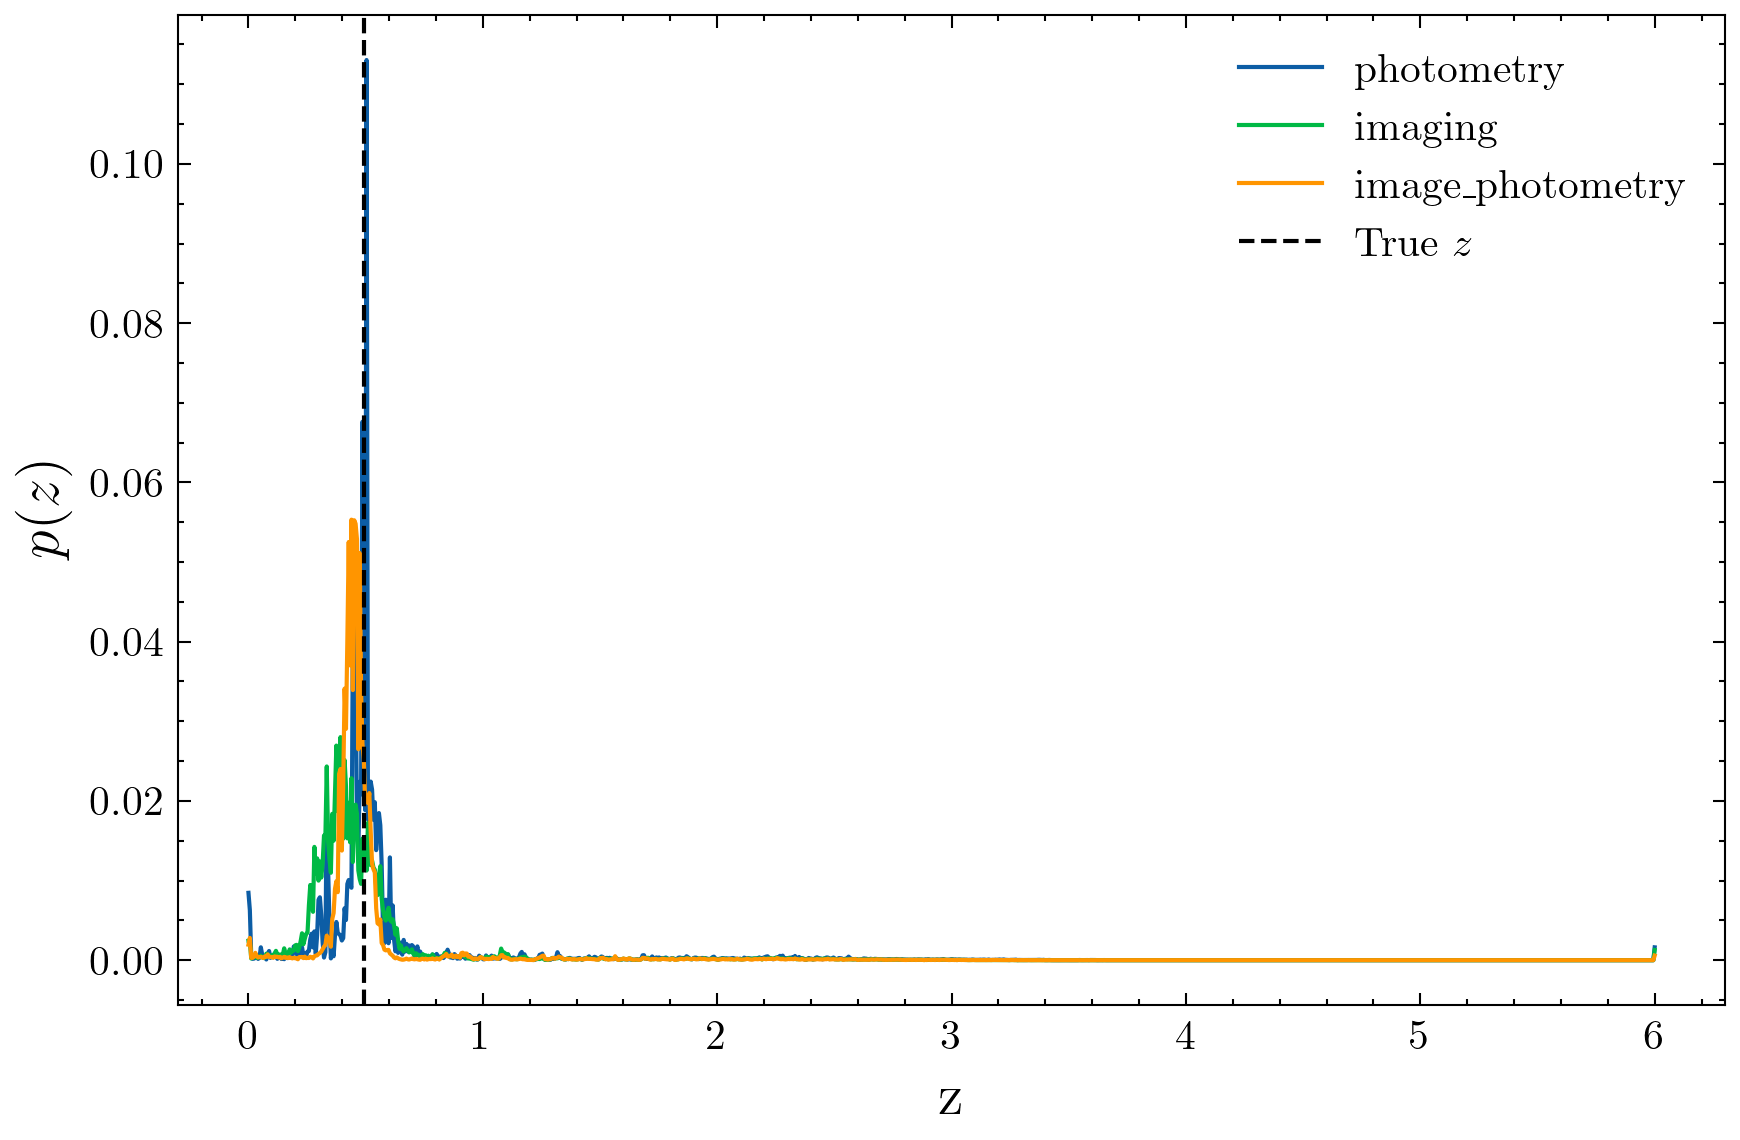

------------------------------------------------


<Table length=1>
     TARGETID        sSFR       LOG_MSTAR      legacysurvey_EBV  desi_Z 
      int64        float32       float64           float32      float32 
----------------- --------- ------------------ ---------------- --------
39627781750915233 -10.48784 10.449577331542969      0.020963566 0.318337

Z                                     55.712067
Photometry                           100.580383
Imaging                               84.707306
Spectroscopy                          52.062355
Image + Photometry                    83.967911
Image + Spectrum                      52.026062
Image + Spectrum + Photometry         52.053921
Image + Spectrum + Photometry + Z     52.076080
ratio_p_ip                             1.197843
ratio_p_ip_rank                       24.000000
Name: 3761, dtype: float64

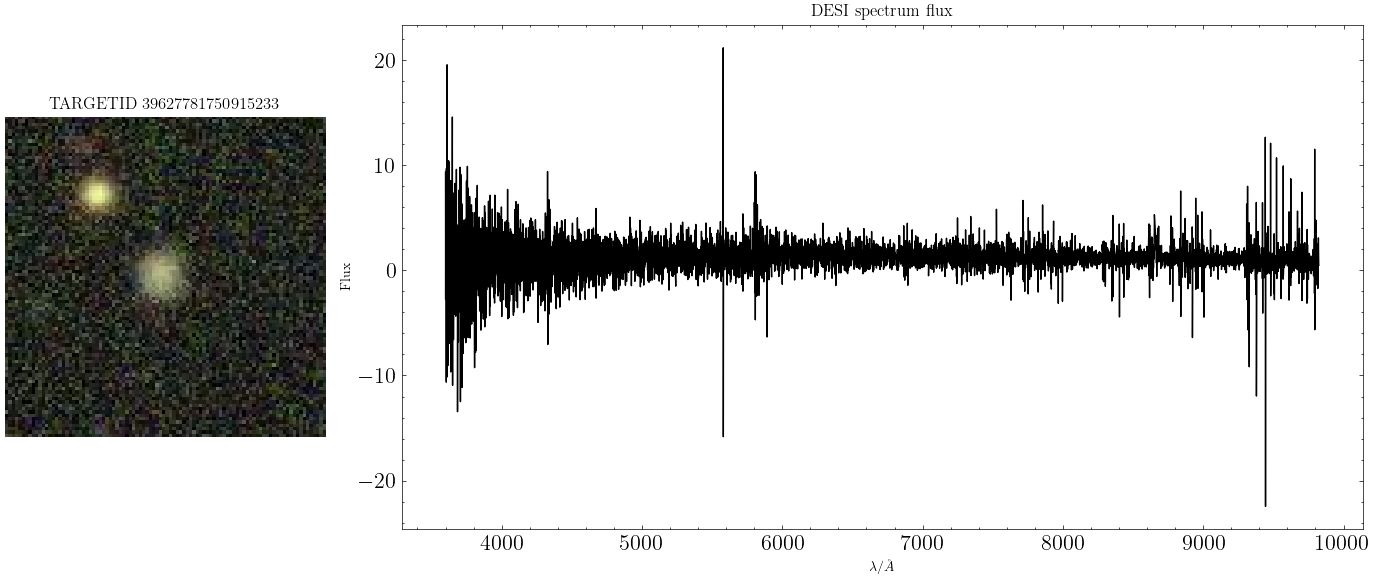

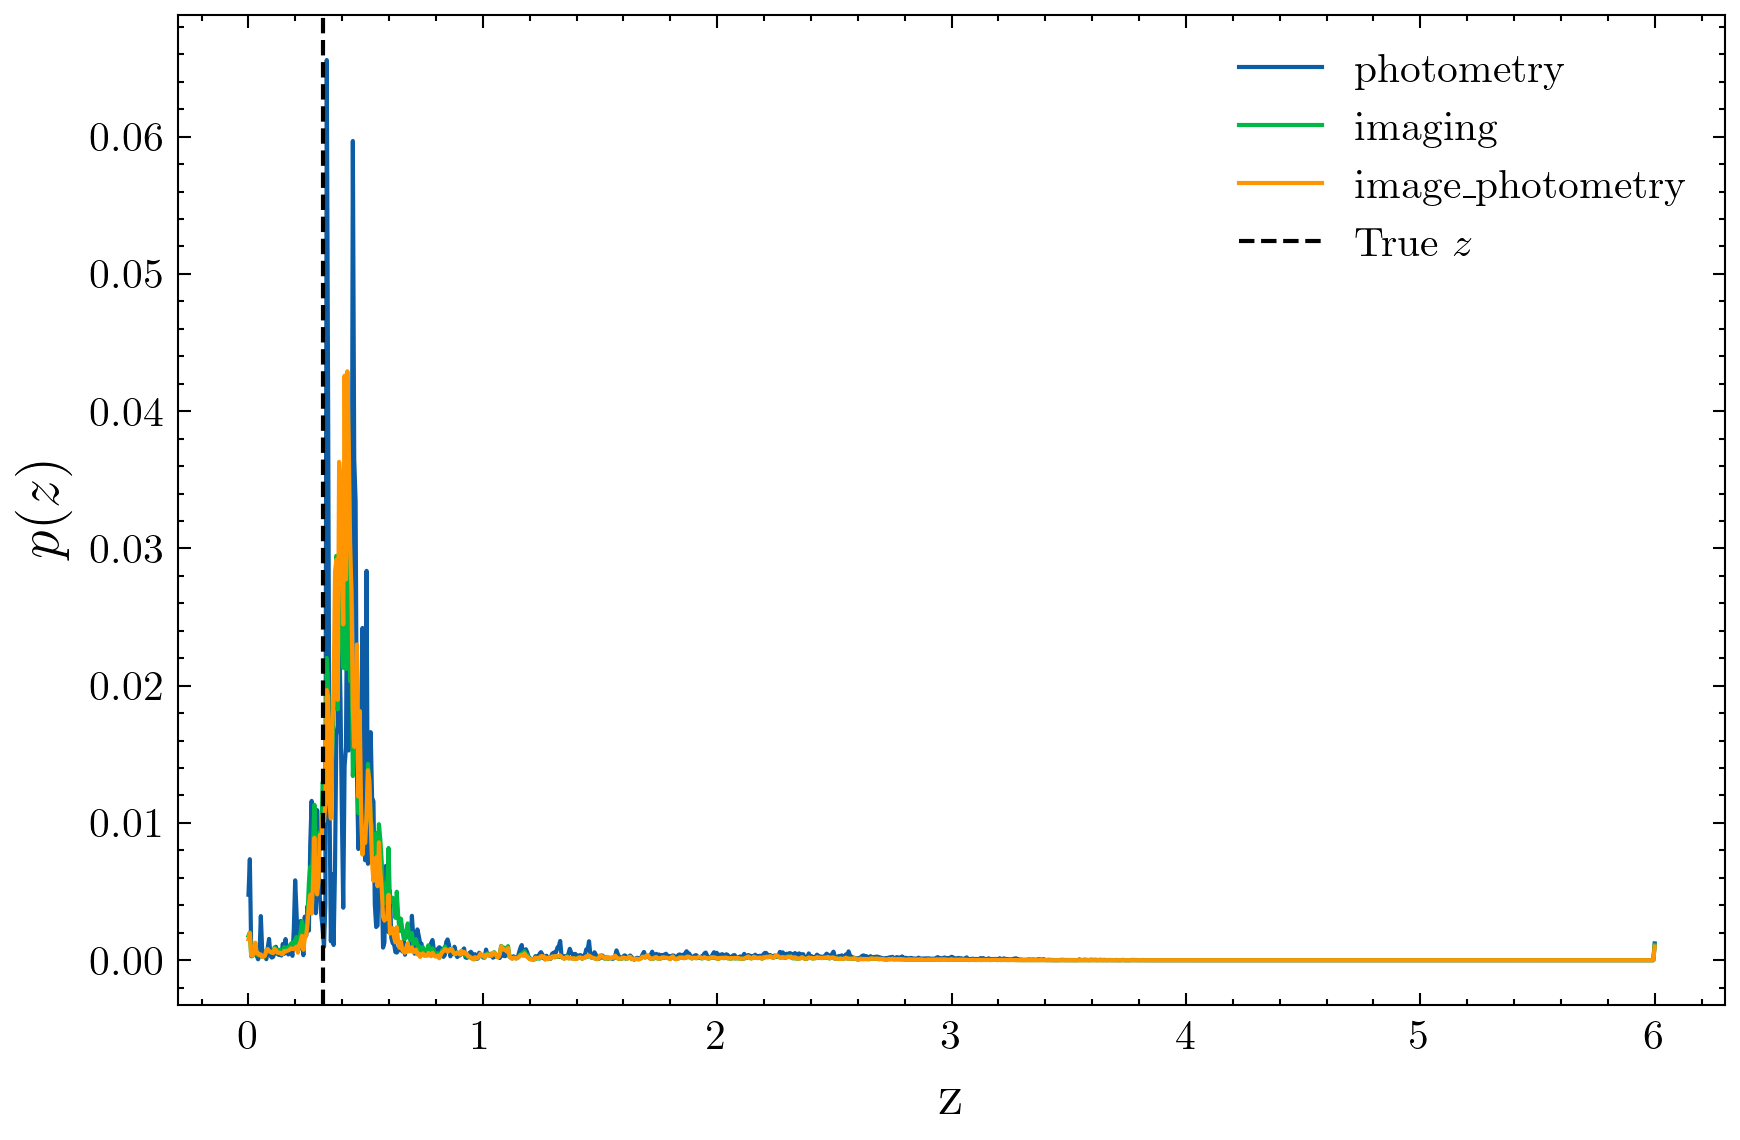

------------------------------------------------


In [44]:
plot_z_dist(
    check_df,
    table_sorted,
    names,
    tok_z_p,
    ascending=True 
)

Let's look at the galaxies best constrained using an image. These tend to have poor photometry.

In [51]:
threshold = 30 #1.05 # threshold at -10

#print(df.loc[(df["ratio_p_ip"] < threshold) == True])

# 2) Filter rows
mask = df["ratio_p_ip"] >= threshold
check_df = df.loc[mask].copy()

# 3a) Option A: add a rank column (1 = highest diff)
check_df["ratio_p_ip_rank"] = check_df["ratio_p_ip"].rank(ascending=False, method="dense")

# 3b) Option B: sort by the difference
check_df = check_df.sort_values("ratio_p_ip", ascending=False)

<Table length=1>
     TARGETID        sSFR        LOG_MSTAR      legacysurvey_EBV   desi_Z 
      int64        float32        float64           float32       float32 
----------------- ---------- ------------------ ---------------- ---------
39627751560320350 -10.173411 11.804136276245117      0.021579899 0.5872443

Z                                     23.039726
Photometry                           467.478973
Imaging                               16.593487
Spectroscopy                           1.038125
Image + Photometry                     8.221235
Image + Spectrum                       0.956426
Image + Spectrum + Photometry          0.916009
Image + Spectrum + Photometry + Z      0.826600
ratio_p_ip                            56.862377
ratio_p_ip_rank                        1.000000
Name: 226, dtype: float64

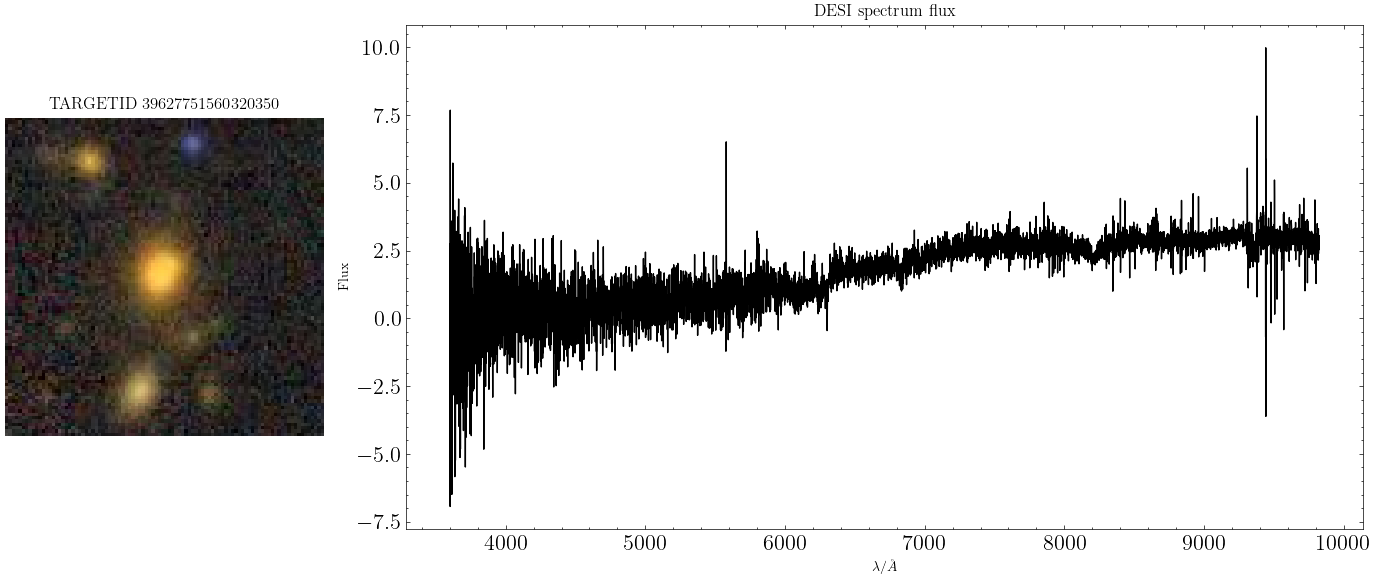

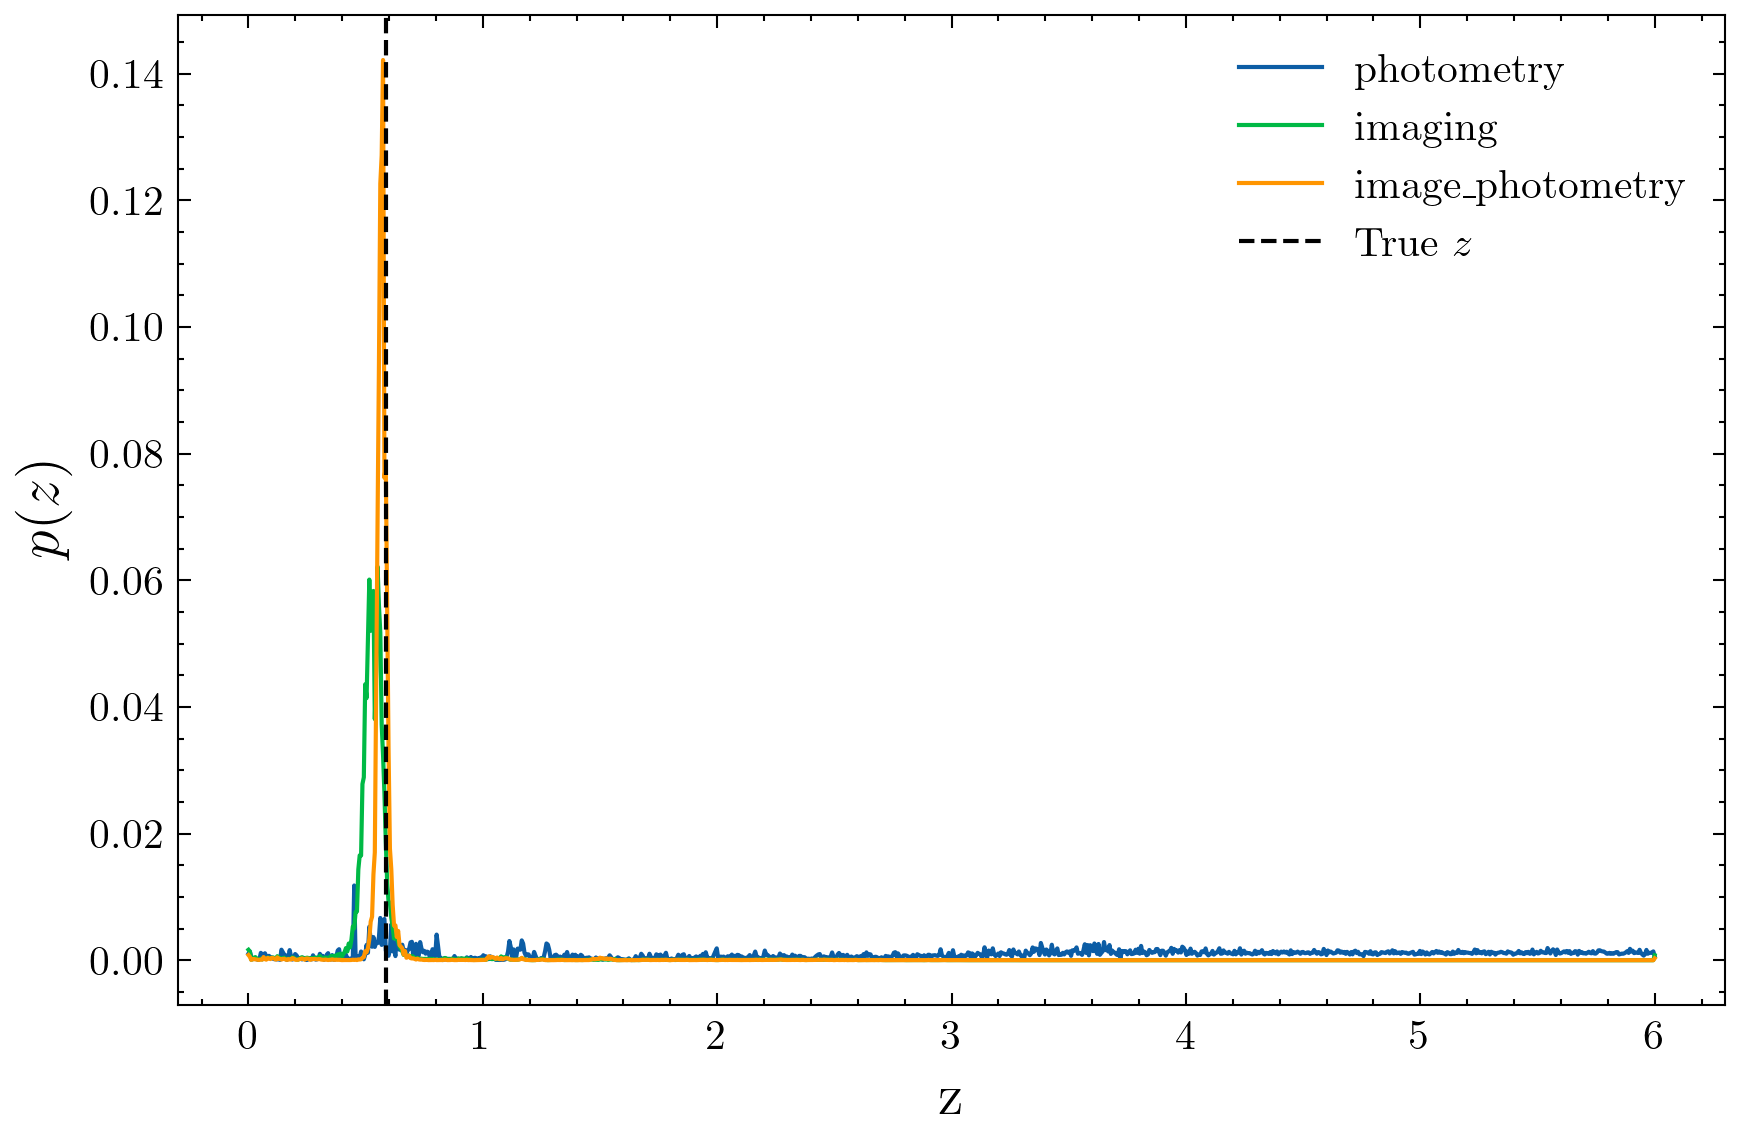

------------------------------------------------


<Table length=1>
     TARGETID        sSFR        LOG_MSTAR      legacysurvey_EBV   desi_Z  
      int64        float32        float64           float32       float32  
----------------- ---------- ------------------ ---------------- ----------
39627811958295632 -12.419126 10.644575119018555      0.032959666 0.12508689

Z                                     22.736189
Photometry                           680.200562
Imaging                               21.077564
Spectroscopy                           5.061102
Image + Photometry                    17.381340
Image + Spectrum                       5.019732
Image + Spectrum + Photometry          5.014812
Image + Spectrum + Photometry + Z      5.047941
ratio_p_ip                            39.133953
ratio_p_ip_rank                        2.000000
Name: 2313, dtype: float64

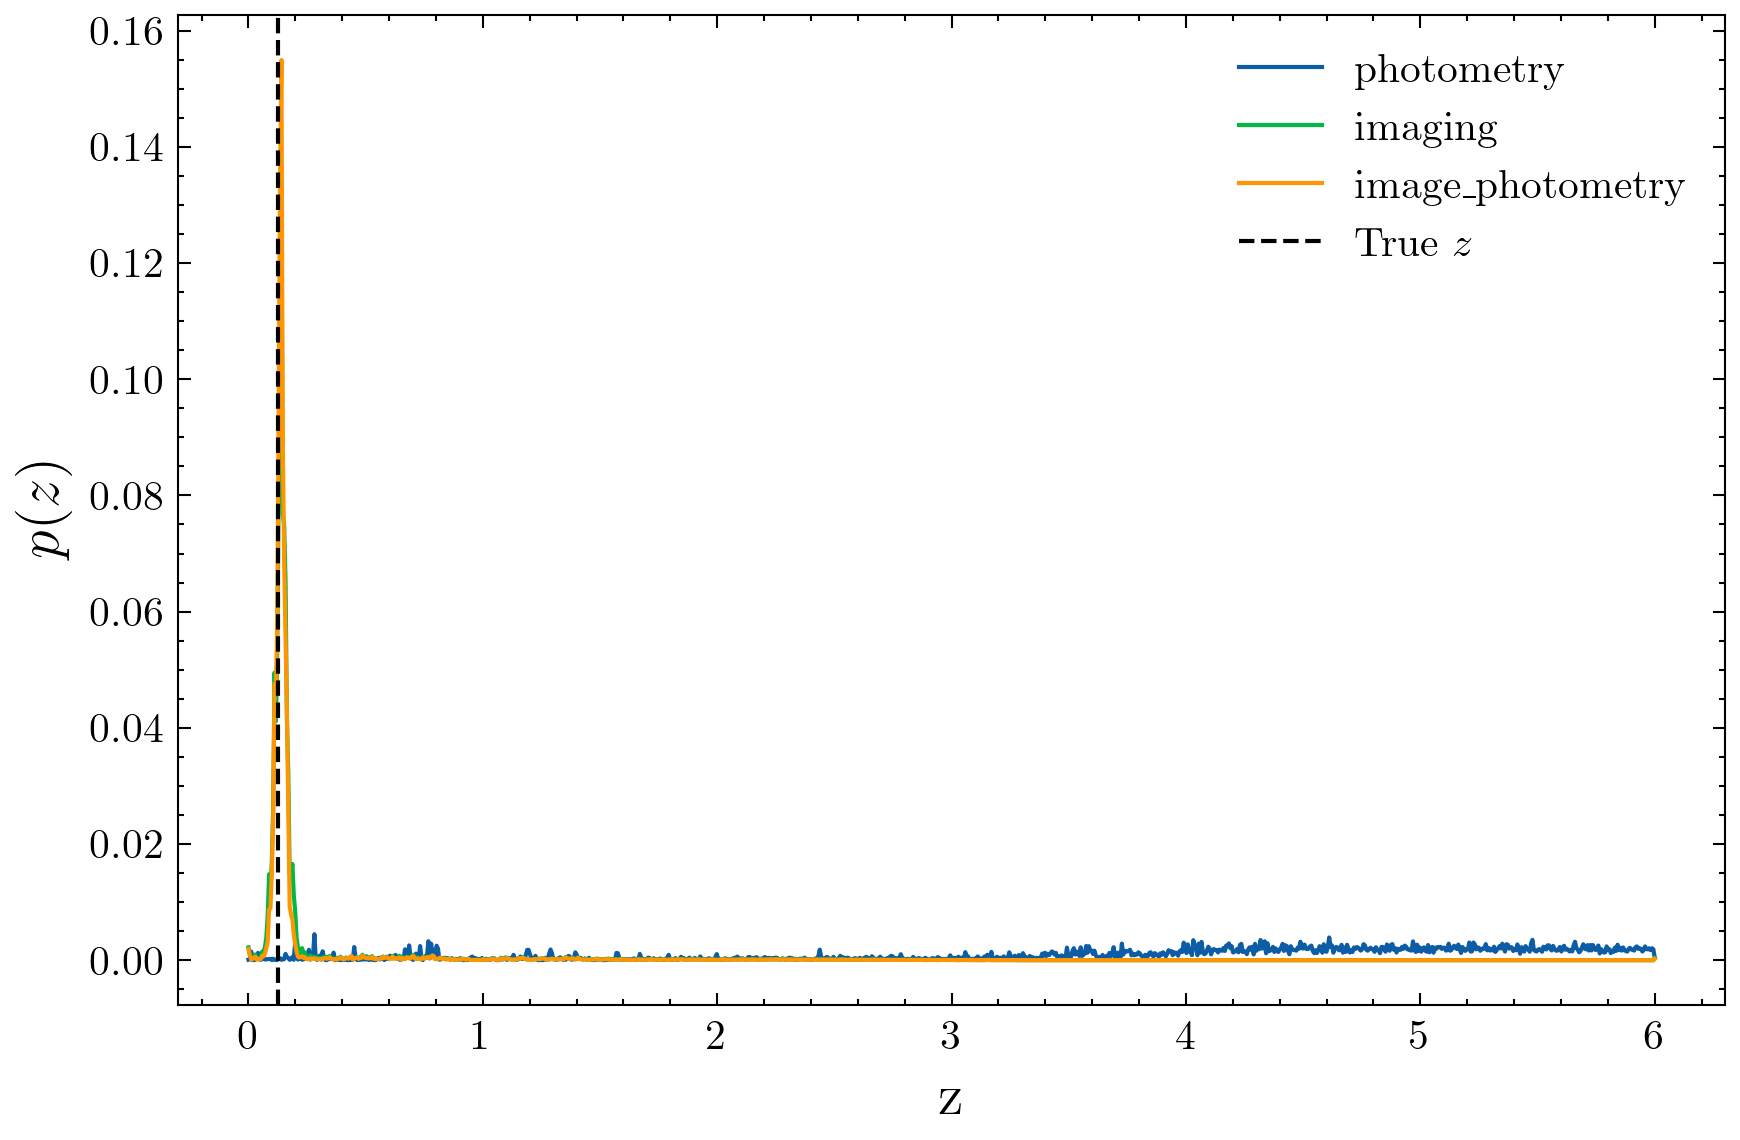

------------------------------------------------


<Table length=1>
     TARGETID        sSFR        LOG_MSTAR      legacysurvey_EBV   desi_Z  
      int64        float32        float64           float32       float32  
----------------- ---------- ------------------ ---------------- ----------
39627781717363782 -14.578751 10.597193717956543      0.023749094 0.11771579

Z                                     22.405321
Photometry                           681.187866
Imaging                               21.736849
Spectroscopy                           5.115474
Image + Photometry                    17.812706
Image + Spectrum                       5.101497
Image + Spectrum + Photometry          5.062040
Image + Spectrum + Photometry + Z      5.118735
ratio_p_ip                            38.241684
ratio_p_ip_rank                        3.000000
Name: 3561, dtype: float64

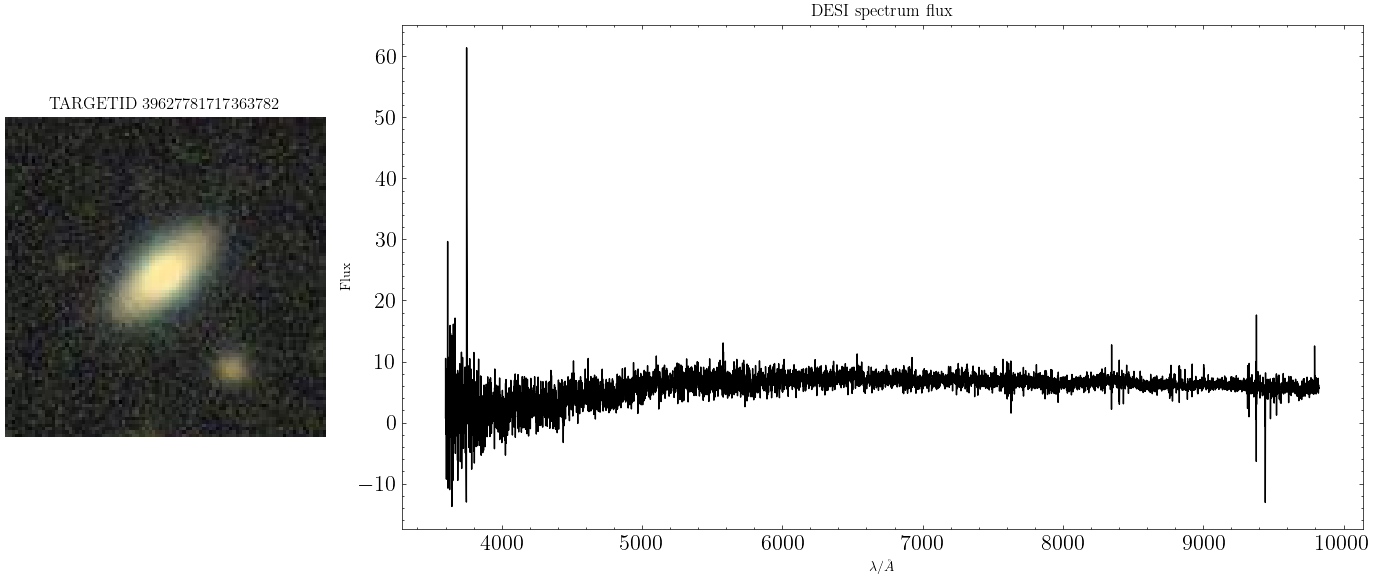

------------------------------------------------


<Table length=1>
     TARGETID        sSFR        LOG_MSTAR      legacysurvey_EBV   desi_Z  
      int64        float32        float64           float32       float32  
----------------- ---------- ------------------ ---------------- ----------
39627775694342667 -10.615402 10.500448226928711      0.018510567 0.12997773

Z                                     23.321732
Photometry                           683.679810
Imaging                               18.985075
Spectroscopy                           5.053453
Image + Photometry                    17.887402
Image + Spectrum                       5.026475
Image + Spectrum + Photometry          5.027157
Image + Spectrum + Photometry + Z      5.029314
ratio_p_ip                            38.221302
ratio_p_ip_rank                        4.000000
Name: 3432, dtype: float64

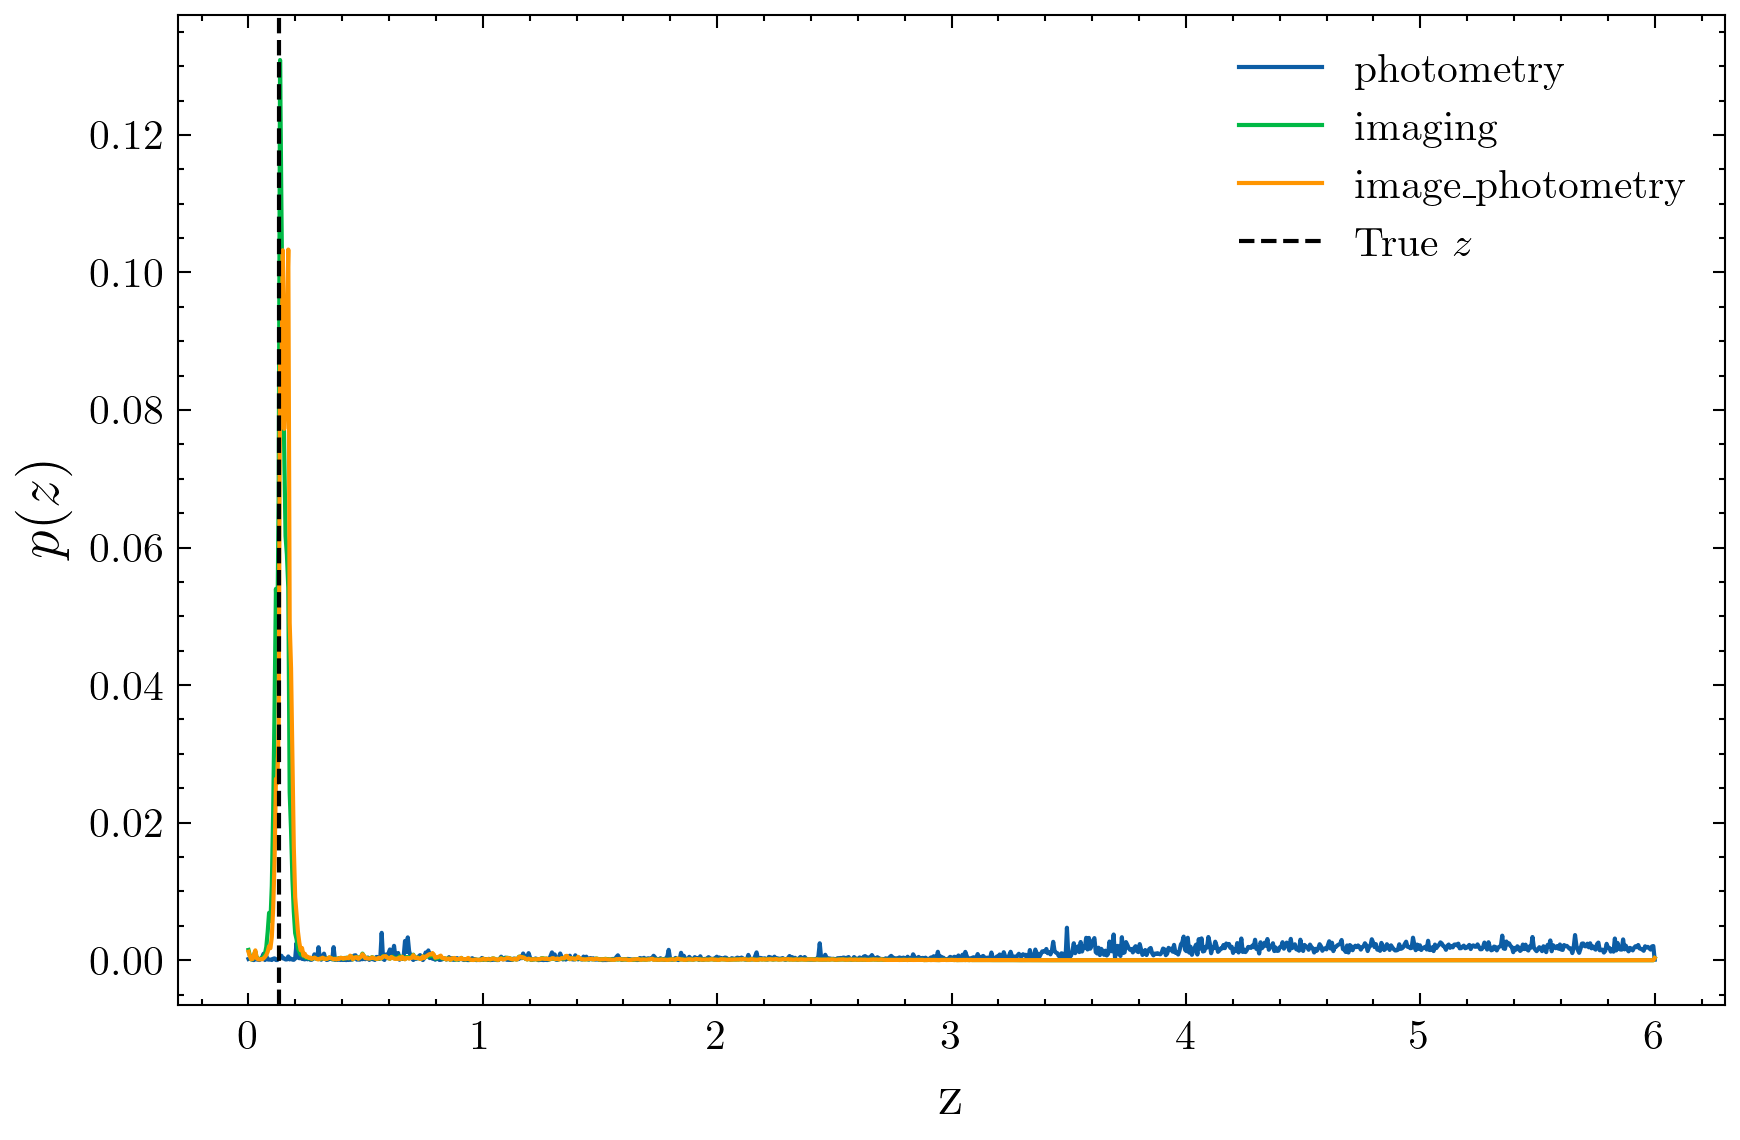

------------------------------------------------


<Table length=1>
     TARGETID        sSFR        LOG_MSTAR      legacysurvey_EBV   desi_Z  
      int64        float32        float64           float32       float32  
----------------- ---------- ------------------ ---------------- ----------
39627811949907112 -10.992169 10.084025382995605      0.027940487 0.07735763

Z                                     11.538372
Photometry                           654.107178
Imaging                               19.565605
Spectroscopy                           3.028936
Image + Photometry                    19.416418
Image + Spectrum                       3.026615
Image + Spectrum + Photometry          3.027451
Image + Spectrum + Photometry + Z      3.054901
ratio_p_ip                            33.688354
ratio_p_ip_rank                        5.000000
Name: 2175, dtype: float64

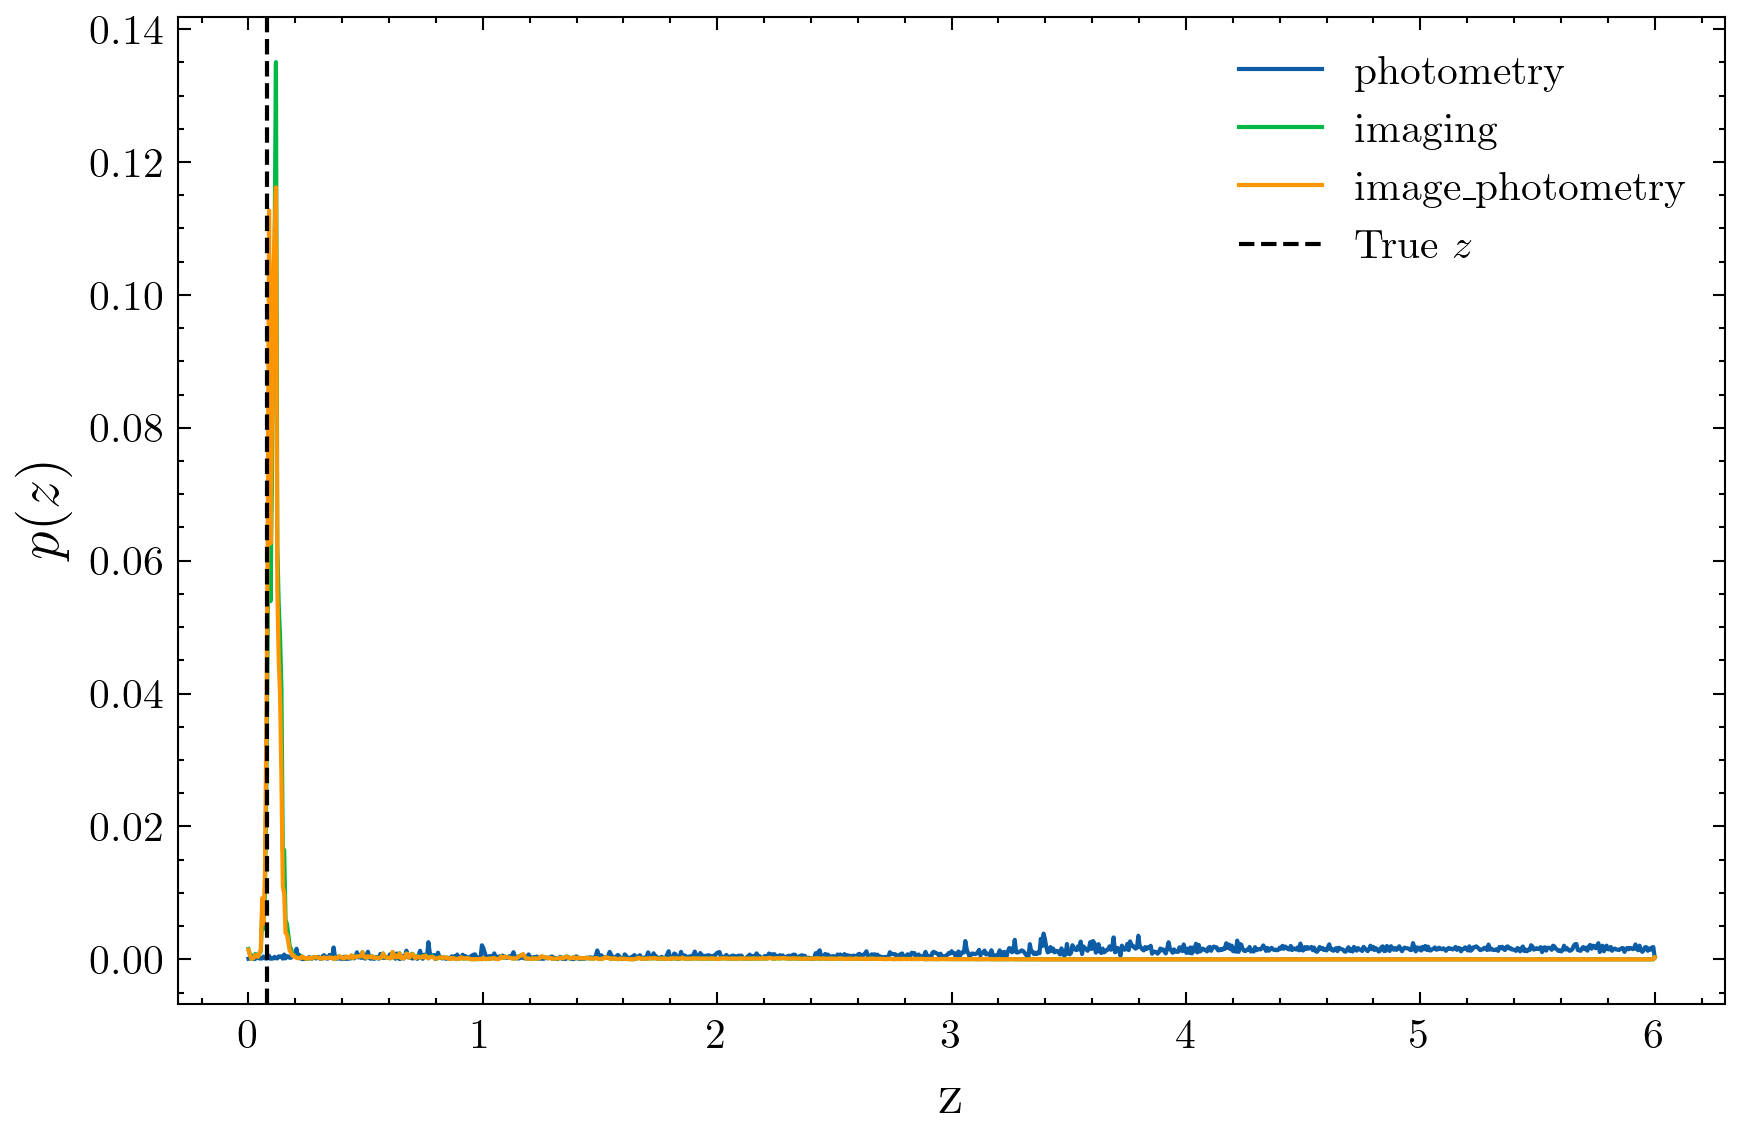

------------------------------------------------


<Table length=1>
     TARGETID        sSFR       LOG_MSTAR      legacysurvey_EBV   desi_Z  
      int64        float32       float64           float32       float32  
----------------- --------- ------------------ ---------------- ----------
39627745516323660 -12.43341 10.574719429016113      0.019742023 0.11088043

Z                                     27.196827
Photometry                           671.725525
Imaging                               21.189070
Spectroscopy                           0.124601
Image + Photometry                    20.029400
Image + Spectrum                       0.072797
Image + Spectrum + Photometry          0.081633
Image + Spectrum + Photometry + Z      0.086409
ratio_p_ip                            33.536976
ratio_p_ip_rank                        6.000000
Name: 1, dtype: float64

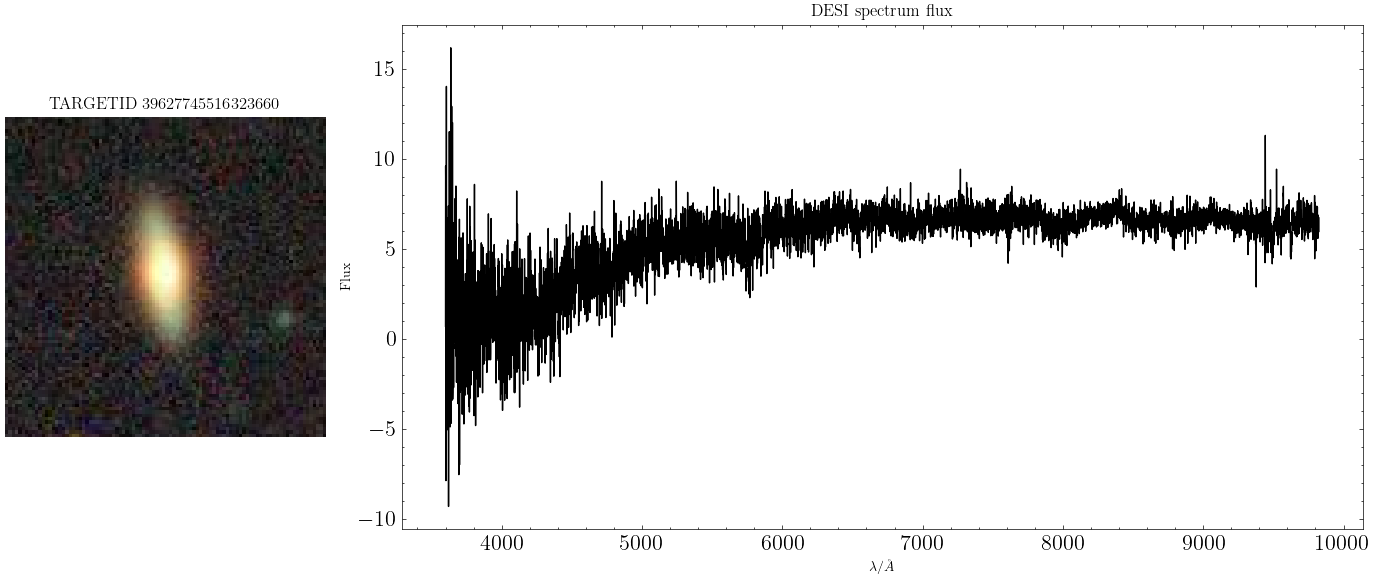

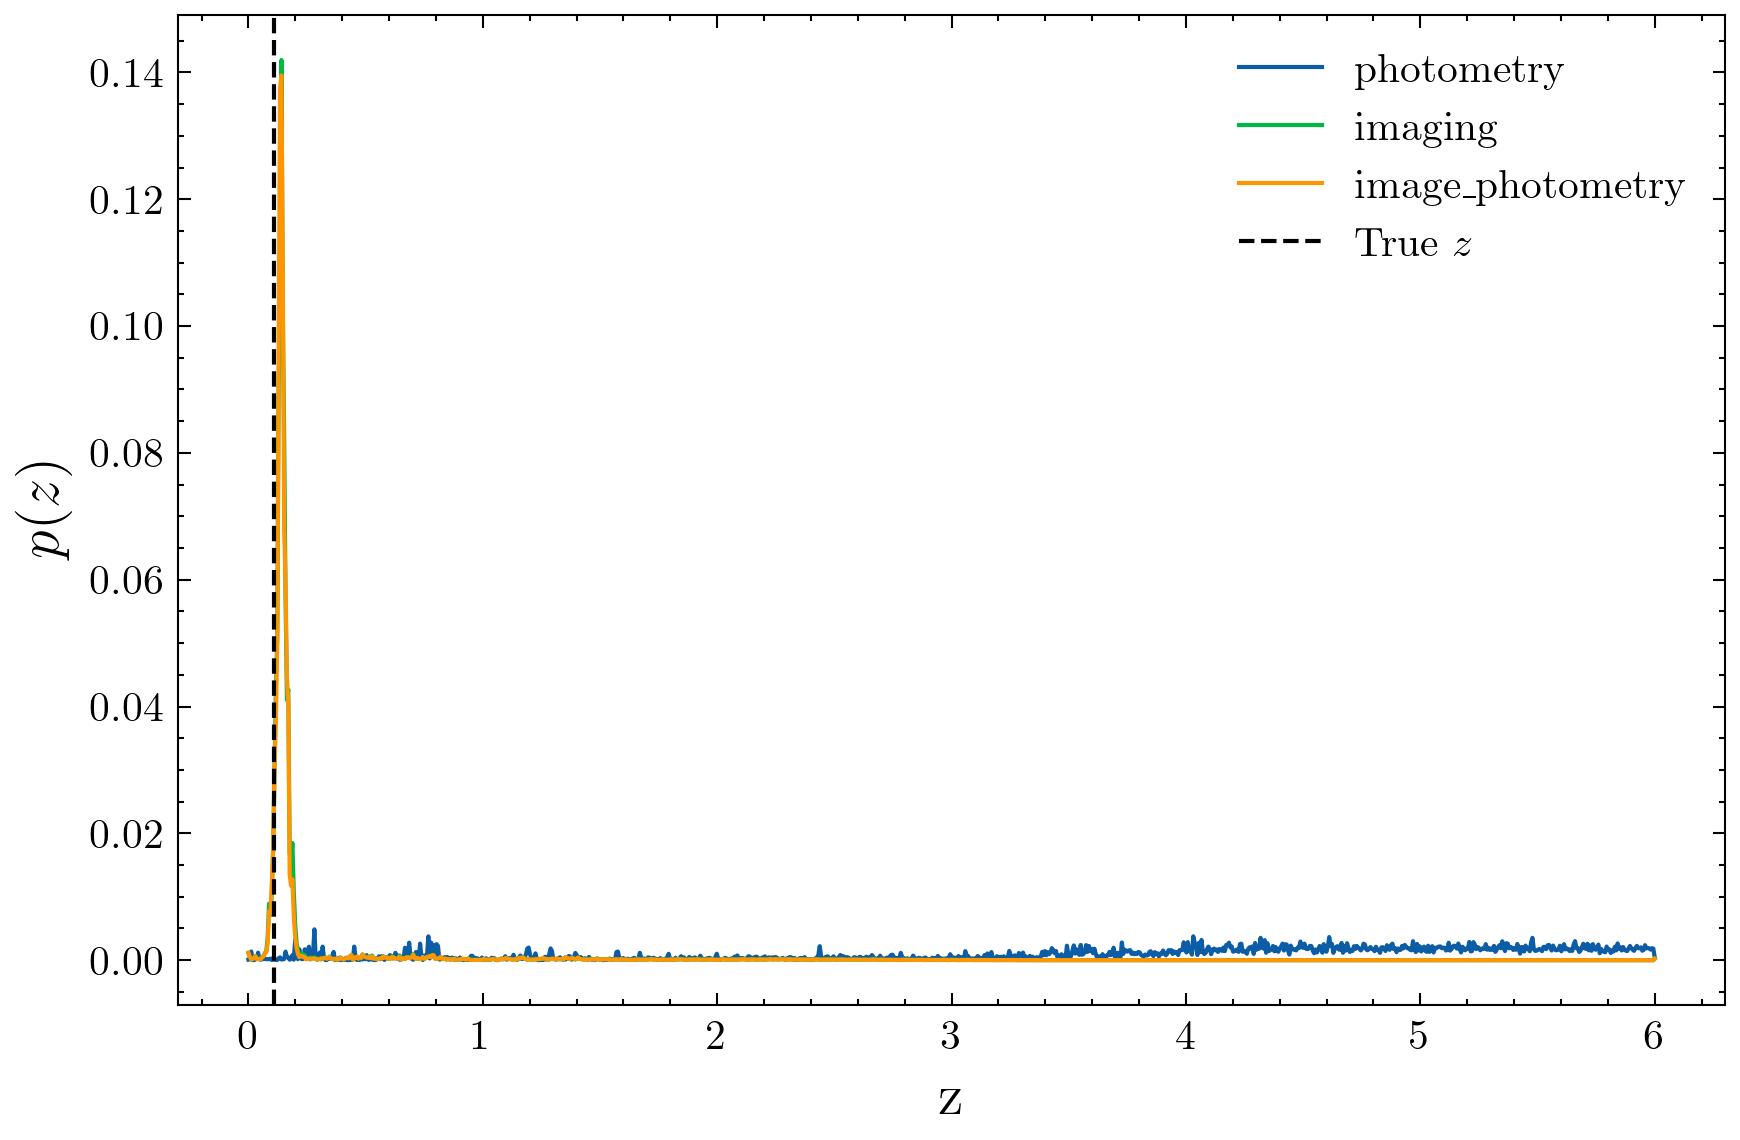

------------------------------------------------


<Table length=1>
     TARGETID        sSFR        LOG_MSTAR      legacysurvey_EBV   desi_Z  
      int64        float32        float64           float32       float32  
----------------- ---------- ------------------ ---------------- ----------
39627799870310414 -11.827604 11.071928024291992      0.028510418 0.17117499

Z                                     19.926598
Photometry                           532.614075
Imaging                               19.424854
Spectroscopy                           8.013542
Image + Photometry                    16.084394
Image + Spectrum                       8.006916
Image + Spectrum + Photometry          8.003691
Image + Spectrum + Photometry + Z      8.009458
ratio_p_ip                            33.113716
ratio_p_ip_rank                        7.000000
Name: 1475, dtype: float64

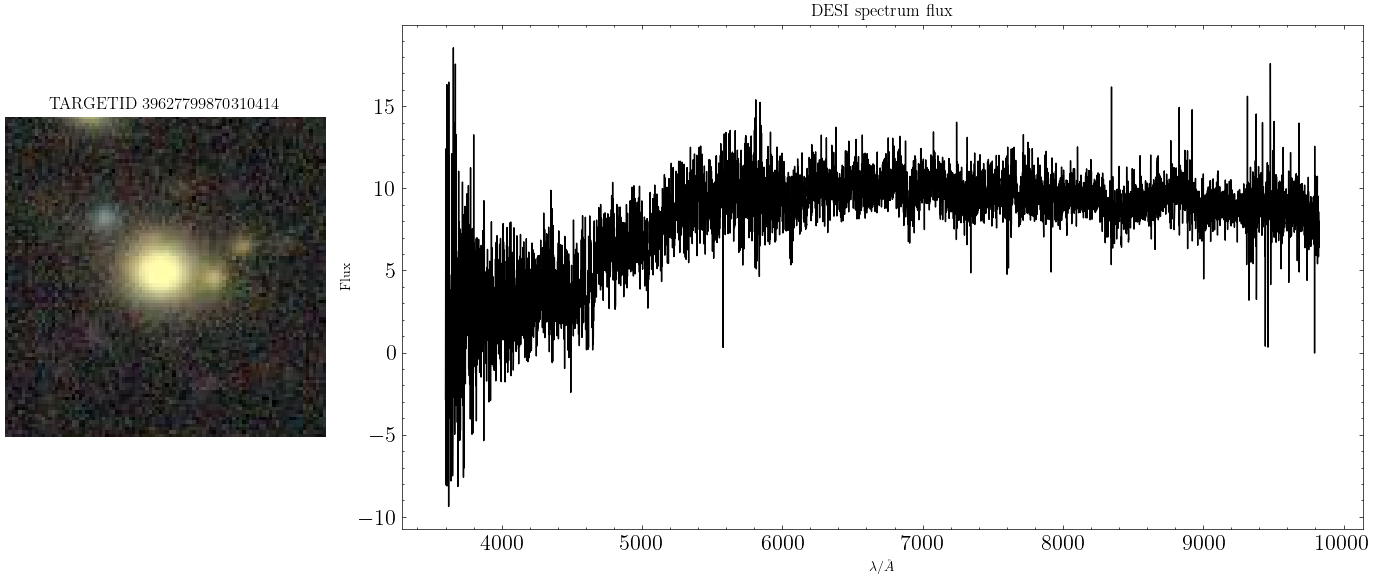

------------------------------------------------


<Table length=1>
     TARGETID        sSFR        LOG_MSTAR      legacysurvey_EBV   desi_Z  
      int64        float32        float64           float32       float32  
----------------- ---------- ------------------ ---------------- ----------
39627787799103283 -11.826982 10.415369987487793      0.024119804 0.12294062

Z                                     26.318655
Photometry                           654.229553
Imaging                               21.272026
Spectroscopy                           9.914809
Image + Photometry                    19.844881
Image + Spectrum                       9.923791
Image + Spectrum + Photometry          9.948422
Image + Spectrum + Photometry + Z     10.013071
ratio_p_ip                            32.967171
ratio_p_ip_rank                        8.000000
Name: 602, dtype: float64

------------------------------------------------


<Table length=1>
     TARGETID        sSFR        LOG_MSTAR      legacysurvey_EBV    desi_Z  
      int64        float32        float64           float32        float32  
----------------- ---------- ------------------ ---------------- -----------
39627793822125482 -11.302694 10.640060424804688      0.024227265 0.120204024

Z                                     21.519522
Photometry                           662.668579
Imaging                               19.993332
Spectroscopy                           3.065026
Image + Photometry                    20.222084
Image + Spectrum                       3.022728
Image + Spectrum + Photometry          3.020695
Image + Spectrum + Photometry + Z      3.036937
ratio_p_ip                            32.769550
ratio_p_ip_rank                        9.000000
Name: 901, dtype: float64

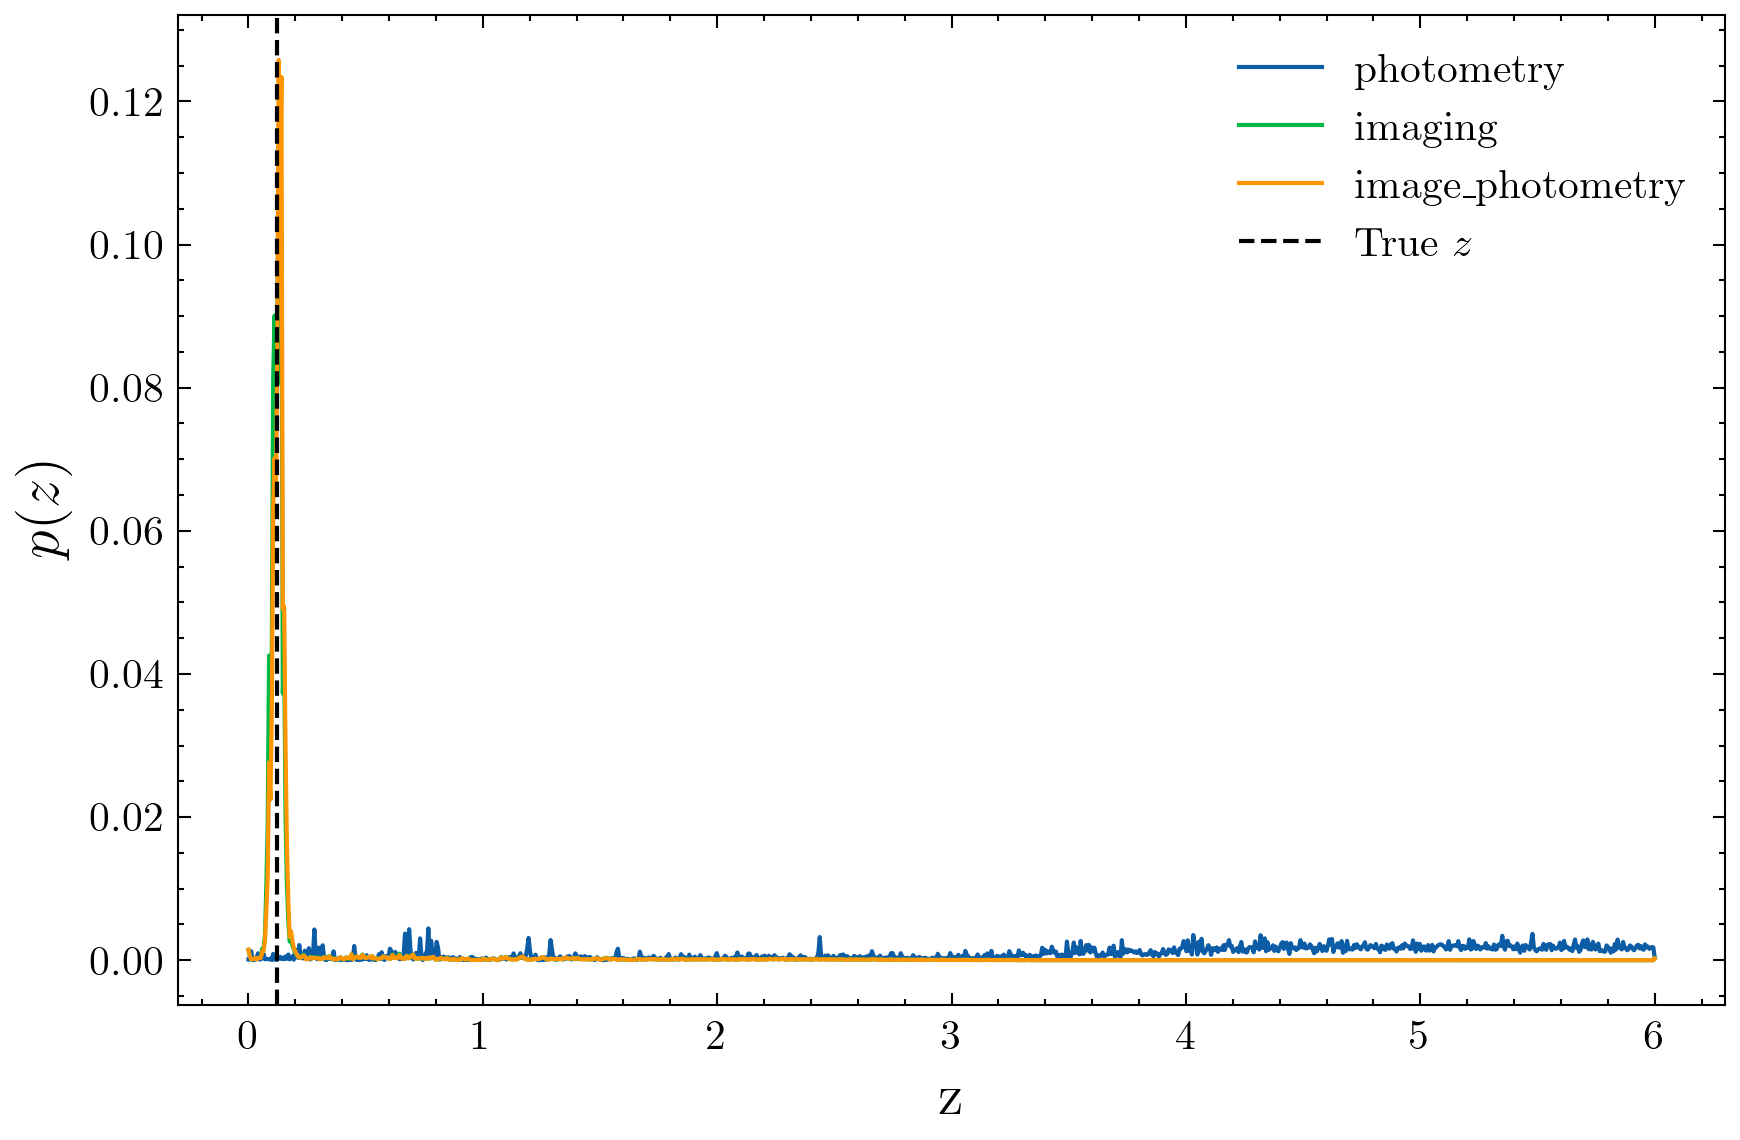

------------------------------------------------


<Table length=1>
     TARGETID         sSFR        LOG_MSTAR      legacysurvey_EBV   desi_Z  
      int64         float32        float64           float32       float32  
----------------- ----------- ------------------ ---------------- ----------
39627757612700301 -10.3131075 10.080437660217285      0.022072531 0.08529387

Z                                     15.138192
Photometry                           642.534424
Imaging                               19.423712
Spectroscopy                           1.099199
Image + Photometry                    20.241251
Image + Spectrum                       1.032001
Image + Spectrum + Photometry          1.029065
Image + Spectrum + Photometry + Z      1.029553
ratio_p_ip                            31.743811
ratio_p_ip_rank                       10.000000
Name: 2927, dtype: float64

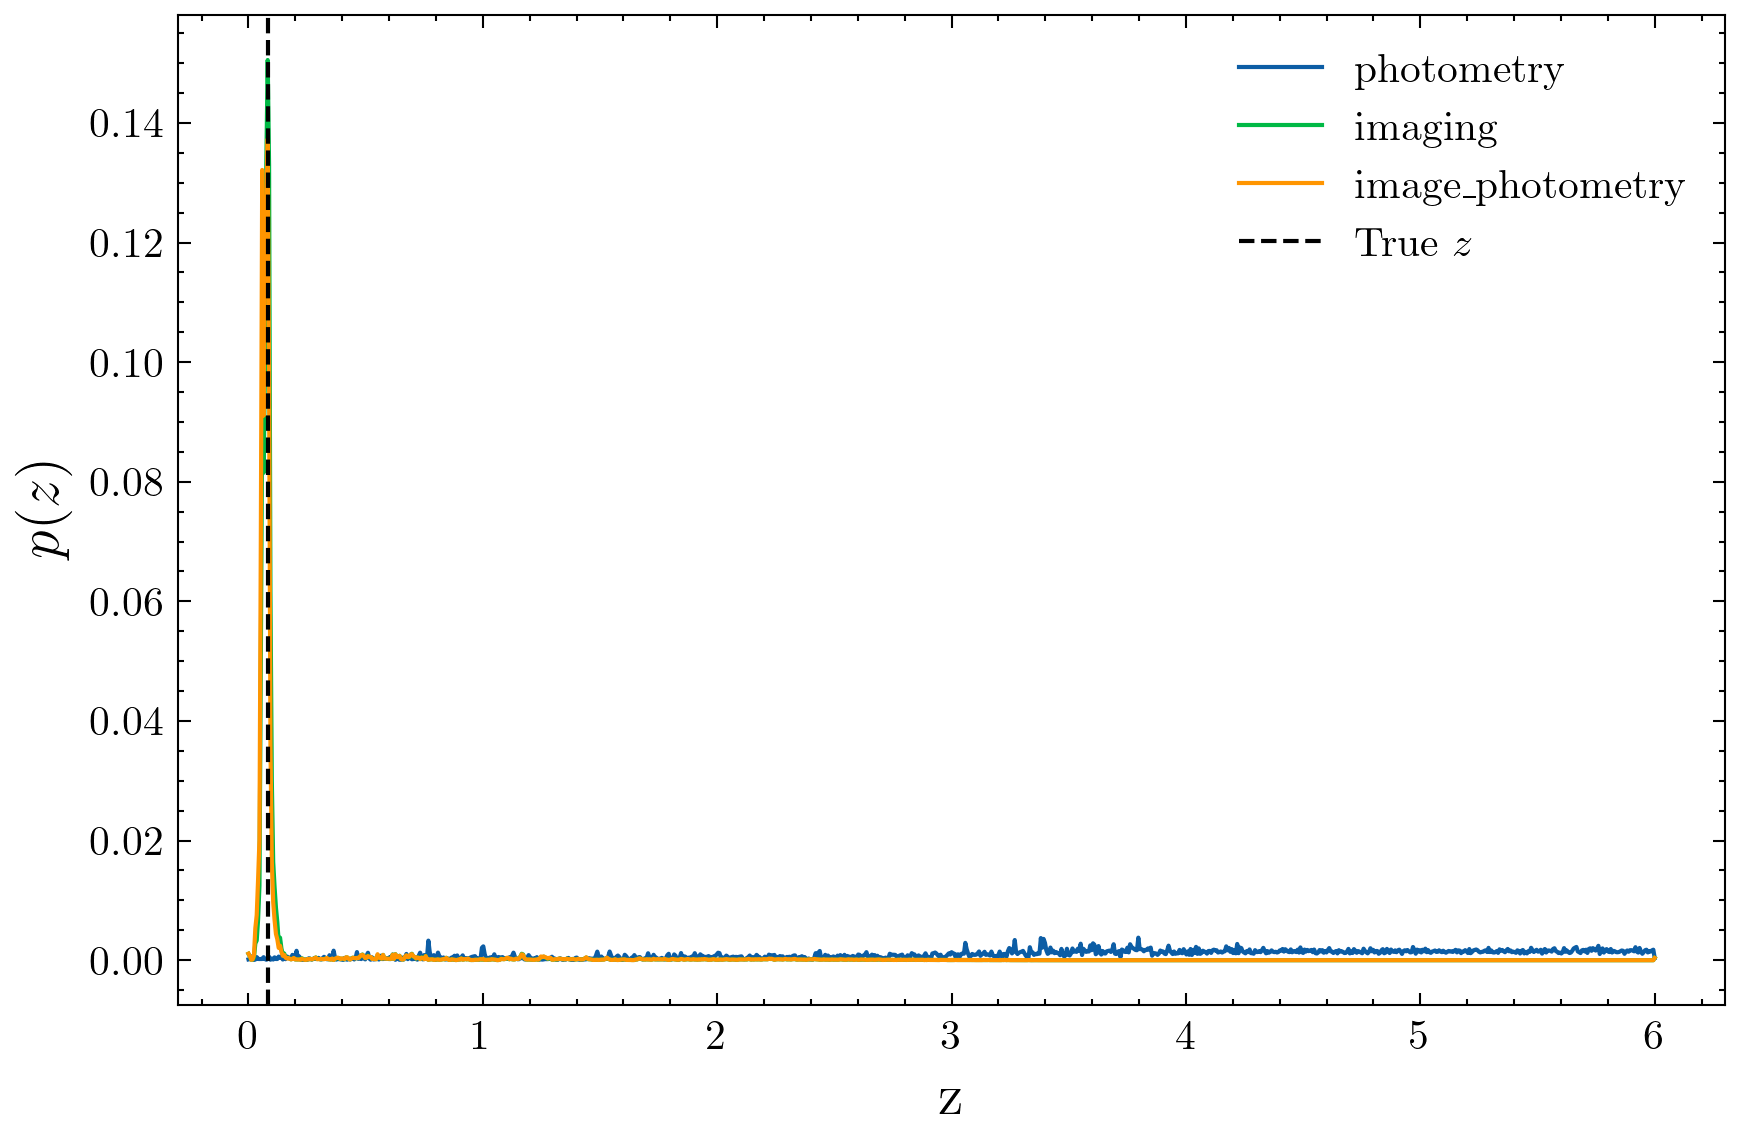

------------------------------------------------


<Table length=1>
     TARGETID        sSFR        LOG_MSTAR      legacysurvey_EBV   desi_Z  
      int64        float32        float64           float32       float32  
----------------- ---------- ------------------ ---------------- ----------
39627793830512668 -10.327908 10.592900276184082      0.023035321 0.12517767

Z                                     25.070797
Photometry                           706.771240
Imaging                               22.129559
Spectroscopy                           8.161075
Image + Photometry                    22.468876
Image + Spectrum                       8.029634
Image + Spectrum + Photometry          8.026213
Image + Spectrum + Photometry + Z      8.050388
ratio_p_ip                            31.455568
ratio_p_ip_rank                       11.000000
Name: 974, dtype: float64

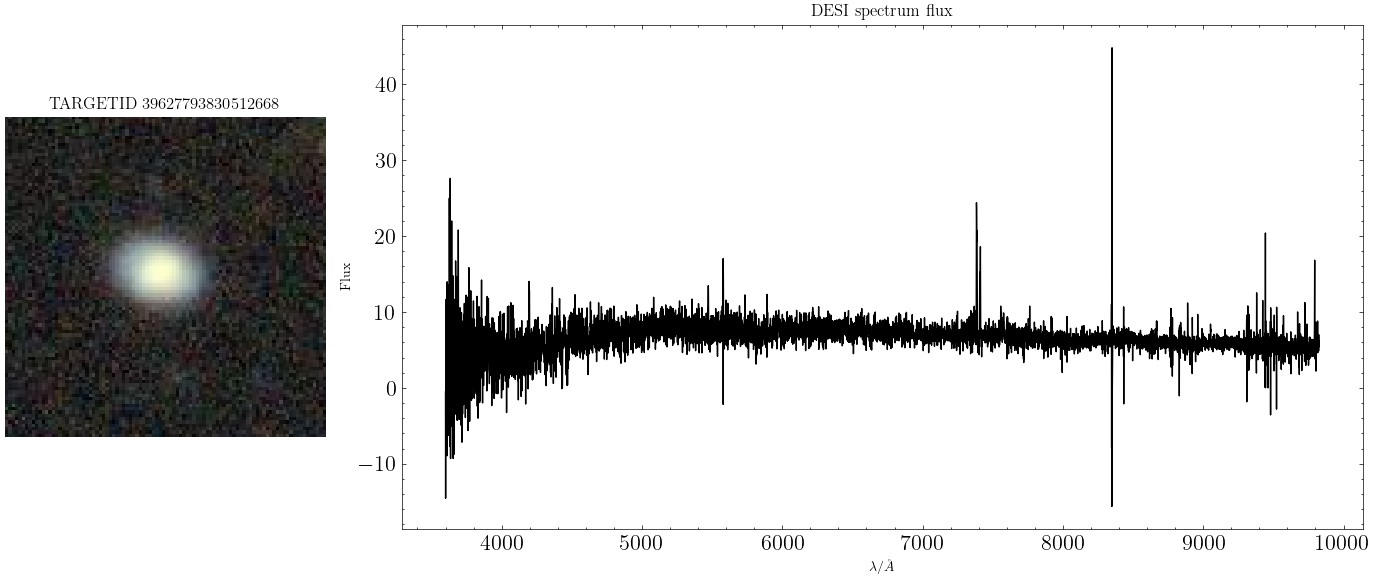

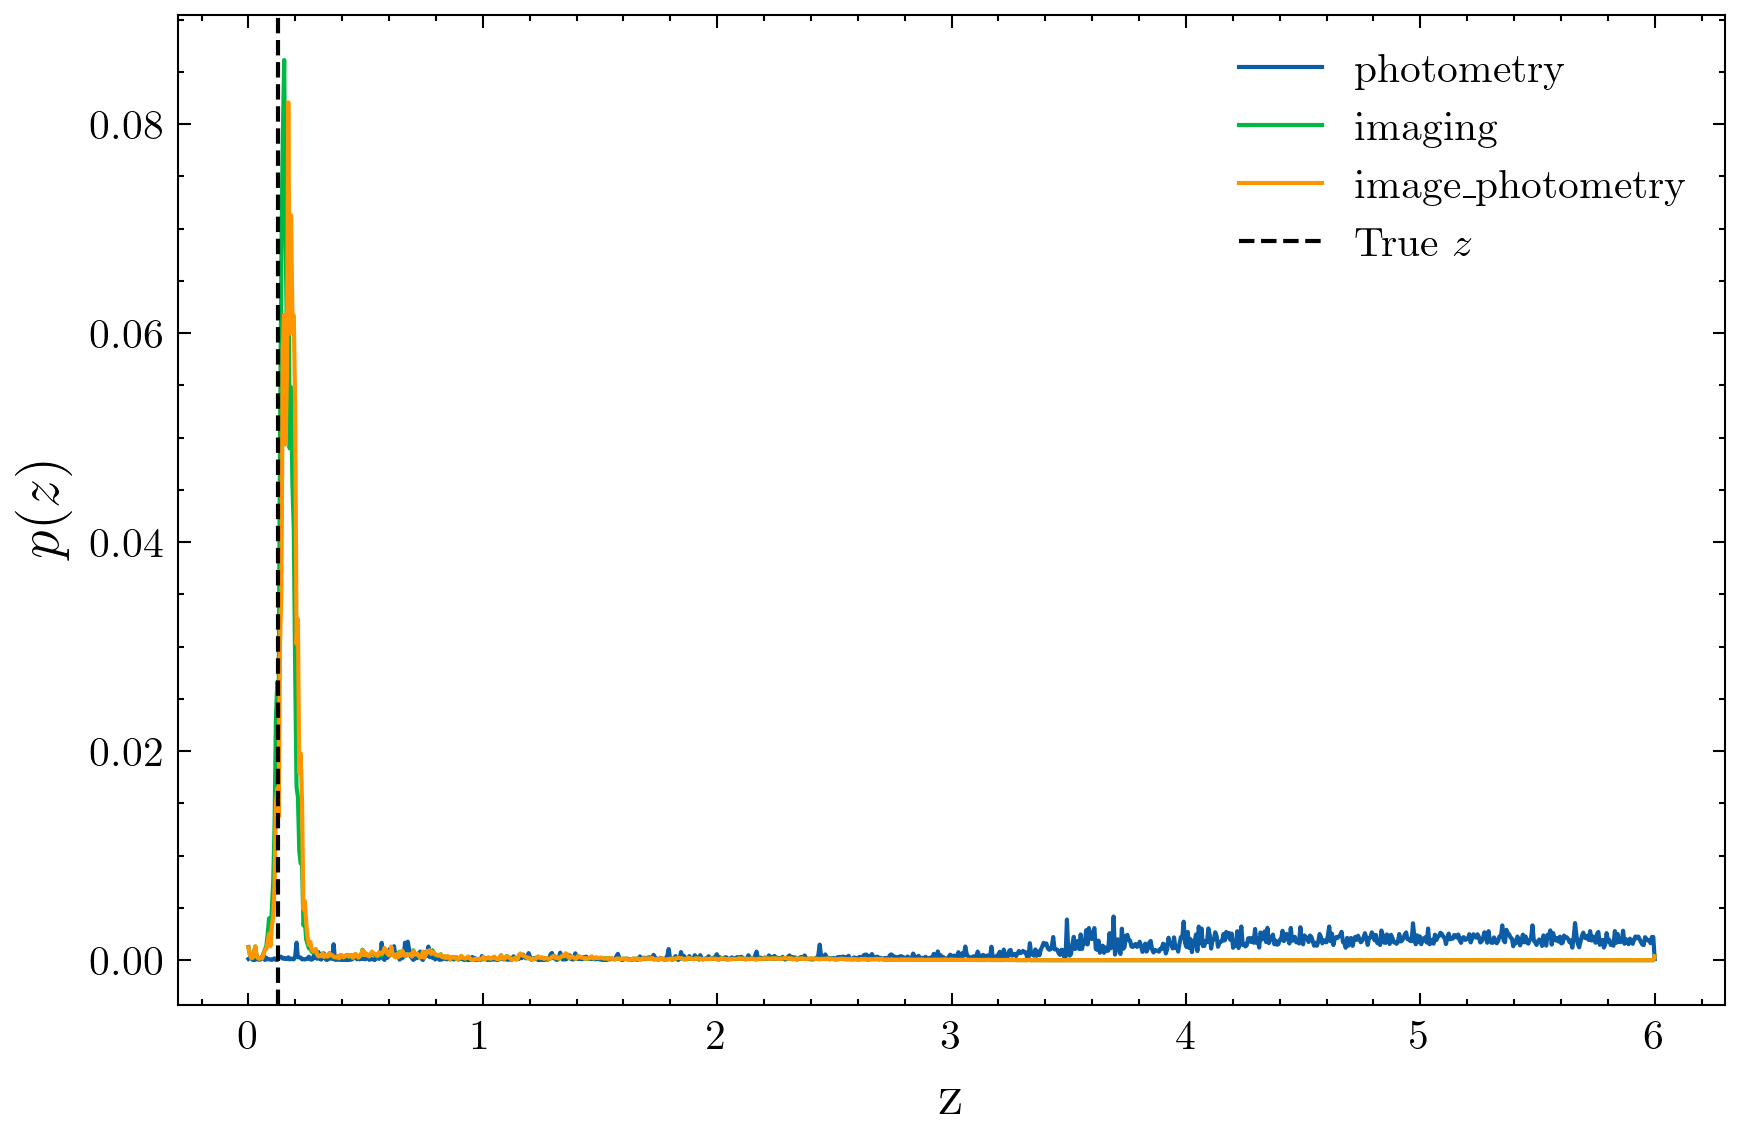

------------------------------------------------


<Table length=1>
     TARGETID        sSFR        LOG_MSTAR      legacysurvey_EBV   desi_Z  
      int64        float32        float64           float32       float32  
----------------- ---------- ------------------ ---------------- ----------
39627793822123244 -10.866632 10.536109924316406      0.022988161 0.11599333

Z                                     27.041182
Photometry                           566.937744
Imaging                               18.295740
Spectroscopy                           2.025919
Image + Photometry                    18.232527
Image + Spectrum                       2.024416
Image + Spectrum + Photometry          2.021910
Image + Spectrum + Photometry + Z      2.019832
ratio_p_ip                            31.094852
ratio_p_ip_rank                       12.000000
Name: 886, dtype: float64

------------------------------------------------


<Table length=1>
     TARGETID        sSFR        LOG_MSTAR     legacysurvey_EBV    desi_Z  
      int64        float32        float64          float32        float32  
----------------- ---------- ----------------- ---------------- -----------
39627763627332807 -11.891513 9.763641357421875      0.020494394 0.059918877

Z                                     29.347345
Photometry                           619.103394
Imaging                               22.683041
Spectroscopy                           2.349637
Image + Photometry                    19.964300
Image + Spectrum                       3.114100
Image + Spectrum + Photometry          3.282841
Image + Spectrum + Photometry + Z      2.394597
ratio_p_ip                            31.010523
ratio_p_ip_rank                       13.000000
Name: 3083, dtype: float64

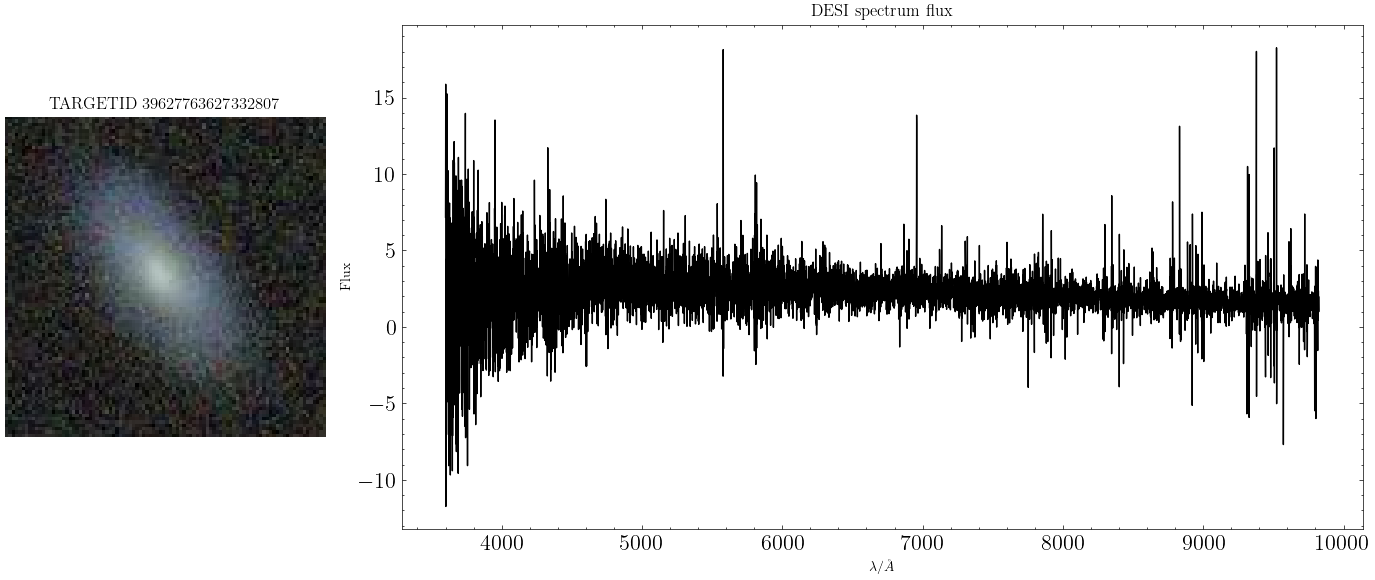

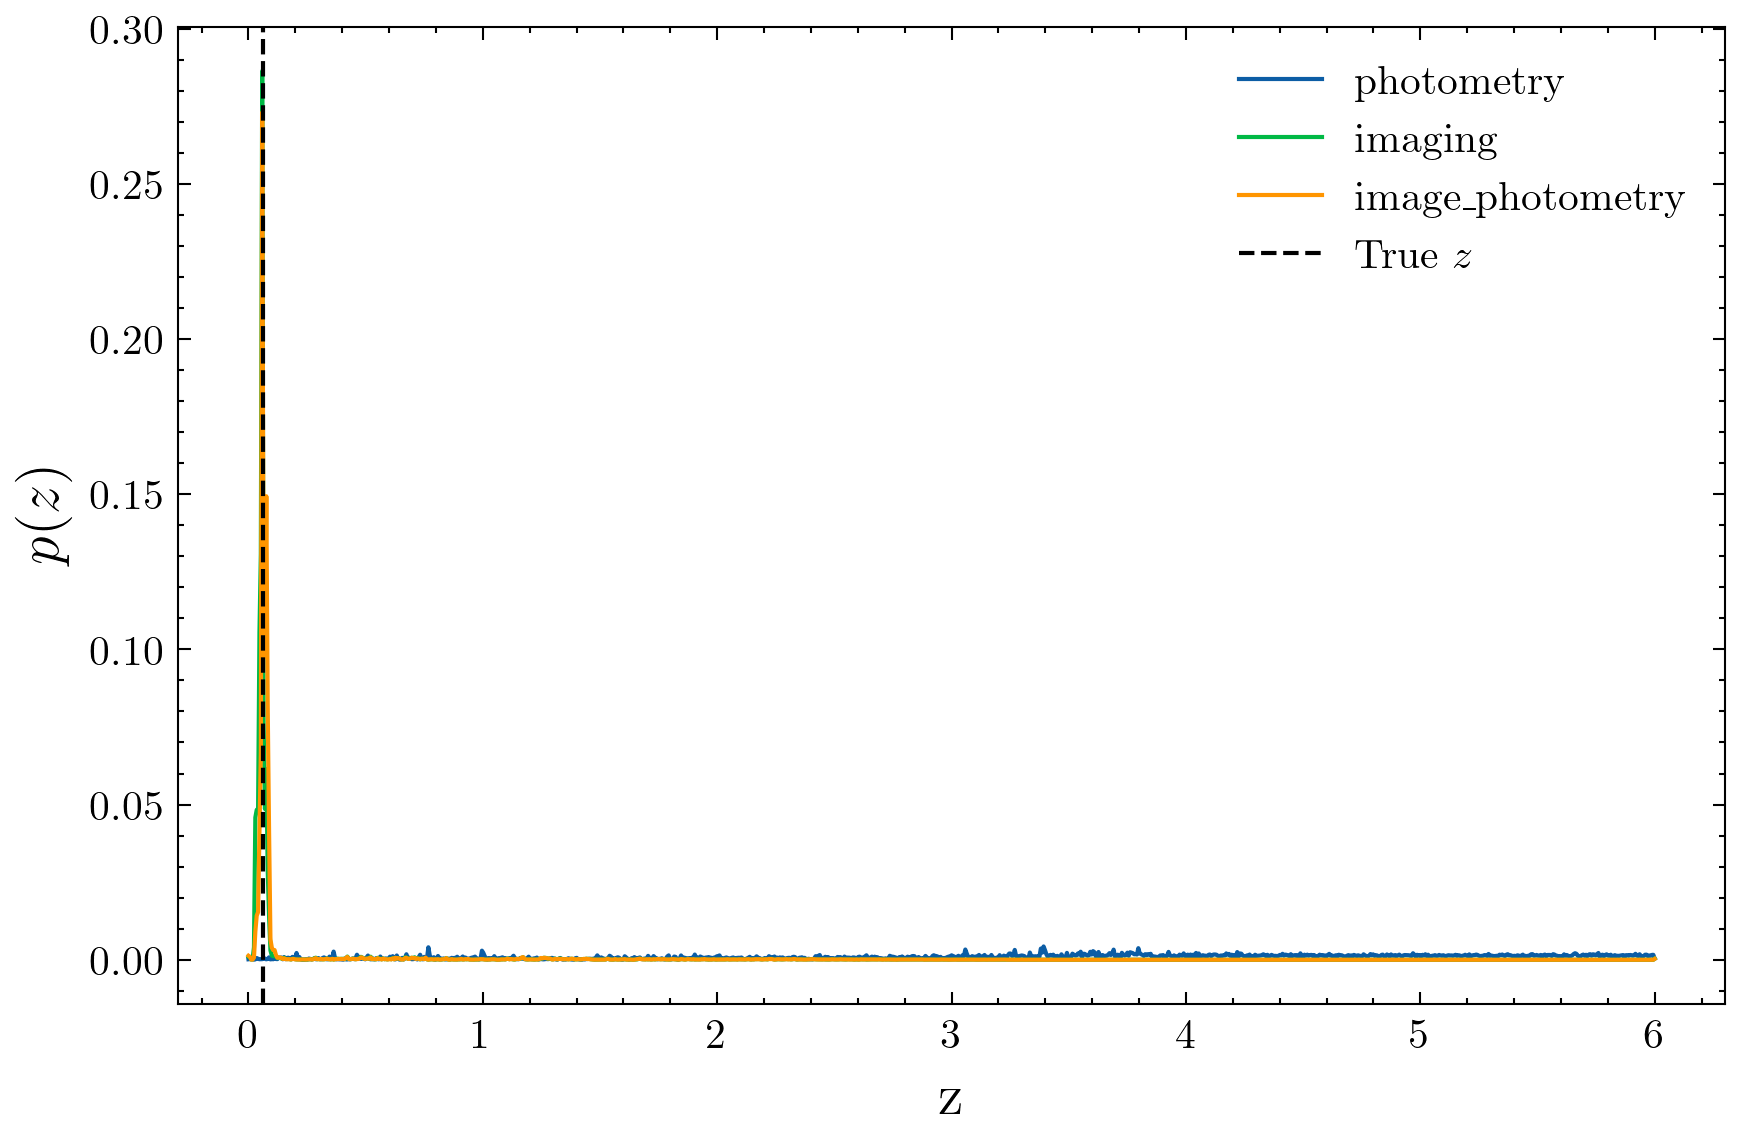

------------------------------------------------


<Table length=1>
     TARGETID       sSFR       LOG_MSTAR      legacysurvey_EBV   desi_Z  
      int64       float32       float64           float32       float32  
----------------- -------- ------------------ ---------------- ----------
39627799861923054 -9.30618 11.157918930053711      0.026512006 0.22307128

Z                                     35.833103
Photometry                           650.585388
Imaging                               21.013538
Spectroscopy                           6.902915
Image + Photometry                    21.095343
Image + Spectrum                       7.024793
Image + Spectrum + Photometry          6.984940
Image + Spectrum + Photometry + Z      6.859361
ratio_p_ip                            30.840239
ratio_p_ip_rank                       14.000000
Name: 1355, dtype: float64

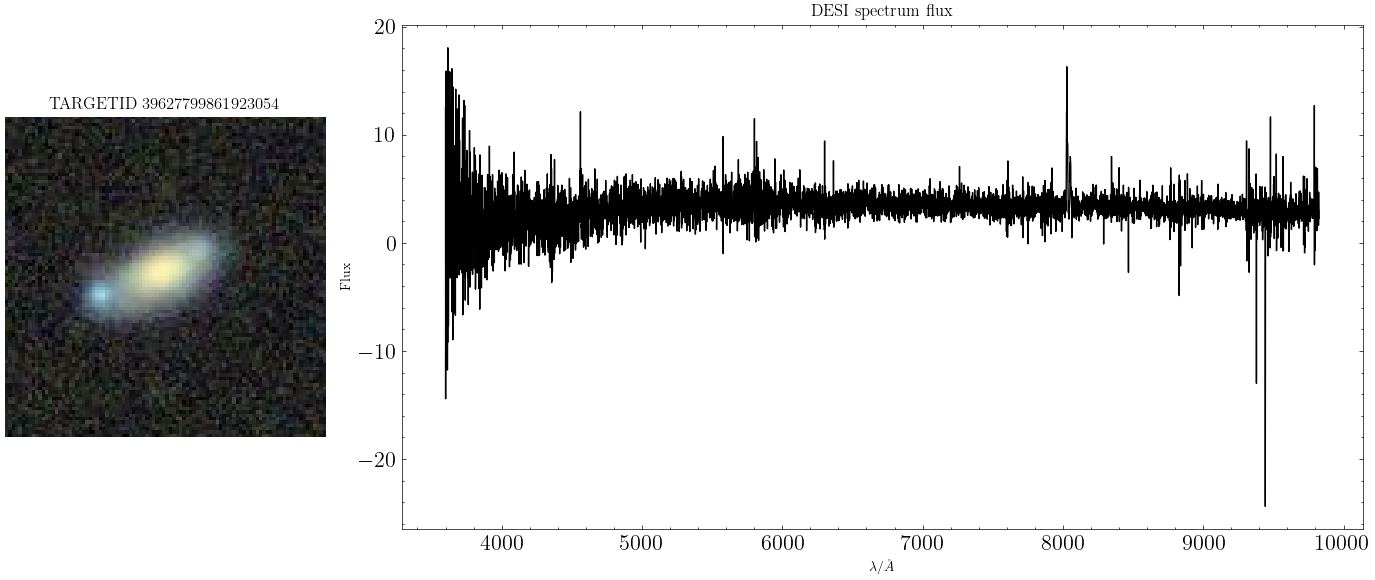

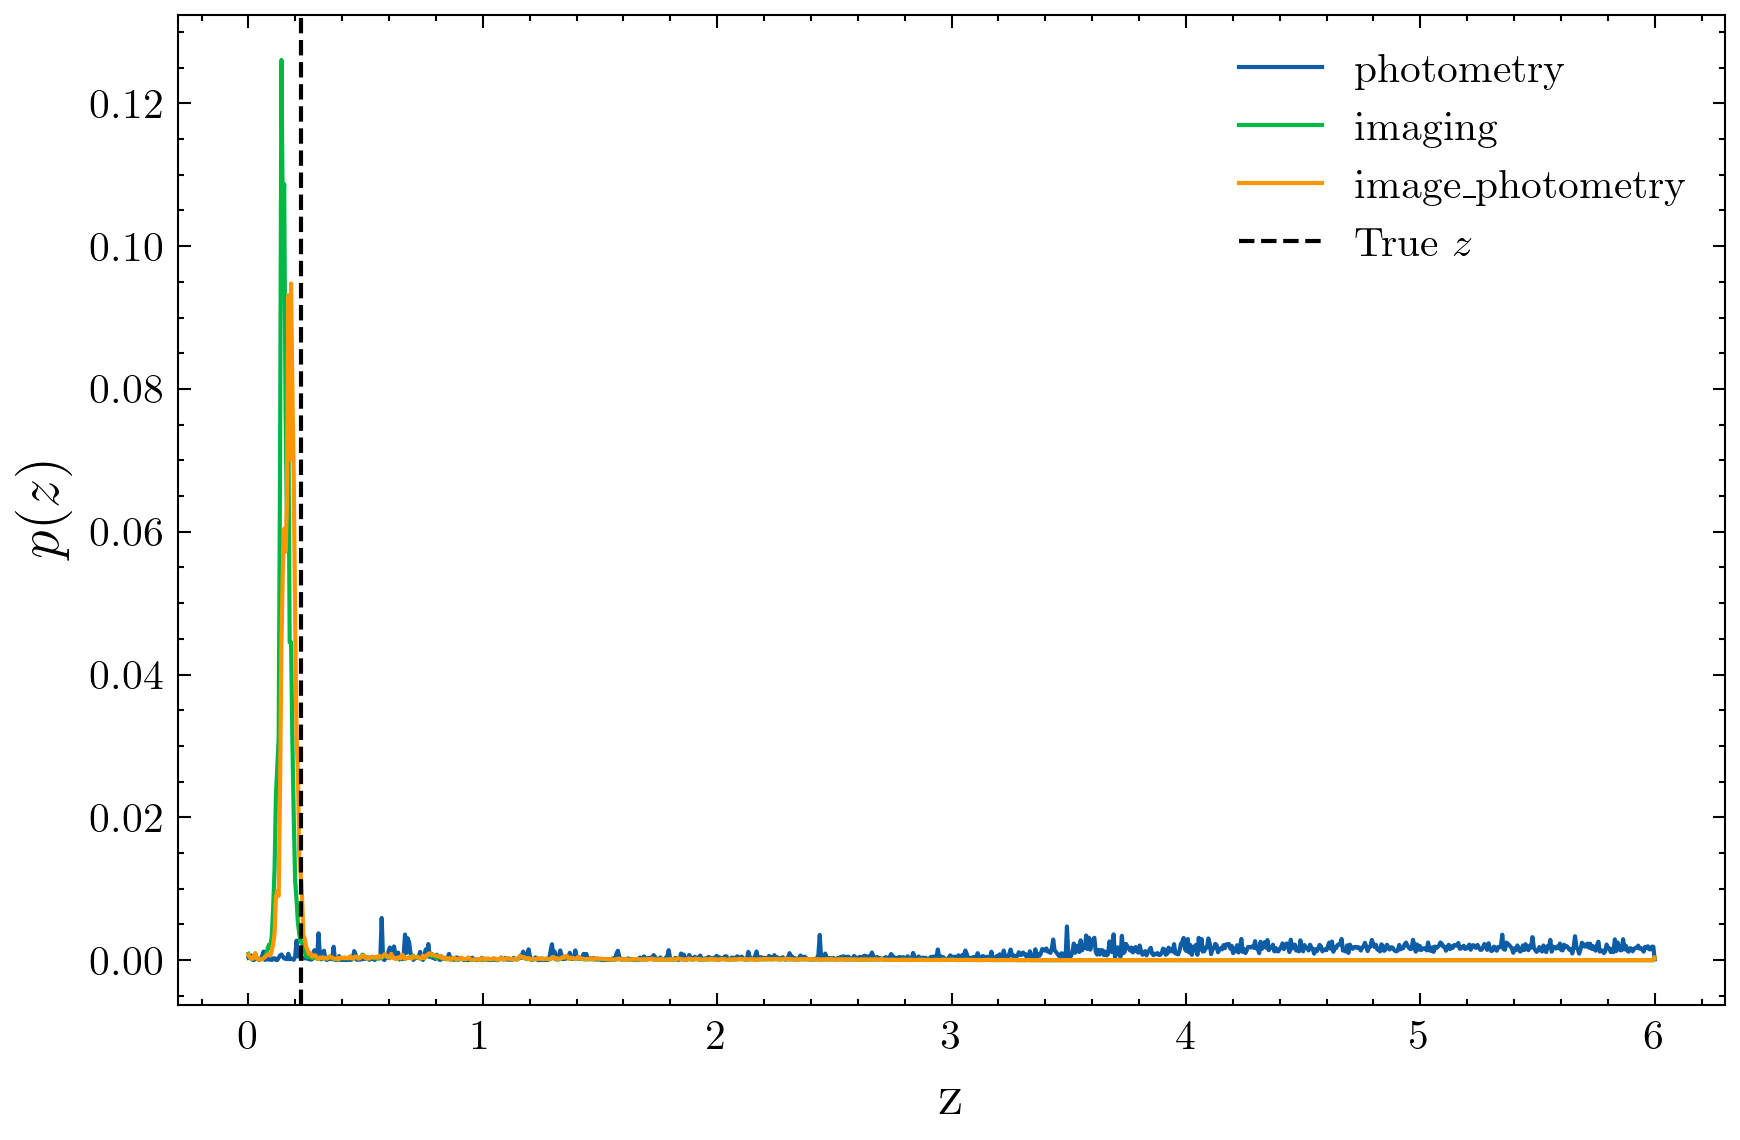

------------------------------------------------


<Table length=1>
     TARGETID        sSFR        LOG_MSTAR      legacysurvey_EBV   desi_Z  
      int64        float32        float64           float32       float32  
----------------- ---------- ------------------ ---------------- ----------
39627763648300531 -10.019158 10.344186782836914        0.0217791 0.10045972

Z                                     21.660831
Photometry                           649.887390
Imaging                               22.018389
Spectroscopy                           3.090765
Image + Photometry                    21.446045
Image + Spectrum                       3.065042
Image + Spectrum + Photometry          3.054961
Image + Spectrum + Photometry + Z      3.058526
ratio_p_ip                            30.303368
ratio_p_ip_rank                       15.000000
Name: 3347, dtype: float64

------------------------------------------------


In [52]:
plot_z_dist(
    check_df,
    table_sorted,
    names,
    tok_z_p,
    ascending=False 
)

In [ ]:
df["ratio_p_ip"].max()

np.float32(56.862377)

In [ ]:
df["ratio_p_ip"].max()

np.float32(56.862377)

In [ ]:
df["ratio_p_ip"].max()

np.float32(56.862377)

In [ ]:
df["ratio_p_ip"].max()

np.float32(56.862377)

In [ ]:
df["ratio_p_ip"].max()

np.float32(56.862377)

In [ ]:
df["ratio_p_ip"].max()

np.float32(56.862377)

In [ ]:
df["ratio_p_ip"].max()

np.float32(56.862377)